# Skeleton notebook for subject-level and group-level statistics
Use this notebook to write the code for subject- and group-level statistics on EEG data

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_jupyter.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne

## Loading data

In [2]:
# defining the events
event_id = {
    'Experiment/Start ': 1,
    #'Baseline/End' : 2, 
    #'Experiment/End': 3,
    'Question/Shows': 4, 
    #'Correct': 40,
    #'Incorrect':41
    'Question/Disappears': 5, 
    'Disappears': 10, 
    'Disappears/NearCorner': 11, 
    'Normal/Reappears': 200, 
    'Normal/Reappears/NearCorner': 201,
    'Surprise/Reappears': 210,
    #'Reappears/Sup/NearCorner': 211,
    'FinalDisappear': 98,
    'CornerHit': 99, 
}

In [3]:
from pathlib import Path
import mne

def preprocess_EEG_data(
    raw,
    bad_channels: list[str],
    event_id: dict,
    *,
    ica_exclude: list[int] | None = None,  # <- NEW
    ica_path: Path | None = None,          # <- NEW (where a saved ICA lives)
    tmin: float = -0.2,
    tmax: float = 0.7,
    baseline: tuple[float, float] = (-0.2, 0),
    l_freq: float = 0.1,
    h_freq: float = 40.0,
    reject: dict = {"eeg": 150e-6},
):

    # ------------------------------------------------------------------
    # 1)  Mark / interpolate bad channels
    # ------------------------------------------------------------------
    raw.info["bads"] = bad_channels

    # accommodate different EOG labels on your two rigs
    try:
        raw.set_channel_types({"HEOG": "eog", "VEOG": "eog"})
    except ValueError:
        raw.set_channel_types({"EOG1": "eog", "EOG2": "eog"})

    raw.set_montage("standard_1020", on_missing="warn")
    raw.interpolate_bads(reset_bads=True, mode="accurate", verbose=False)
    raw.drop_channels(raw.info["bads"])           # drop if any remain

    # ------------------------------------------------------------------
    # 2)  Filtering, referencing
    # ------------------------------------------------------------------
    raw.filter(l_freq, h_freq, verbose=False)
    raw.set_eeg_reference("average", projection=False, verbose=False)

    # --------------------------------------------------------
    # B) ALWAYS run/load ICA  (no `if ica_exclude:` gate!)
    # --------------------------------------------------------
    if ica_path and ica_path.exists():
        ica = mne.preprocessing.read_ica(ica_path, verbose=False)
    else:                                           # refit on the fly
        ica = mne.preprocessing.ICA(
            n_components=0.95, random_state=97, max_iter=800, verbose=False
        )
        raw_fit = raw.copy().filter(1.0, None, verbose=False)
        raw_fit.filter(None, h_freq, verbose=False)
        ica.fit(raw_fit, verbose=False)

    ica.exclude = ica_exclude or []    # [] if None
    ica.apply(raw, verbose=False)      # **always applied**

    # ------------------------------------------------------------------
    # 3)  Epoching
    # ------------------------------------------------------------------
    events, _ = mne.events_from_annotations(raw, verbose=False)
    event_id_tmp = {k: v for k, v in event_id.items() if v in events[:, 2]}
    epochs_tmp = mne.Epochs(
        raw,
        events,
        event_id=event_id_tmp,
        tmin=tmin,
        tmax=tmax,
        baseline=baseline,
        preload=True,
        reject=reject,
        verbose=False,
    ).resample(250)

    return epochs_tmp


In [4]:
# load in the data
data_path = Path("/work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/EEGDataOwnFRFR") # insert path to the preprocessed epochs of the FaceWord EEG data
#ica_path = Path("/work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/data_after_ICA") 

# loading in the file with the bad channels identified by each group
session_info_path = data_path / "session_info.txt"

    
# load in session information (bad channels, etc.) txt file with dictionary
with open(session_info_path, "r") as f:
    session_info = eval(f.read())

print(session_info)

# creating a figures folder for saving plots from drop log
fig_path = Path("/work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/figures")

if not fig_path.exists():
    fig_path.mkdir(parents=True)

{'group4_own': {'bad_channels': ['TP9', 'TP10'], 'tmin': -0.2, 'tmax': 0.5}, 'group4_own_2': {'bad_channels': ['T7'], 'tmin': 0.2, 'tmax': 0.5}}



Processing participant1...


Extracting parameters from /work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/EEGDataOwnFRFR/group4_own.vhdr...
Setting channel info structure...
Reading 0 ... 945759  =      0.000 ...   945.759 secs...
Finished participant1

Processing participant2...
Extracting parameters from /work/SofiaScharf-Matthiesen#5940/EEG_Own_Analysis/EEGDataOwnFRFR/group4_own_2.vhdr...
Setting channel info structure...
Reading 0 ... 1071459  =      0.000 ...  1071.459 secs...
Finished participant2


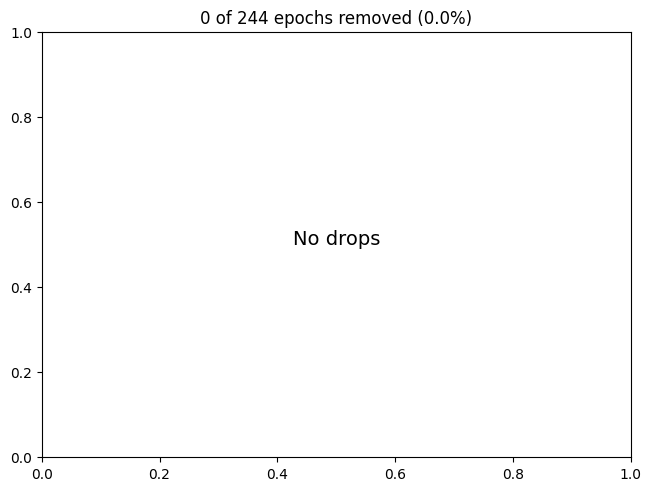

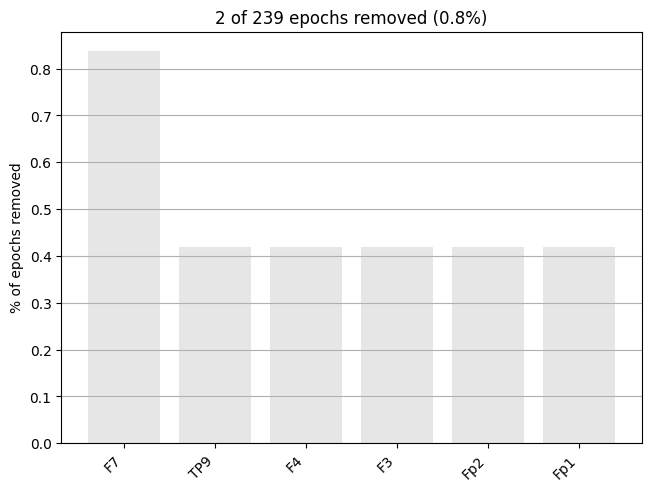

In [5]:
groupname = "group4_own"  # Base name (without _2)

session_info = {
    "participant1": {
        "bad_channels": ["TP10", "TP9"],
        "ica_exclude": [0, 4],                      # ICs you want to drop
        #"ica_file": ica_path / "preprocessed1_ica.fif",   # ← path goes here
        "tmin": None,
        "tmax": None
    },
    "participant2": {
        "bad_channels": ["T7"],
        "ica_exclude": [0, 1],
        #"ica_file": ica_path / "preprocessed2_ica.fif",
        "tmin": None,
        "tmax": None
    },
}


all_epochs = []

for participant, info in session_info.items():
    print(f"\nProcessing {participant}...")

    # Decide which .vhdr file to load
    vhdr_file = (
        data_path / f"{groupname}.vhdr"
        if participant == "participant1"
        else data_path / f"{groupname}_2.vhdr"
    )
    raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

    if info["tmin"] is not None or info["tmax"] is not None:
        raw.crop(tmin=info["tmin"], tmax=info["tmax"])

    epochs = preprocess_EEG_data(
        raw,
        bad_channels=info["bad_channels"],
        event_id=event_id,
        ica_exclude=info["ica_exclude"],
        #ica_path=info["ica_file"],      # can be None if you want to refit
    )

    # Save a drop-log figure
    drop_log_fig = epochs.plot_drop_log(show=False)
    drop_log_fig.savefig(fig_path / f"{participant}_drop_log.png")
    all_epochs.append(epochs)

    print(f"Finished {participant}")

In [6]:
all_epochs

[<Epochs | 244 events (all good), -0.2 – 0.696 s (baseline -0.2 – 0 s), ~13.4 MB, data loaded,
  'Experiment/Start ': 1
  'Question/Shows': 4
  'Question/Disappears': 4
  'Disappears': 109
  'Disappears/NearCorner': 8
  'Normal/Reappears': 90
  'Normal/Reappears/NearCorner': 10
  'Surprise/Reappears': 16
  'FinalDisappear': 1
  'CornerHit': 1>,
 <Epochs | 237 events (all good), -0.2 – 0.696 s (baseline -0.2 – 0 s), ~13.1 MB, data loaded,
  'Experiment/Start ': 2
  'Question/Shows': 4
  'Question/Disappears': 4
  'Disappears': 106
  'Disappears/NearCorner': 7
  'Normal/Reappears': 87
  'Normal/Reappears/NearCorner': 9
  'Surprise/Reappears': 16
  'FinalDisappear': 1
  'CornerHit': 1>]

# Preliminary Inspections

## Group Window N2B-PBa

In [7]:
picks_np = ['Fz', 'FC1', 'FC2', 'Cz', 'CP1', 'CP2']
picks_n2 = ['Fz', 'FC1', 'FC2', 'Cz']
picks_p3a = ['Cz', 'FC1', 'FC2', 'Fz']
picks_p3b = ['P3', 'P4', 'Pz']
picks_vmmn = ['Oz', 'O1', 'O2']
tmin = 0.3
tmax = 0.360

### Plot Averaged

In [8]:
# code for group-level windowed mean
# prep data for plotting
normal = np.array([])
surprise = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_normal = epochs["Normal"]
    epochs_surprise = epochs["Surprise"]

    # extract the data for the time window and channels of interest
    data_normal = epochs_normal.get_data(tmin = tmin, tmax = tmax)
    data_surprise = epochs_surprise.get_data(tmin = tmin, tmax = tmax)

    # calculate the mean over the channel and trial dimension (axis 1 and 2)
    # we keep the time dimension (axis 0) to plot the time course
    data_normal_mean = np.mean(data_normal, axis=(0, 1))
    data_surprise_mean = np.mean(data_surprise, axis=(0, 1))
    print(data_normal_mean.shape)

    # append the data to the arrays
    normal = np.concatenate((normal, data_normal_mean), axis=0)
    surprise = np.concatenate((surprise, data_surprise_mean), axis=0)

print(normal.shape)
print(surprise.shape)

# Average over trials & channels (keep time dimension)
normal_mean = np.mean(data_normal, axis=(0, 1))  # shape: [n_timepoints]
surprise_mean = np.mean(data_surprise, axis=(0, 1))

print(normal_mean.shape)
print(surprise_mean.shape)


(15,)
(15,)
(30,)
(30,)
(15,)
(15,)


In [9]:
epochs_t = epochs_normal.copy().crop(tmin=0.003, tmax=0.697)

/tmp/ipykernel_18225/26733412.py:1: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.Epochs'>.tmax (0.696 s)
  epochs_t = epochs_normal.copy().crop(tmin=0.003, tmax=0.697)


/tmp/ipykernel_18225/453234351.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap    = get_cmap("tab10")      # up to 10 visually distinct colours


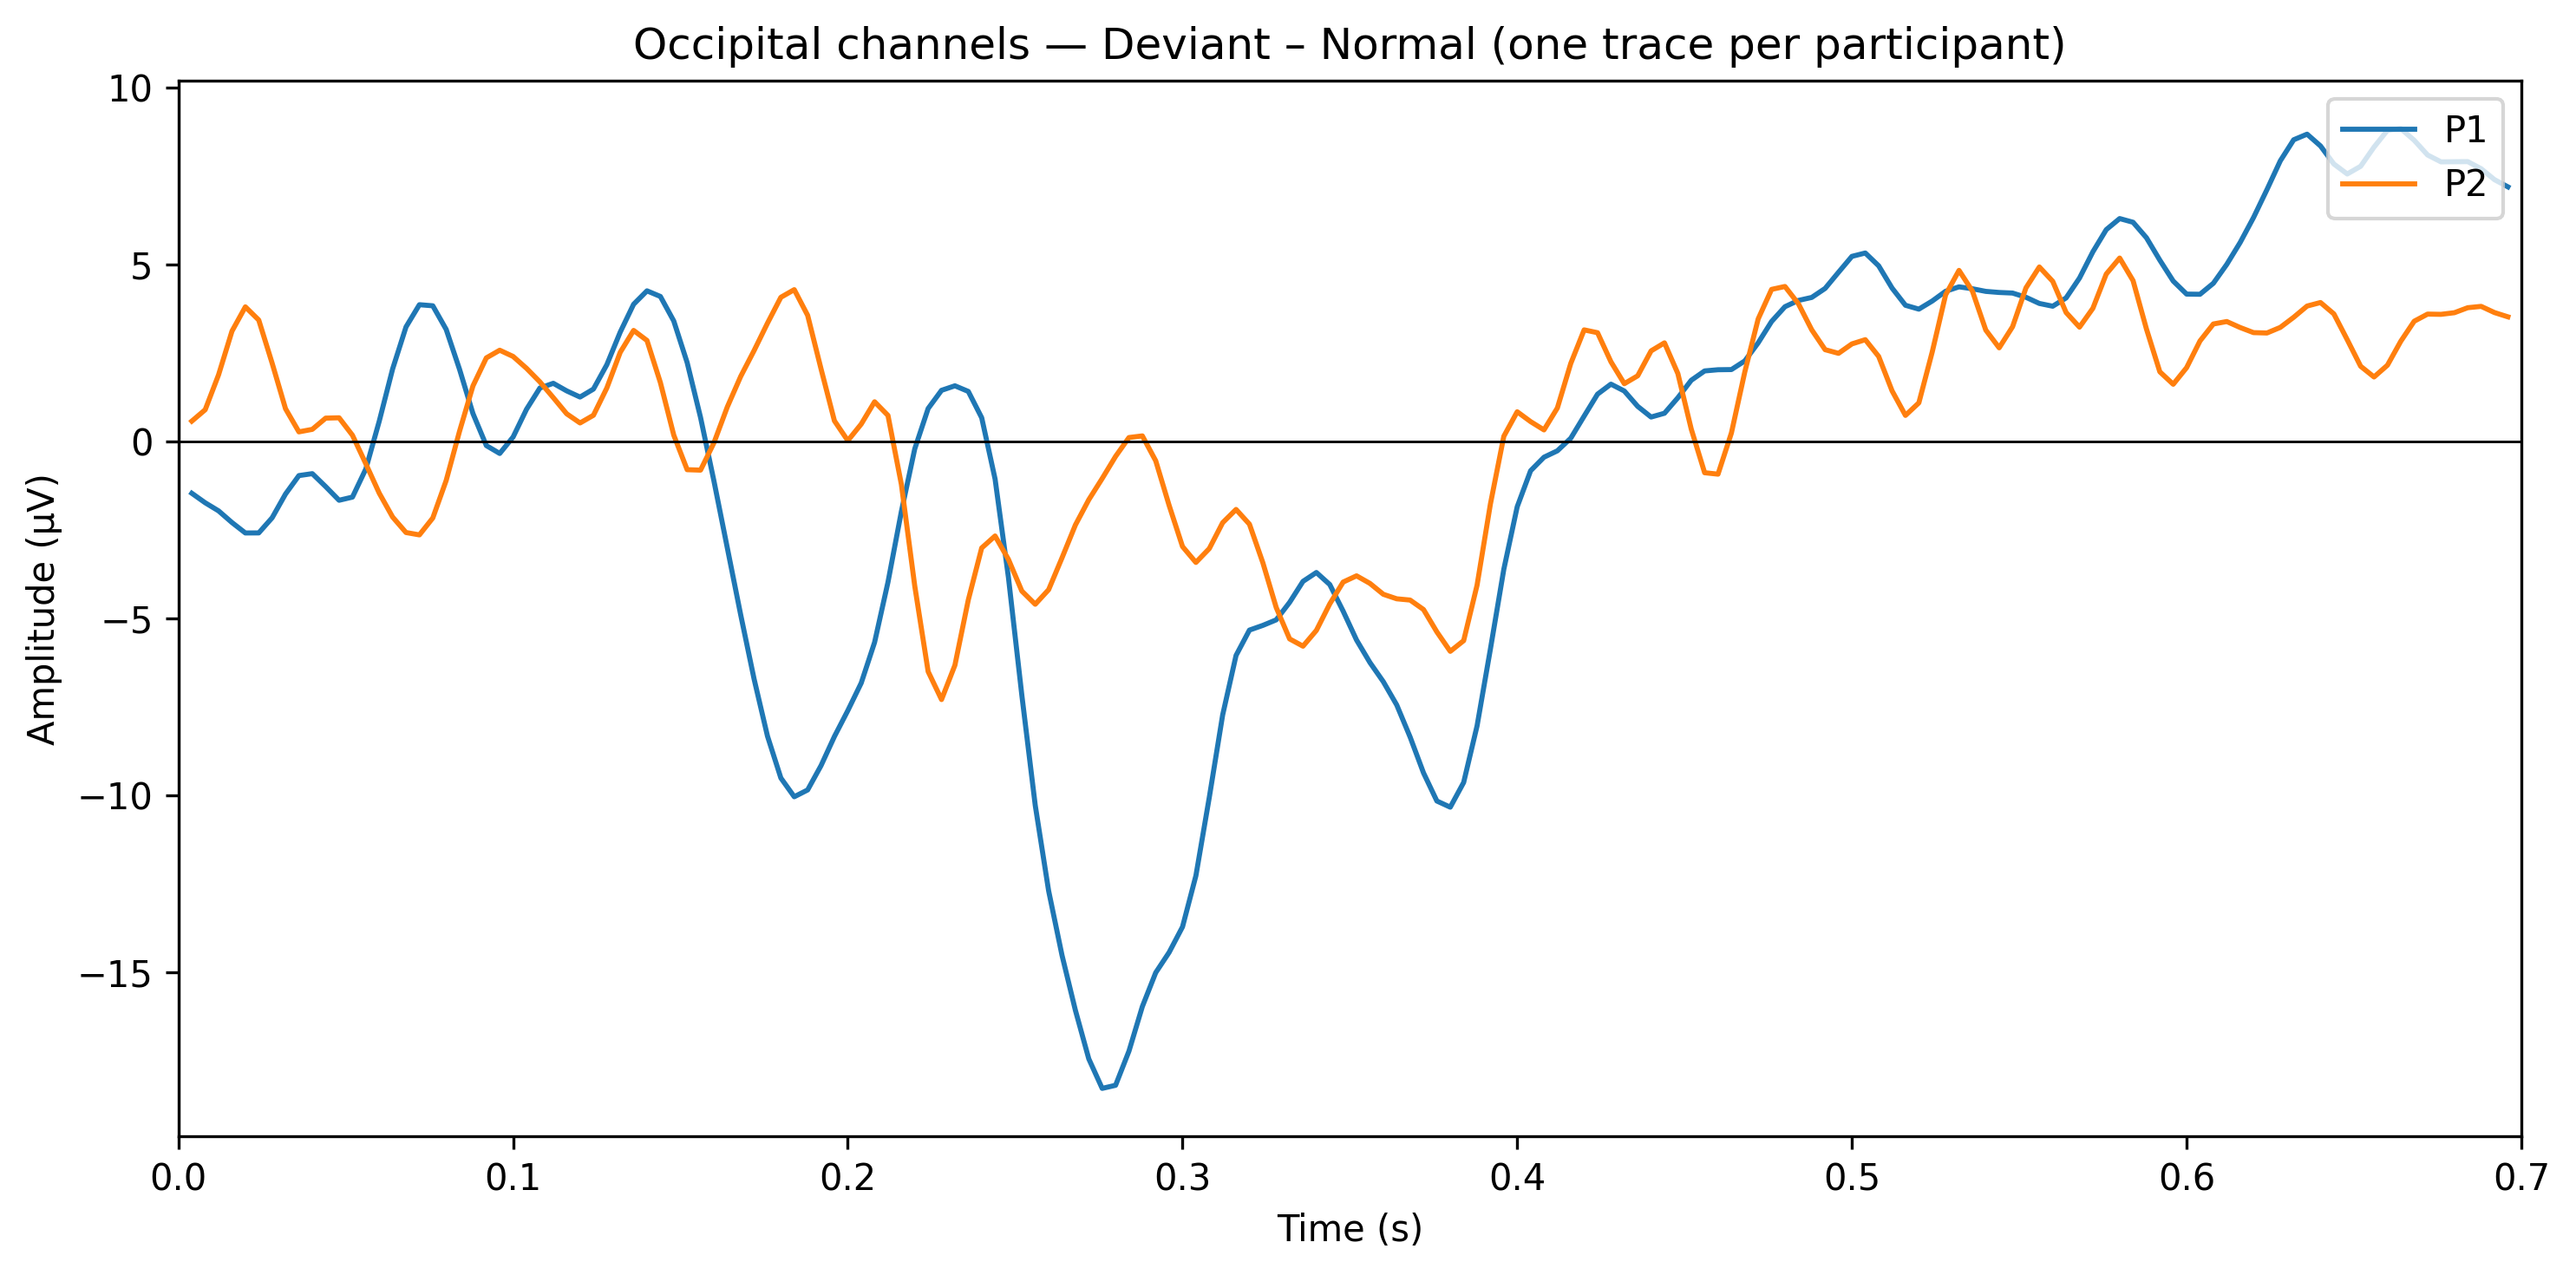

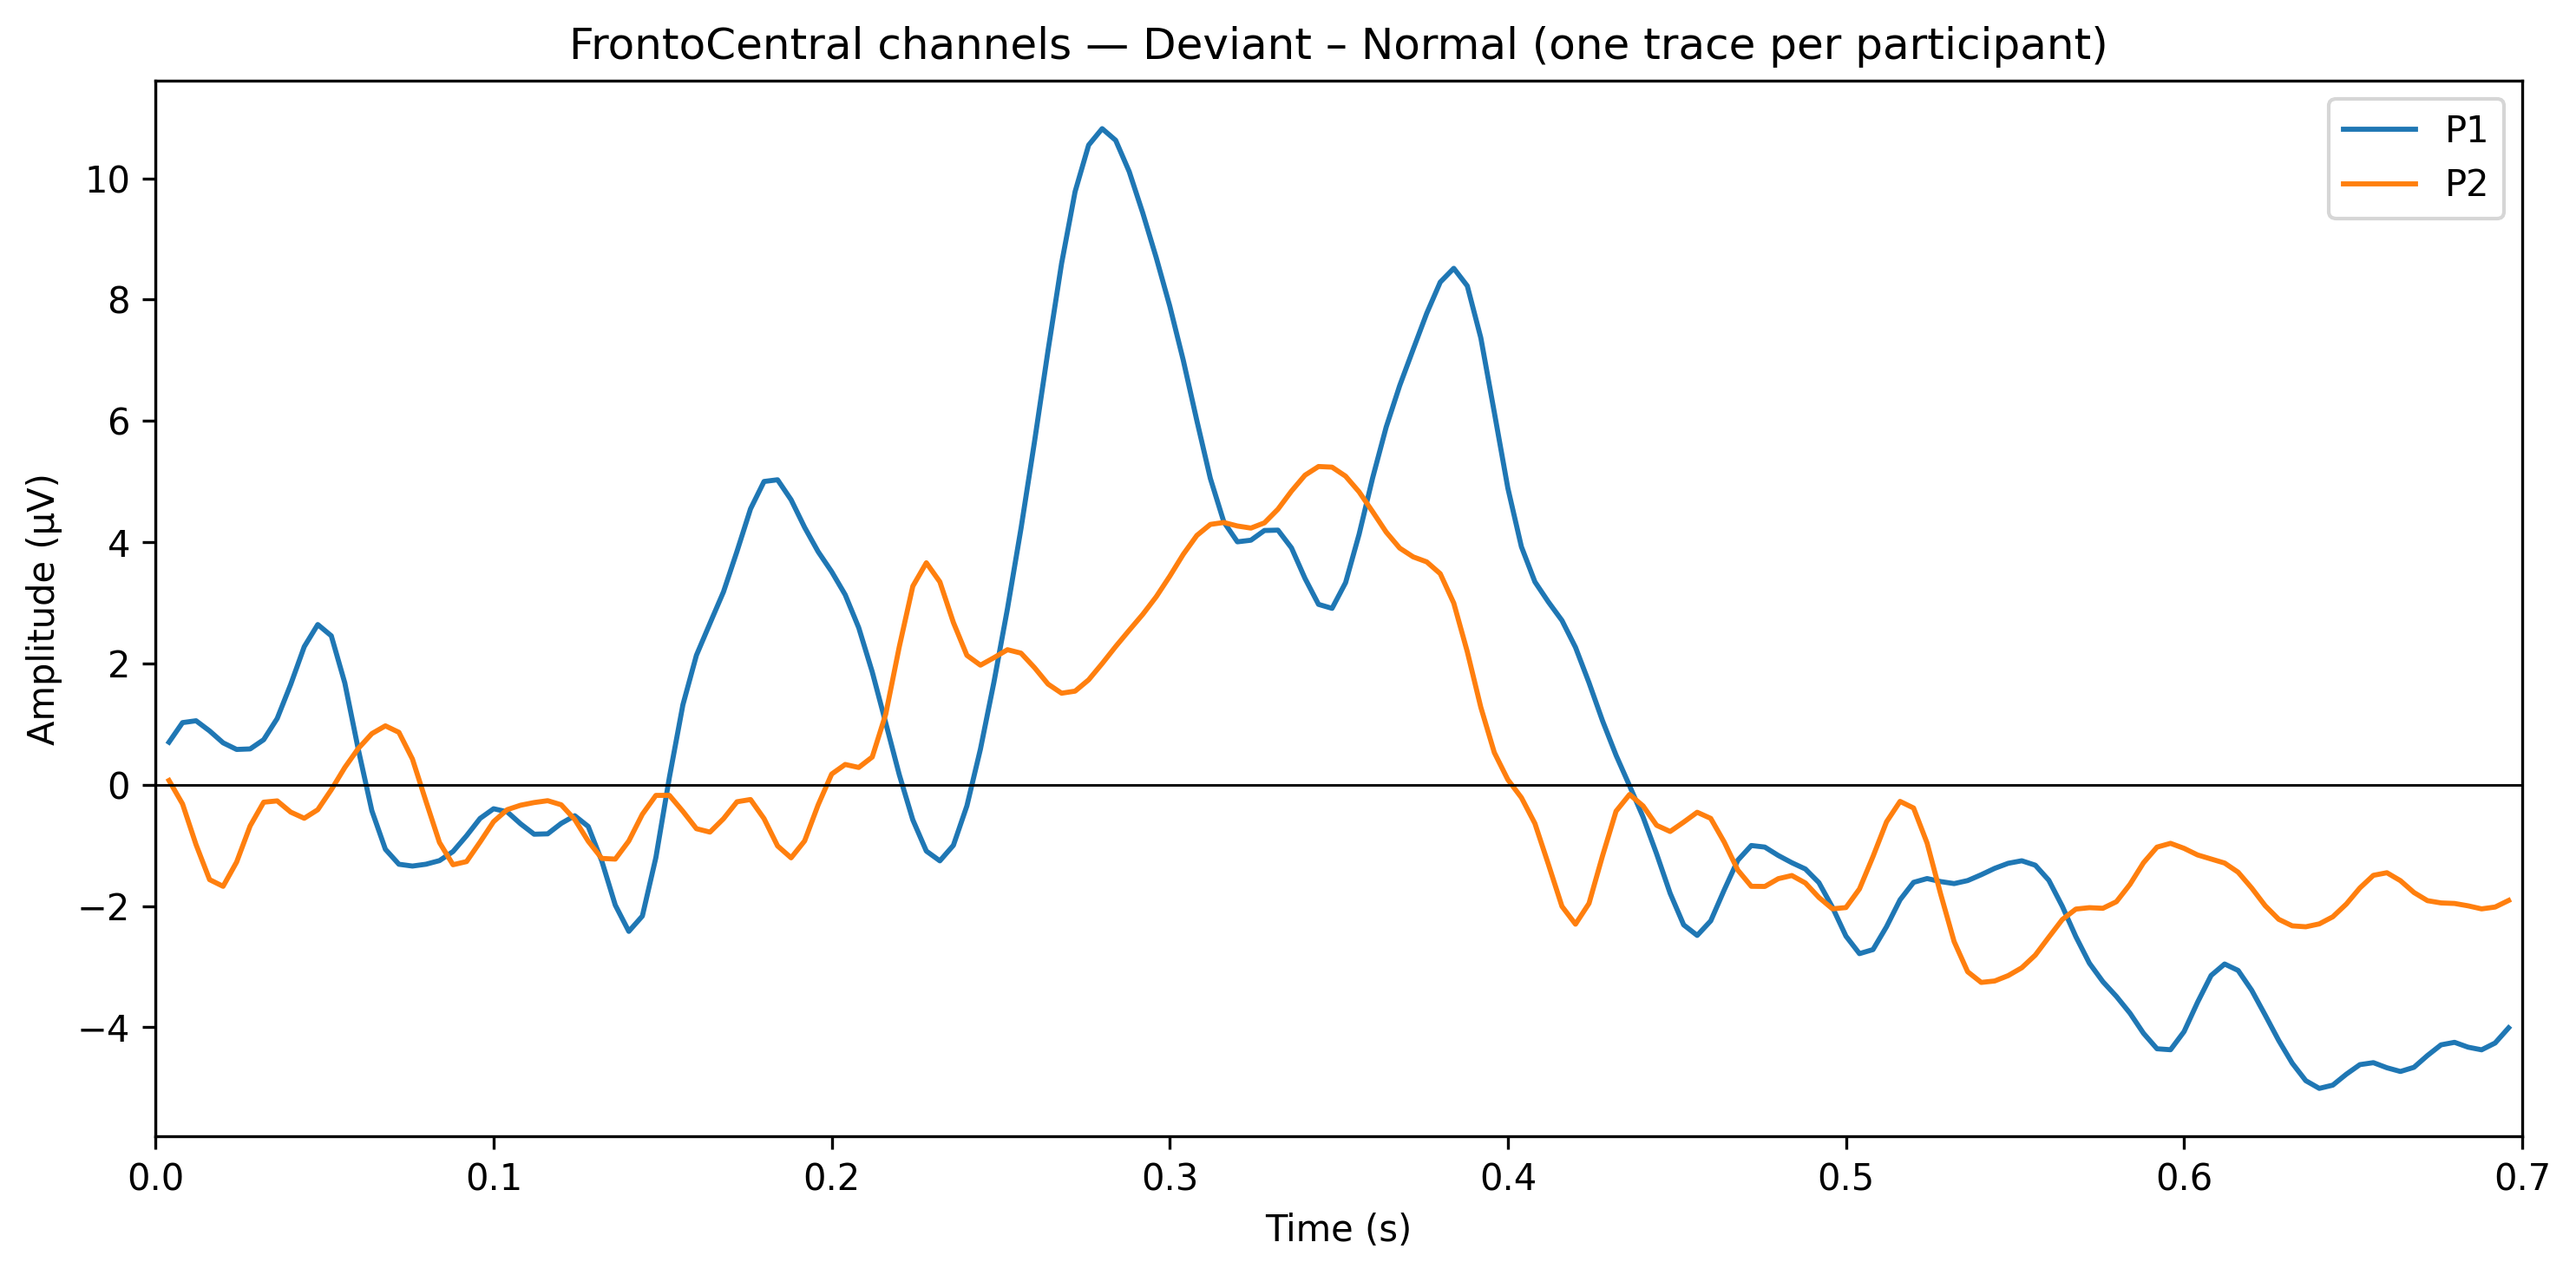

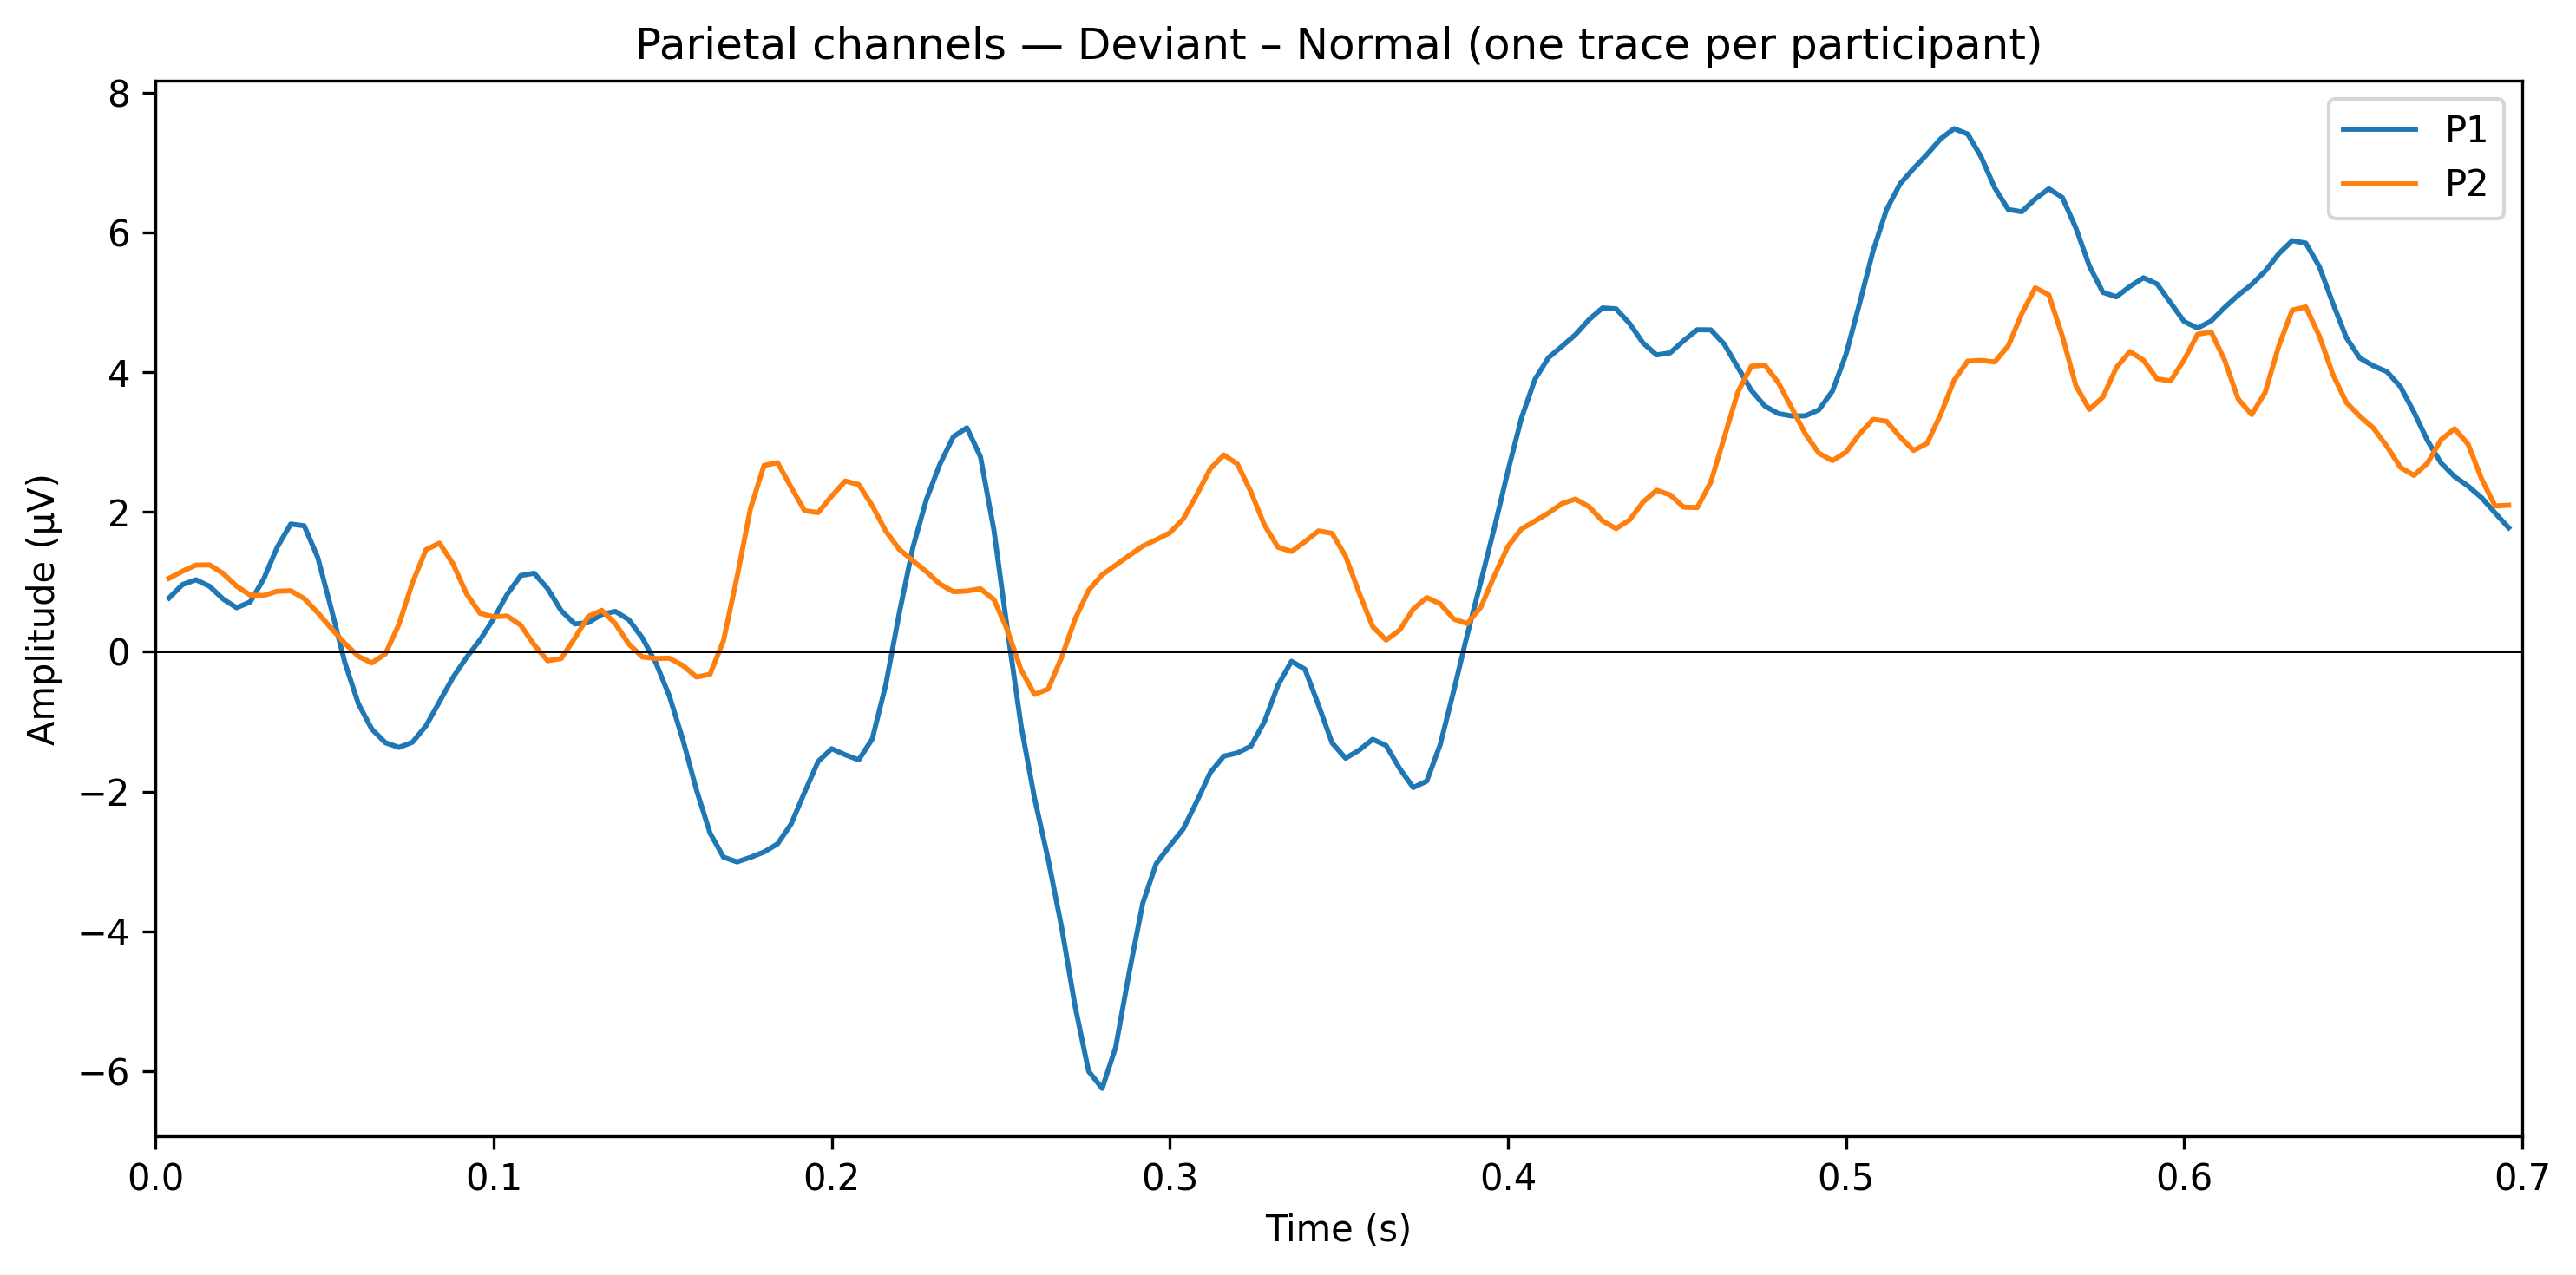

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# ------------------------------------------------------------------
# 0)  define the channel subsets you want to loop over
# ------------------------------------------------------------------
chan_sets = {
    "Occipital": picks_vmmn,
    "FrontoCentral":  picks_n2,
    "Parietal":  picks_p3b,
}

times   = epochs_t.times    # common 0–0.7 s axis
cmap    = get_cmap("tab10")      # up to 10 visually distinct colours

# ------------------------------------------------------------------
# 1)  outer loop → one figure per channel subset
# ------------------------------------------------------------------
for set_name, picks in chan_sets.items():

    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

    # inner loop → one line per participant
    for idx, ep in enumerate(all_epochs, start=1):

        # mean across trials & chosen channels (V)
        dev = ep["Surprise"].get_data(picks=picks, tmin=0.0, tmax=0.7).mean(axis=(0, 1))
        nor = ep["Normal"  ].get_data(picks=picks, tmin=0.0, tmax=0.7).mean(axis=(0, 1))

        diff = (dev - nor) * 1e6                # convert to µV
        ax.plot(times, diff,
                label=f"P{idx}",
                color=cmap((idx - 1) % 10),
                lw=1.4)

    # -- cosmetic touches shared by every figure -------------------
    ax.axvline(0, color="black", lw=1)
    ax.axhline(0, color="black", lw=0.7)

    ax.set(
        xlim=(0, 0.7),
        xlabel="Time (s)",
        ylabel="Amplitude (µV)",
        title=f"{set_name} channels — Deviant – Normal (one trace per participant)",
    )
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()           # or fig.savefig(f"{set_name}_diff_traces.png", dpi=300)


In [16]:
epochs_5t = epochs_normal.copy().crop(tmin=0.000, tmax=0.497)

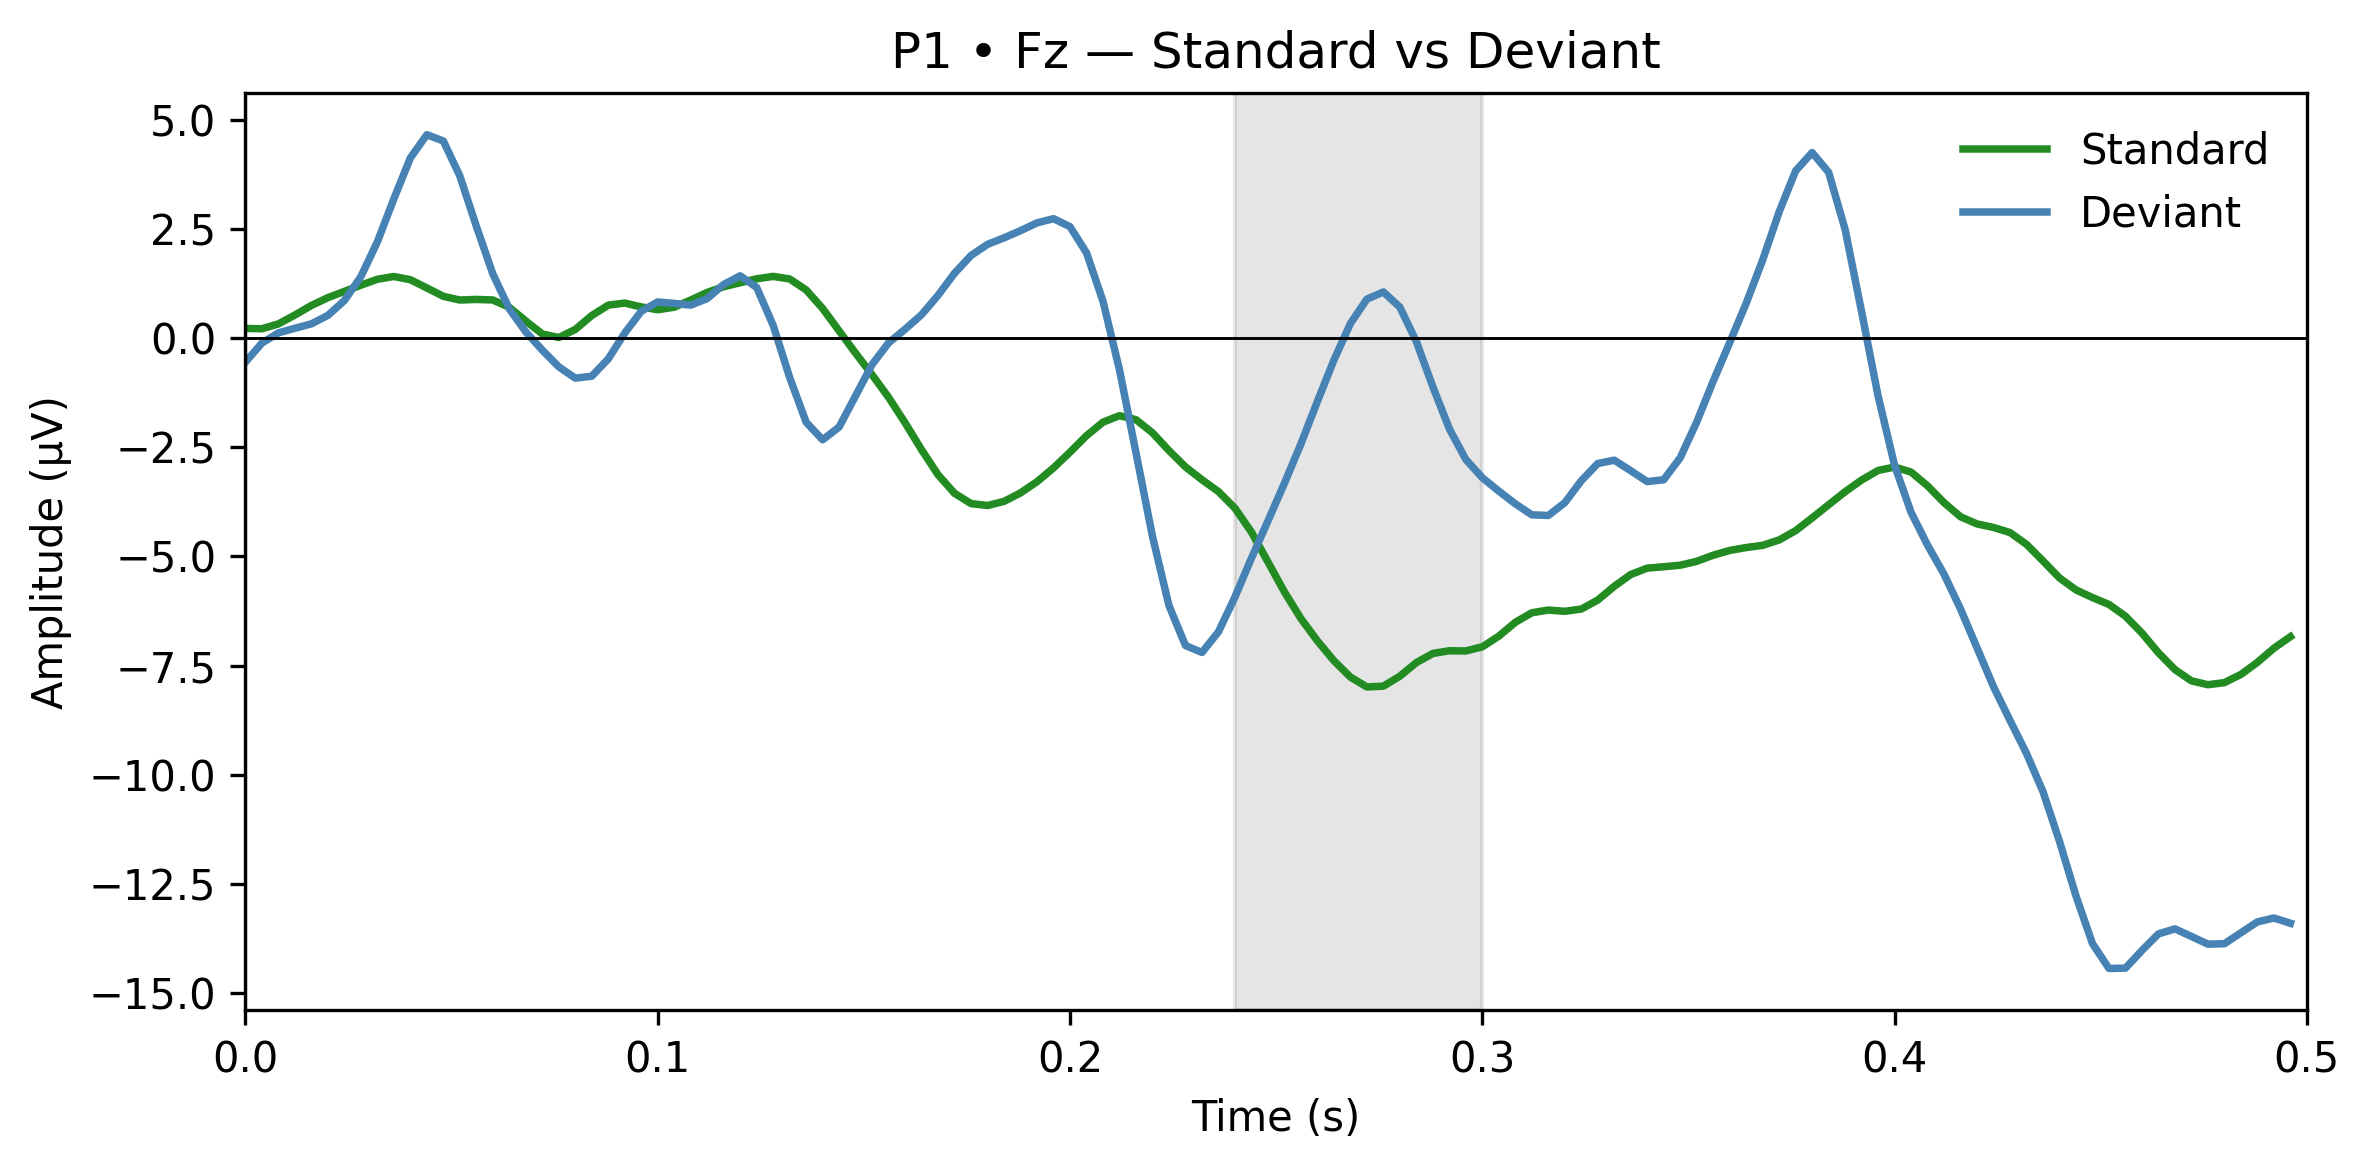

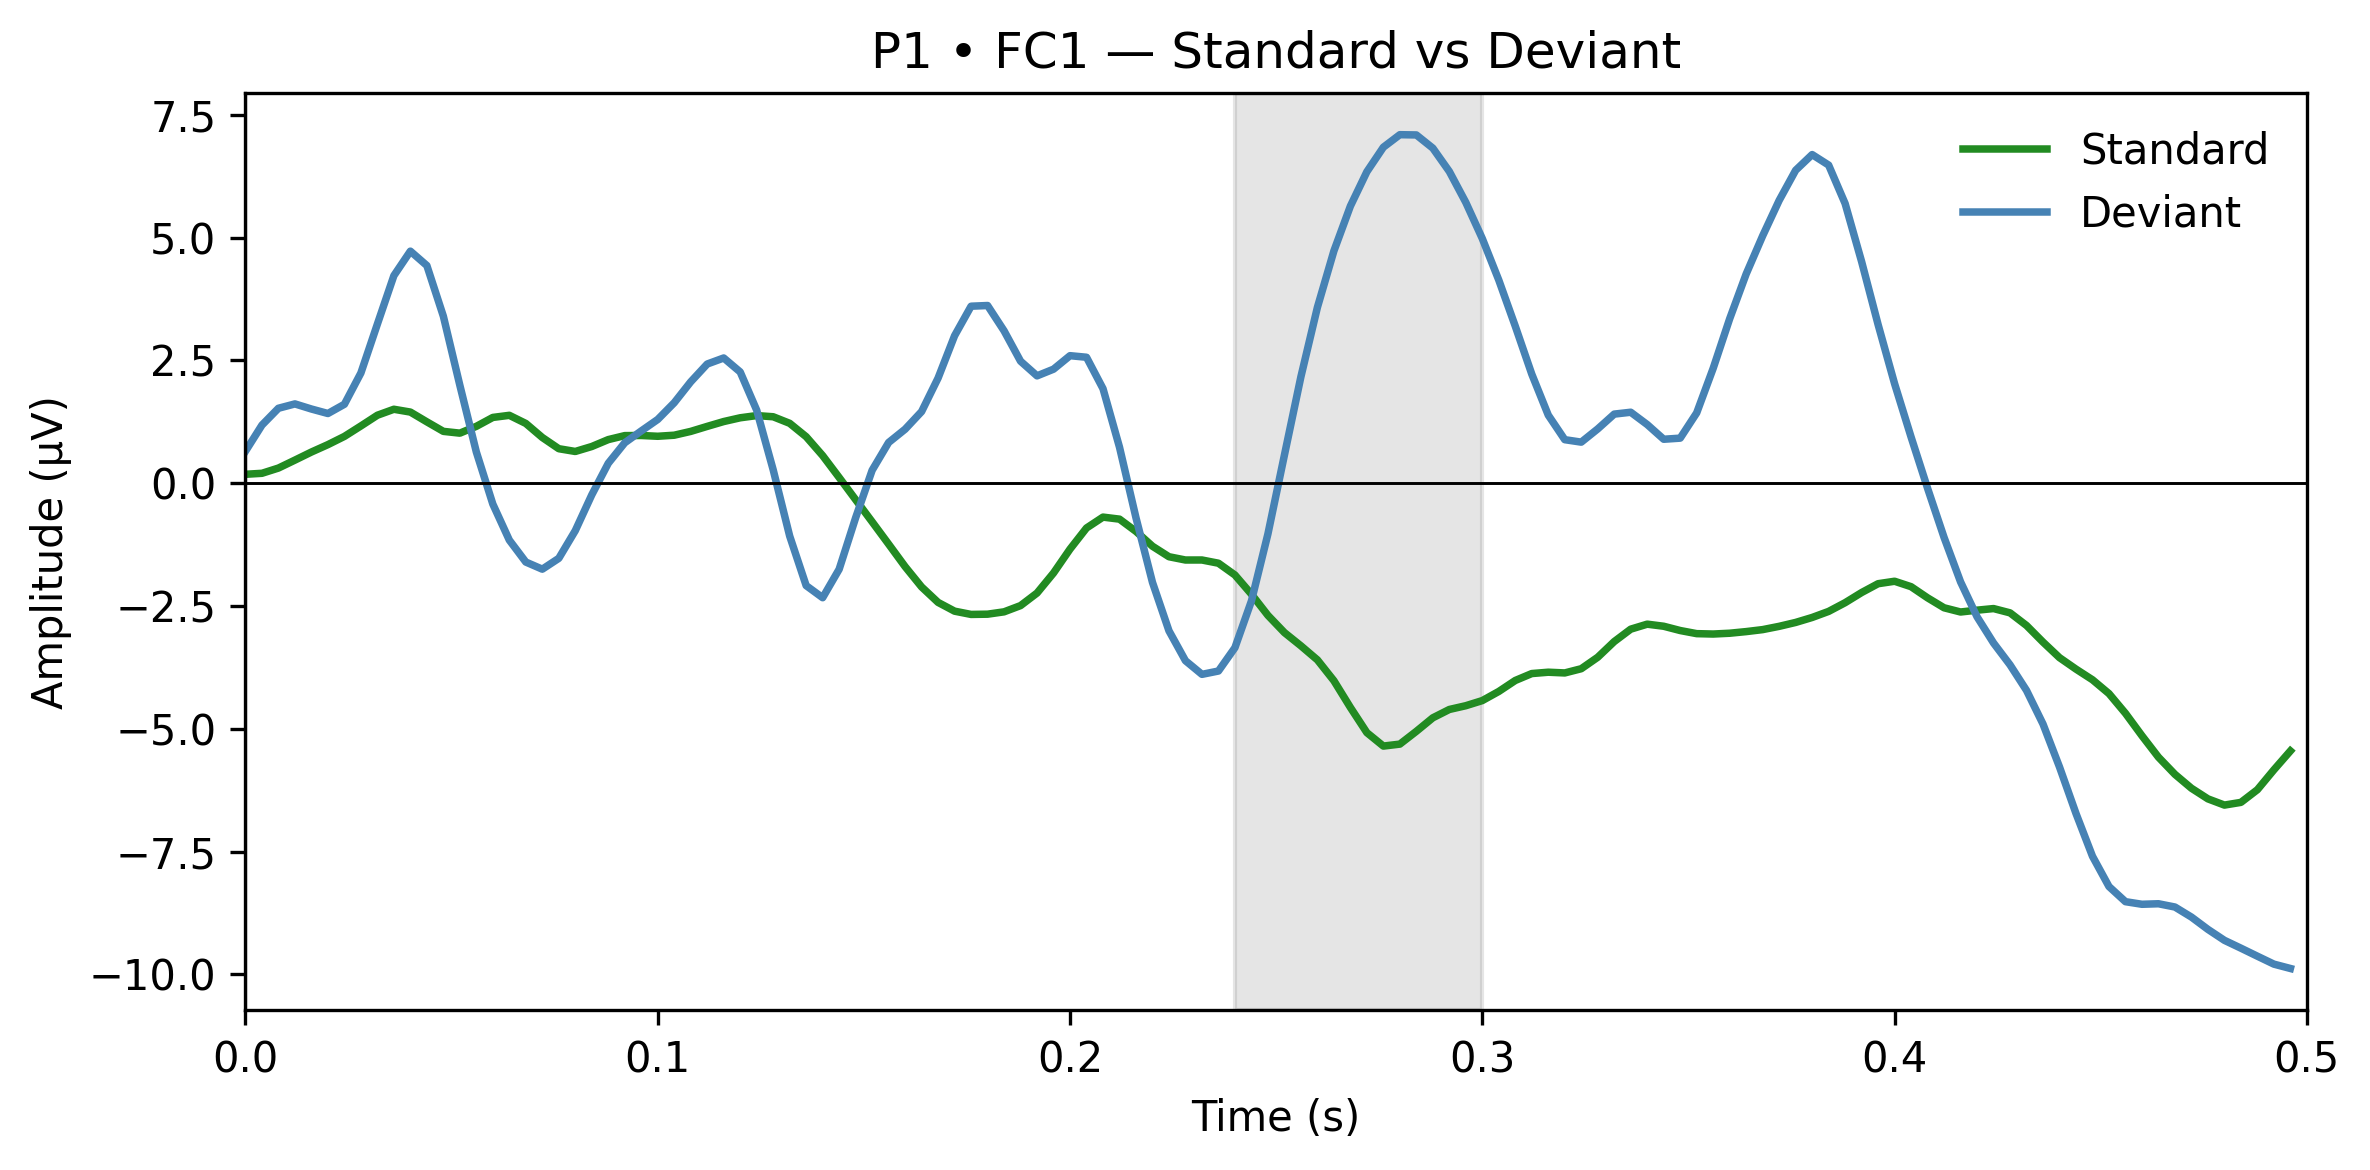

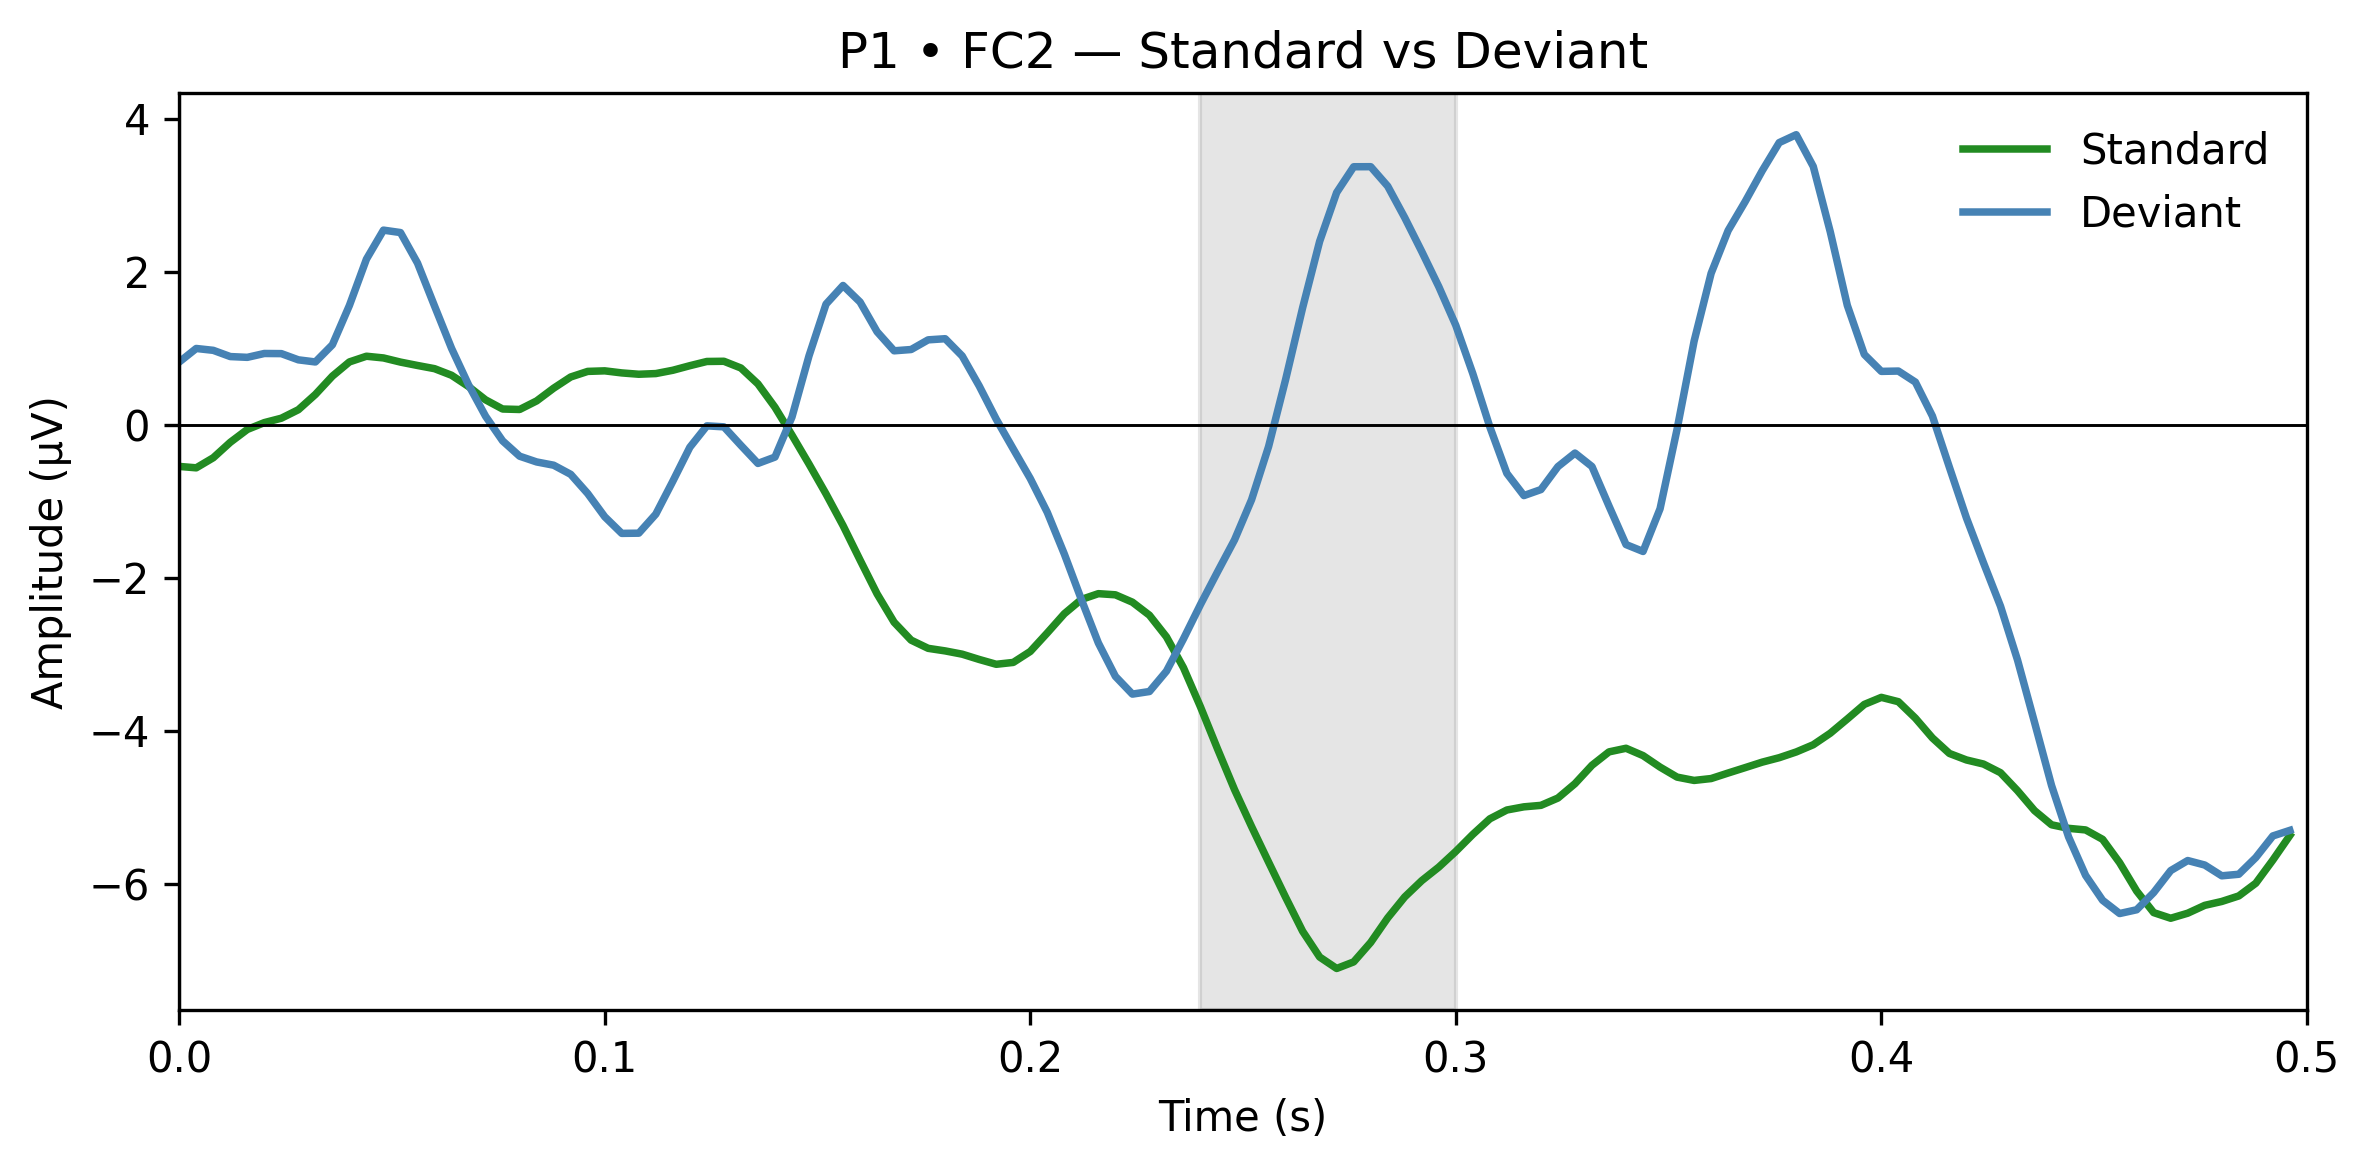

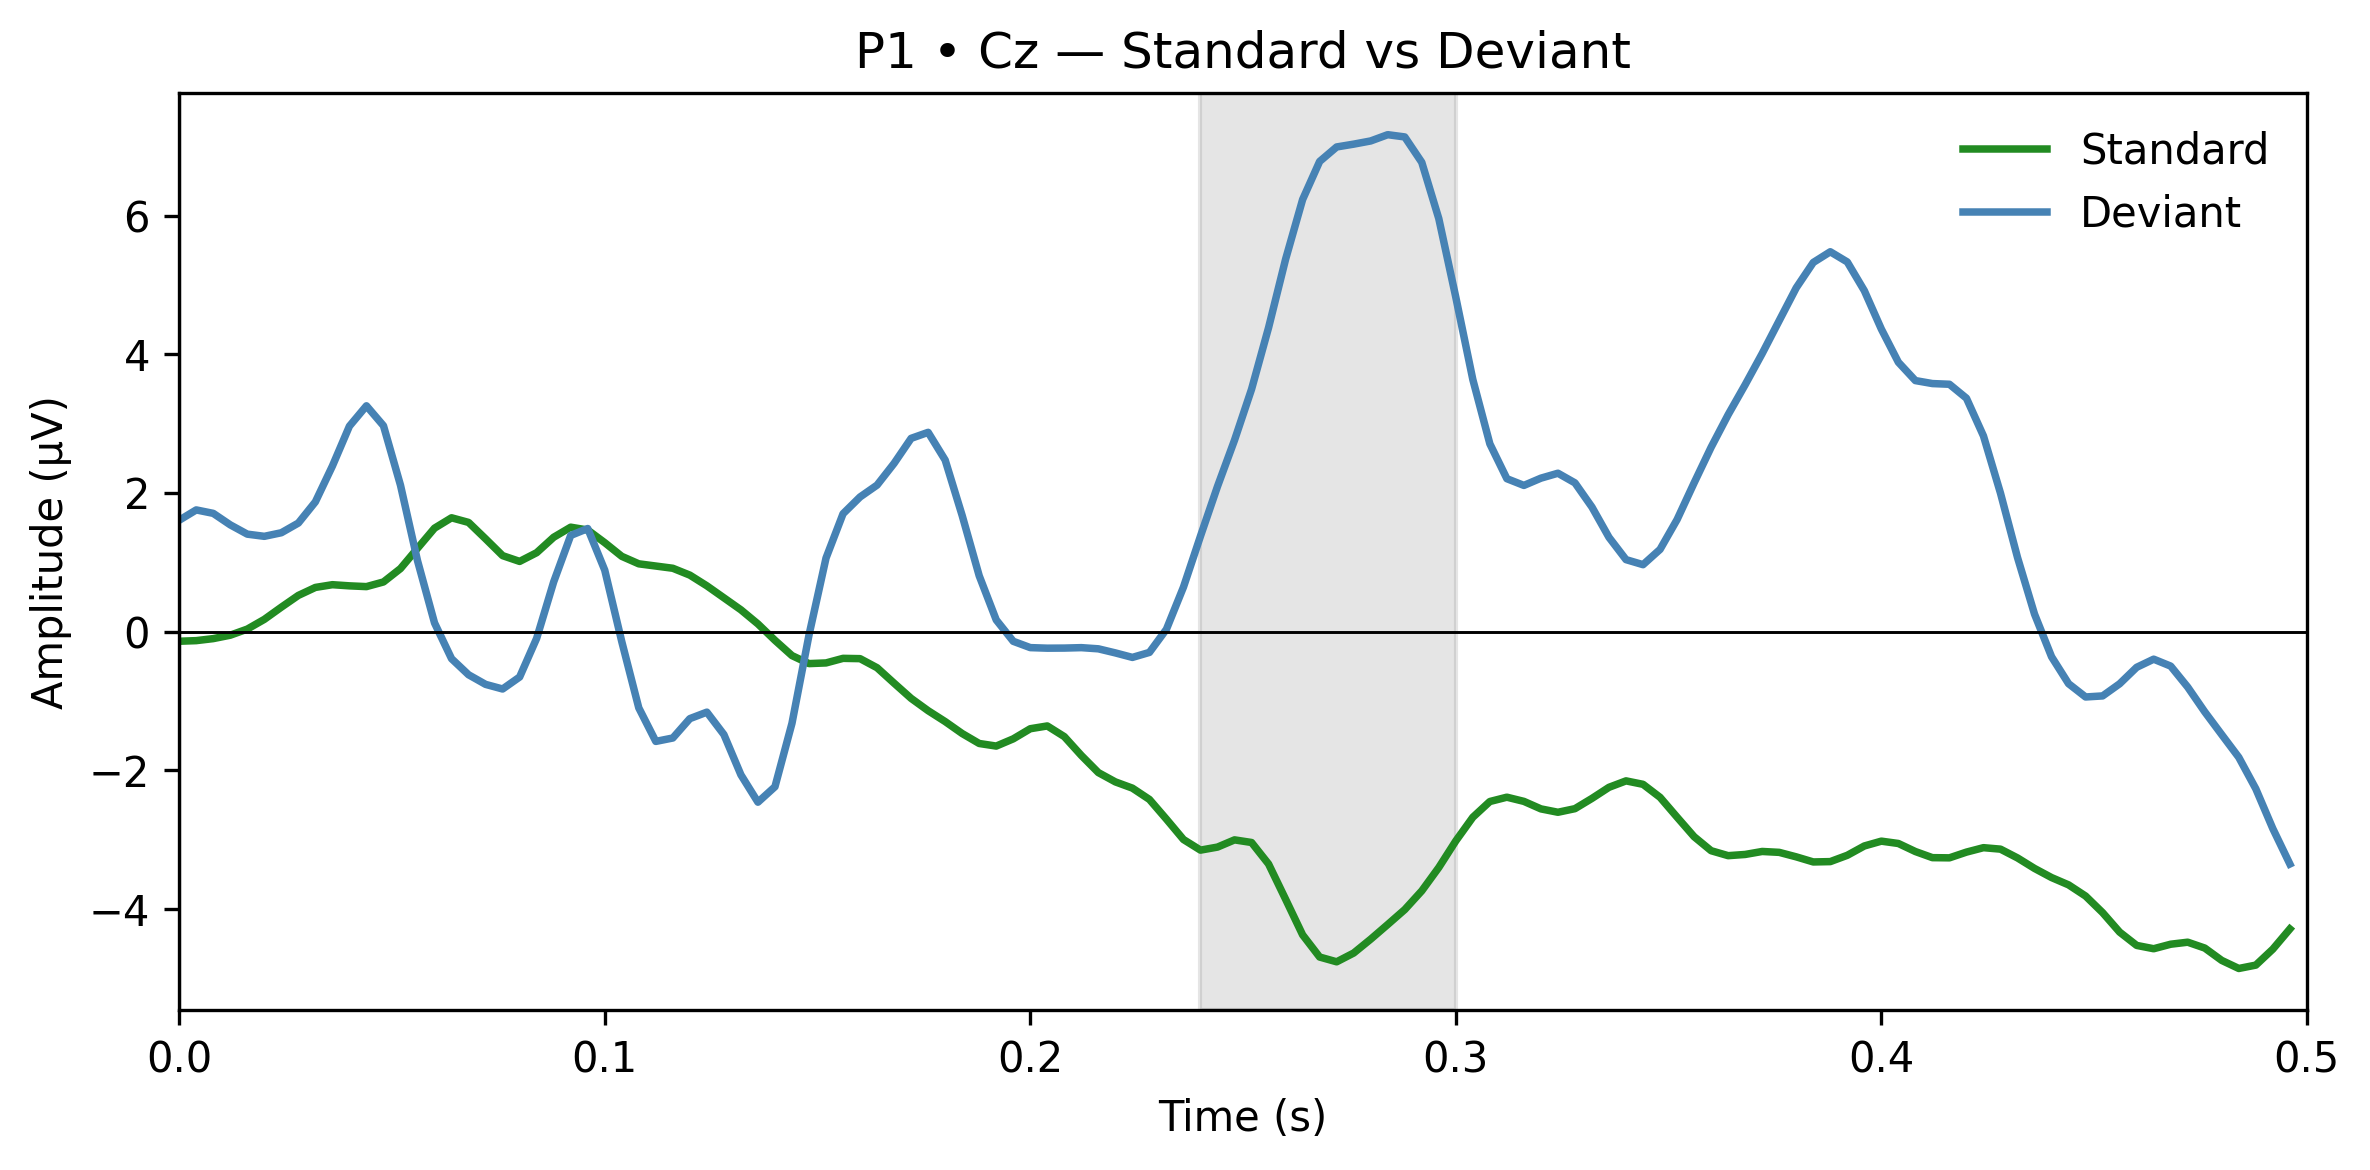

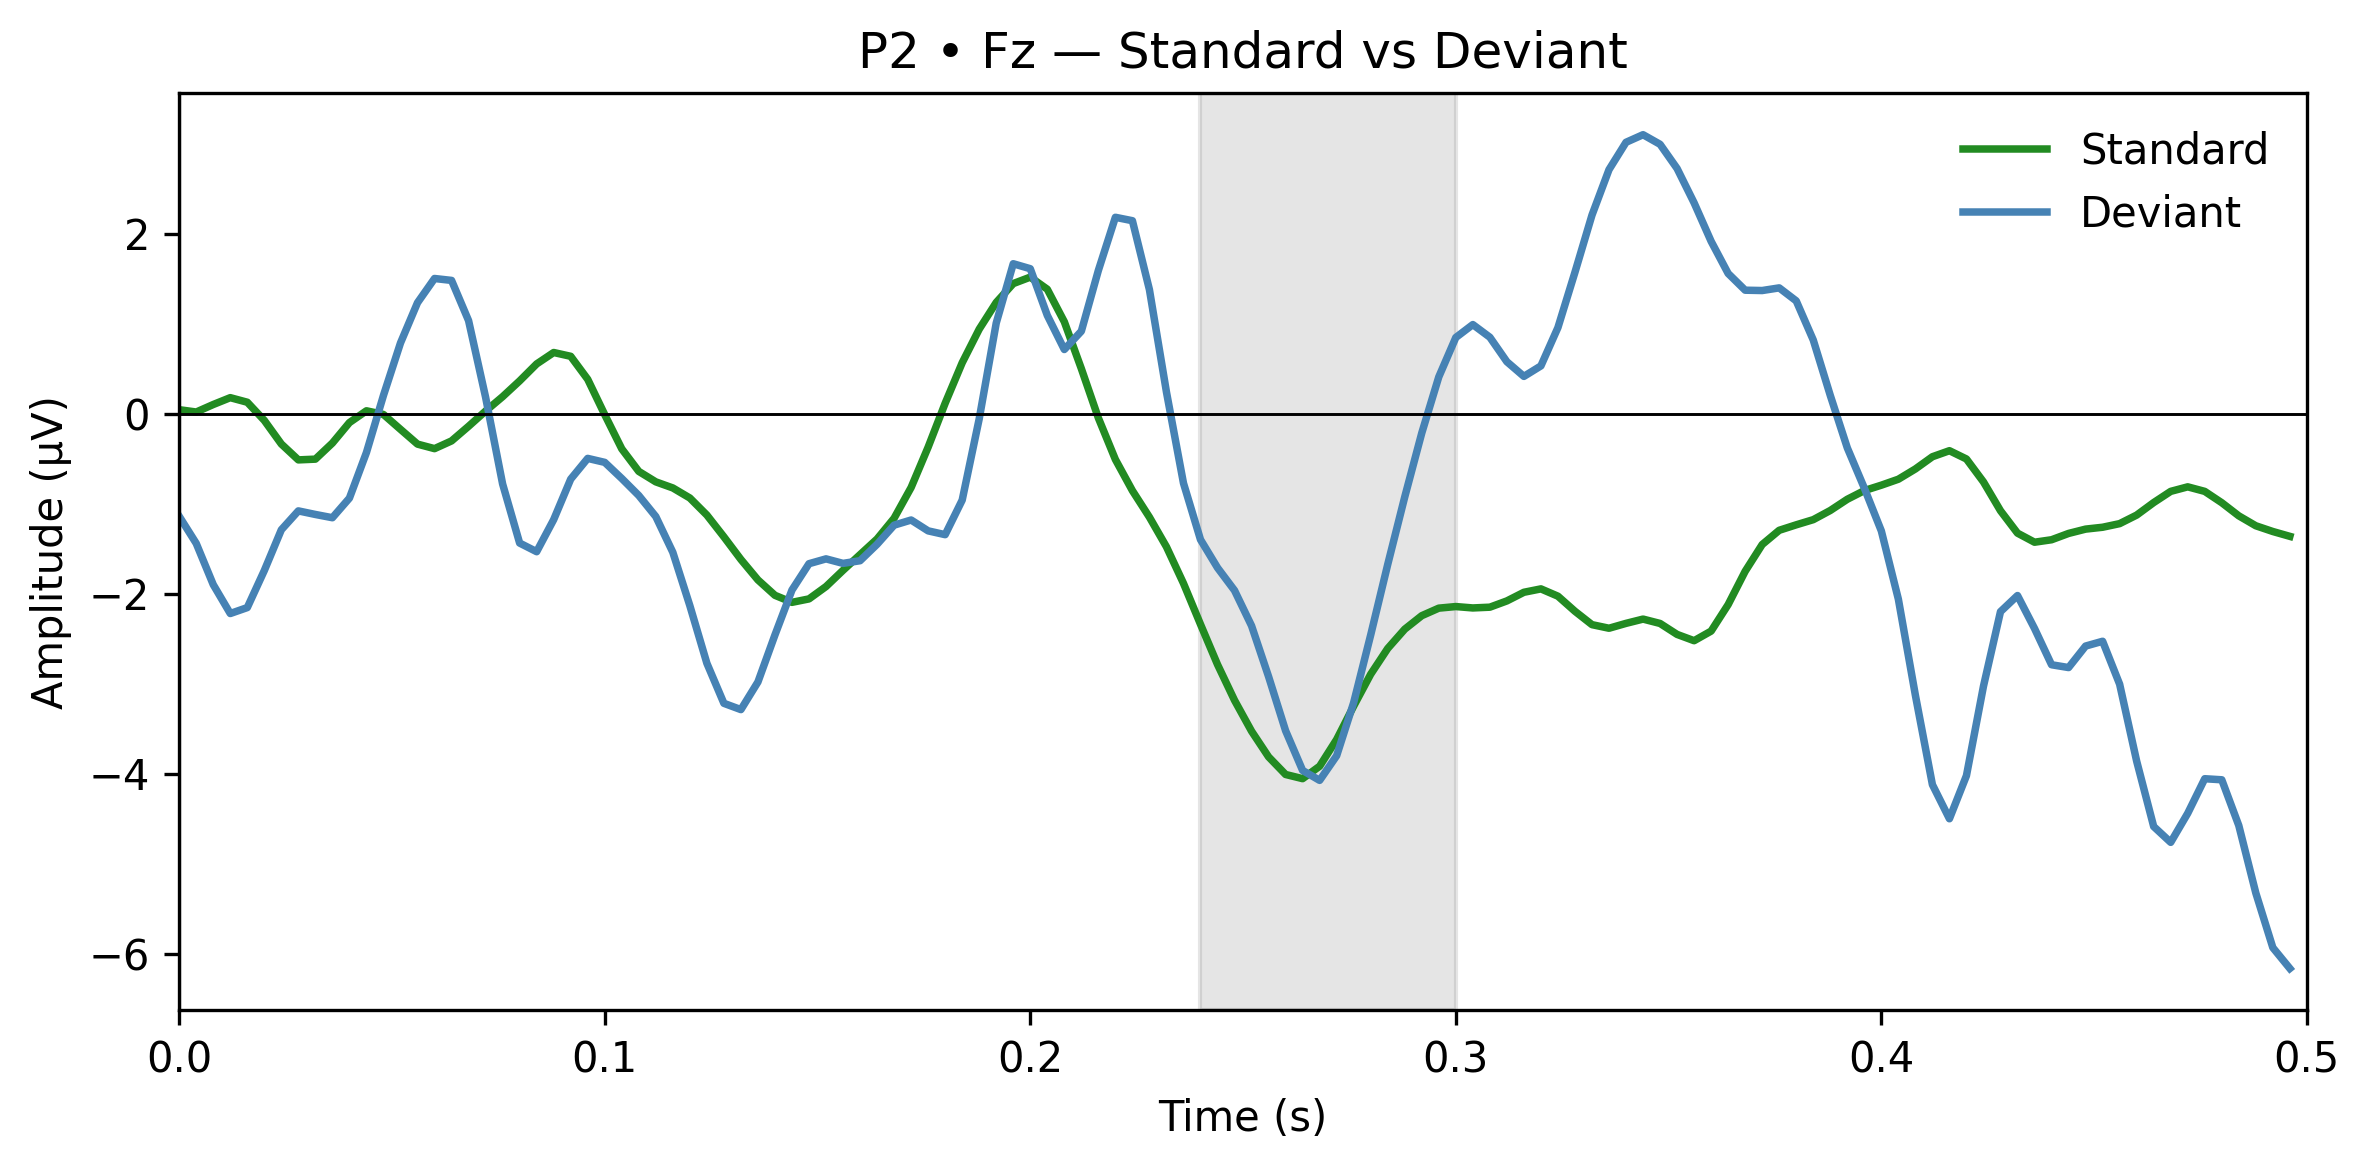

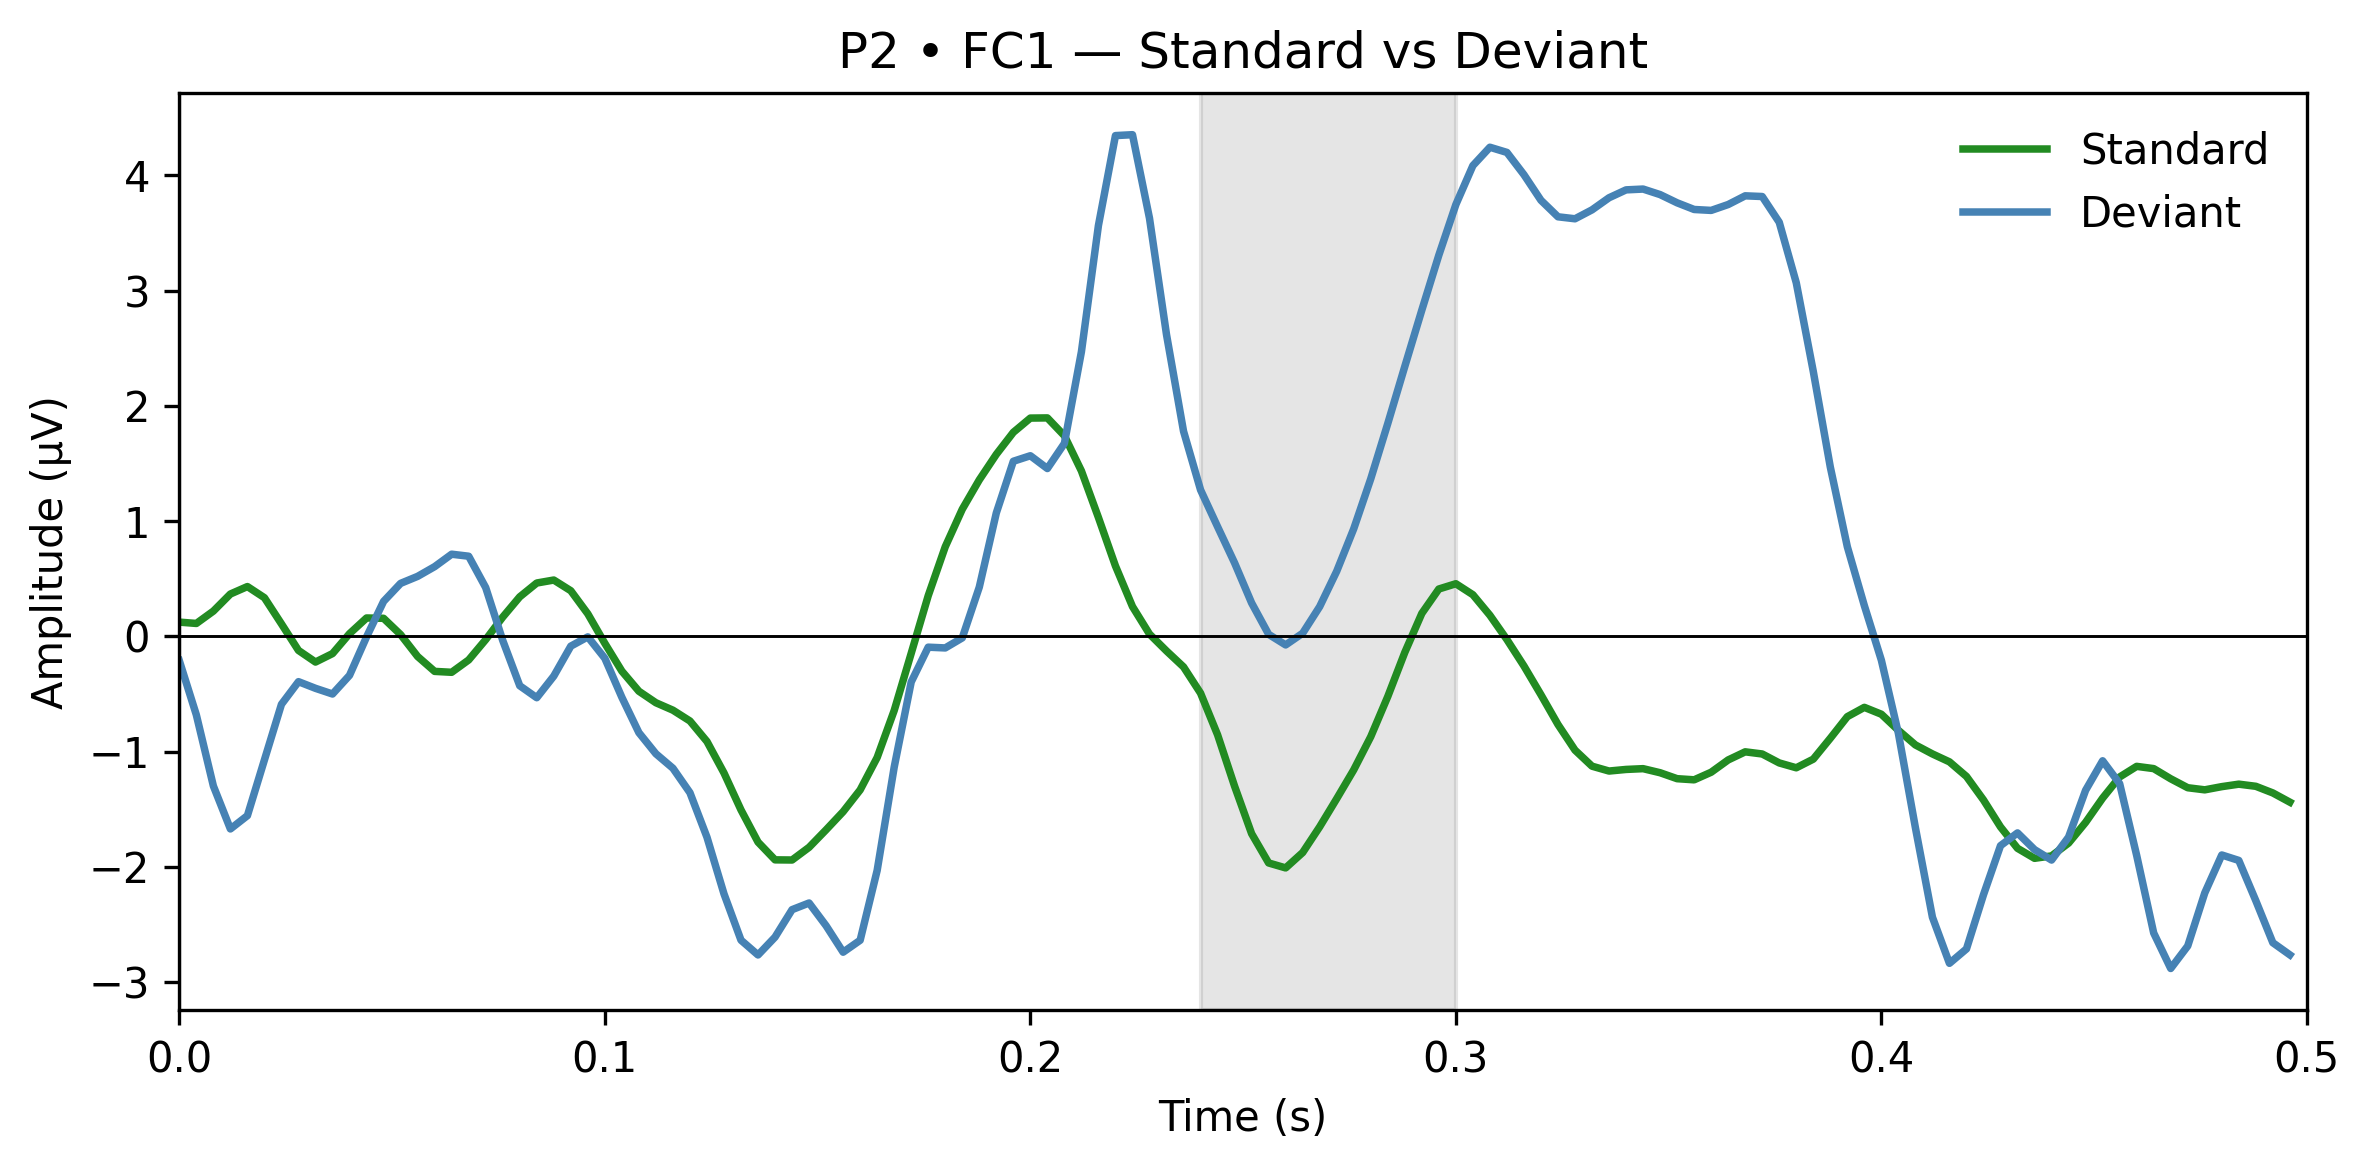

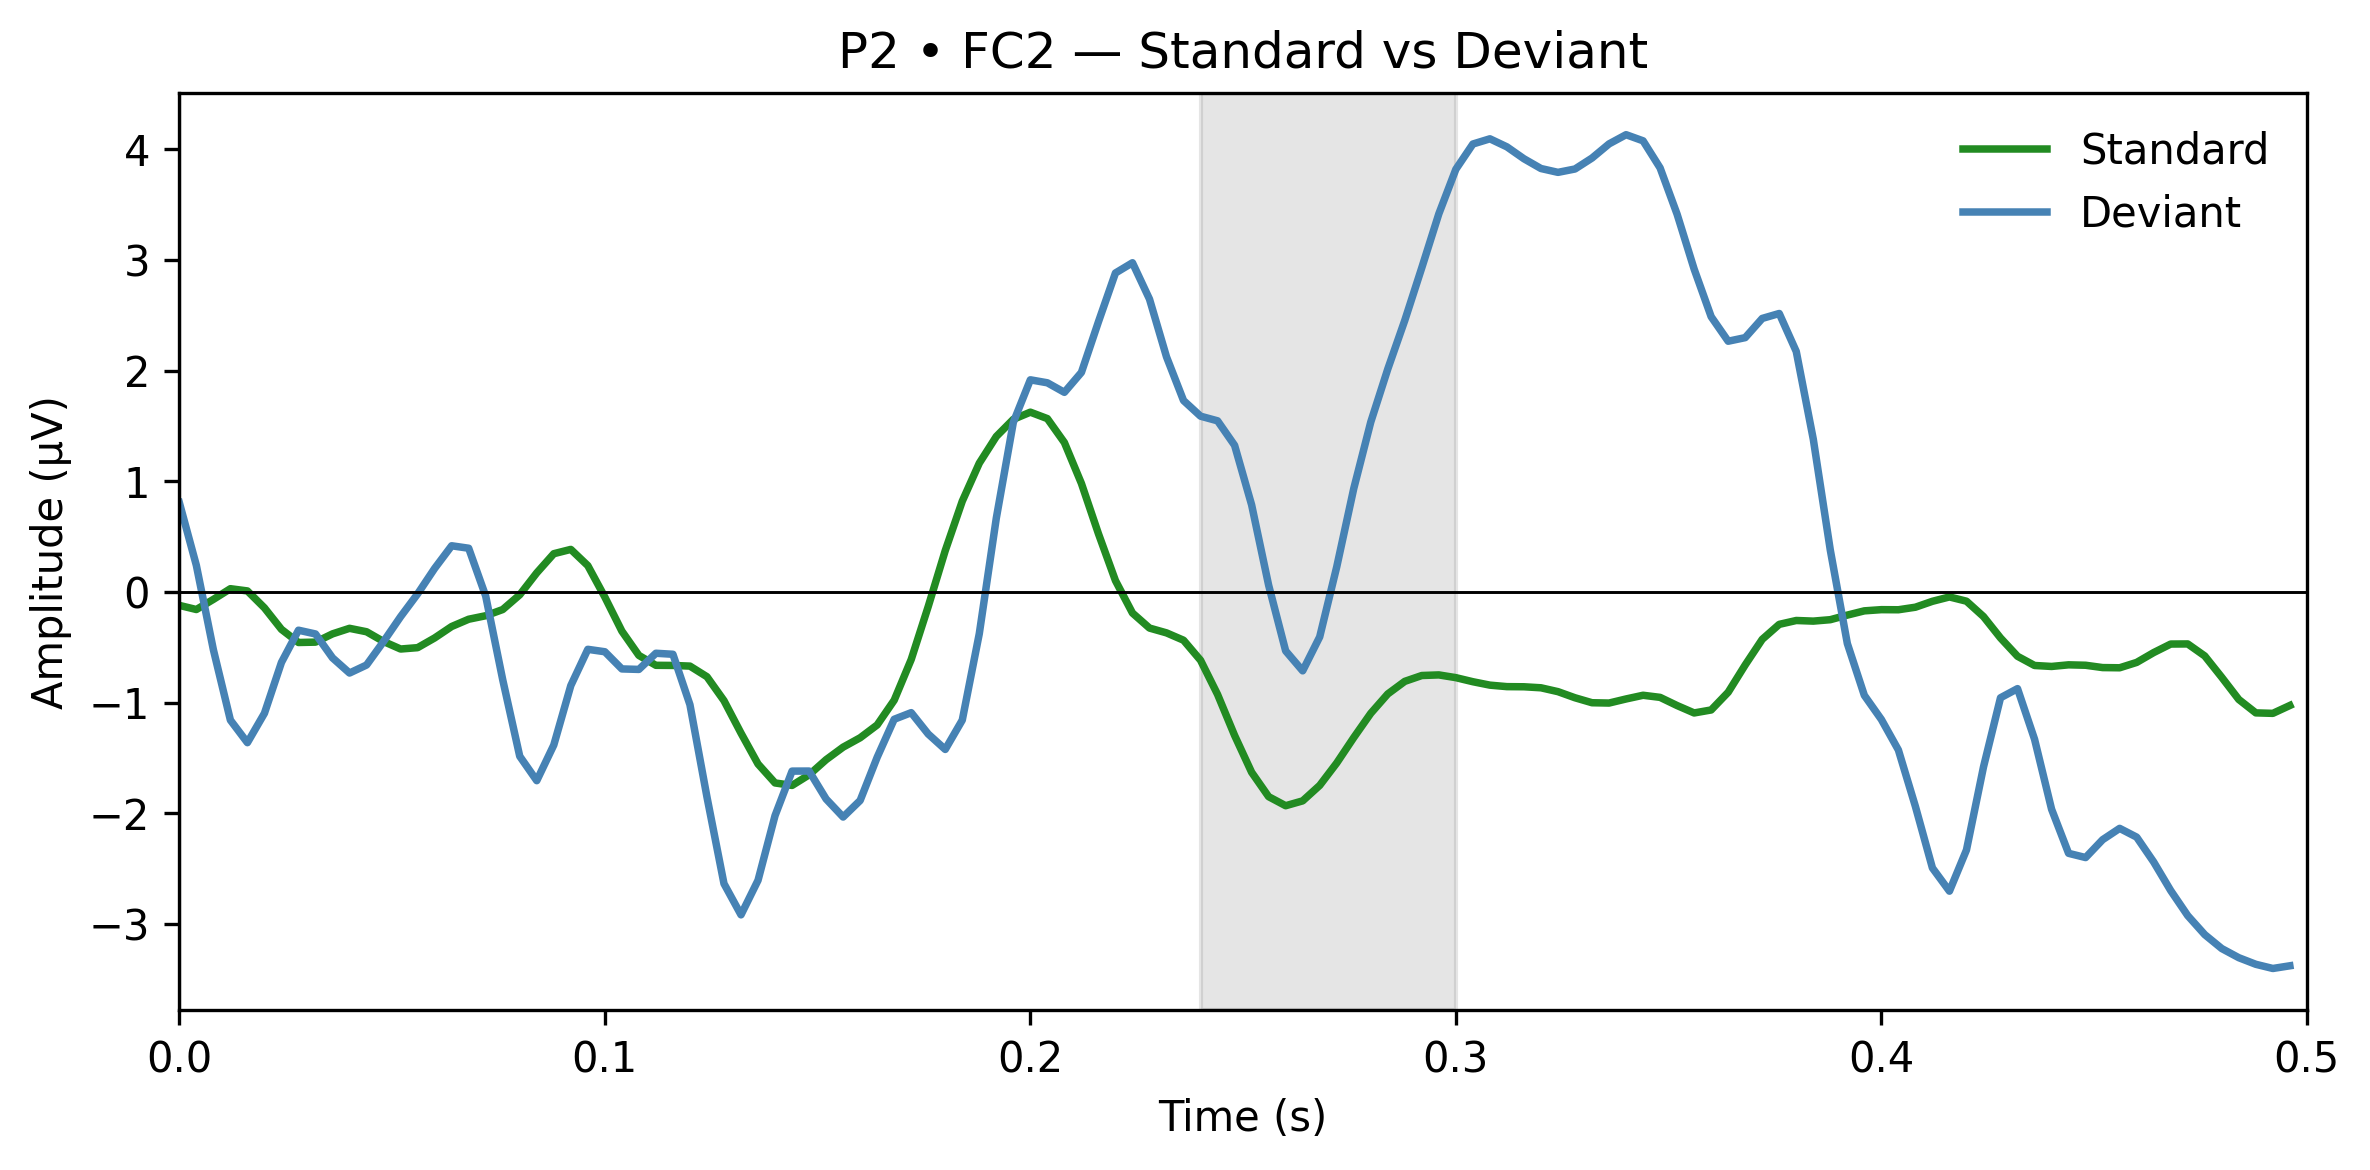

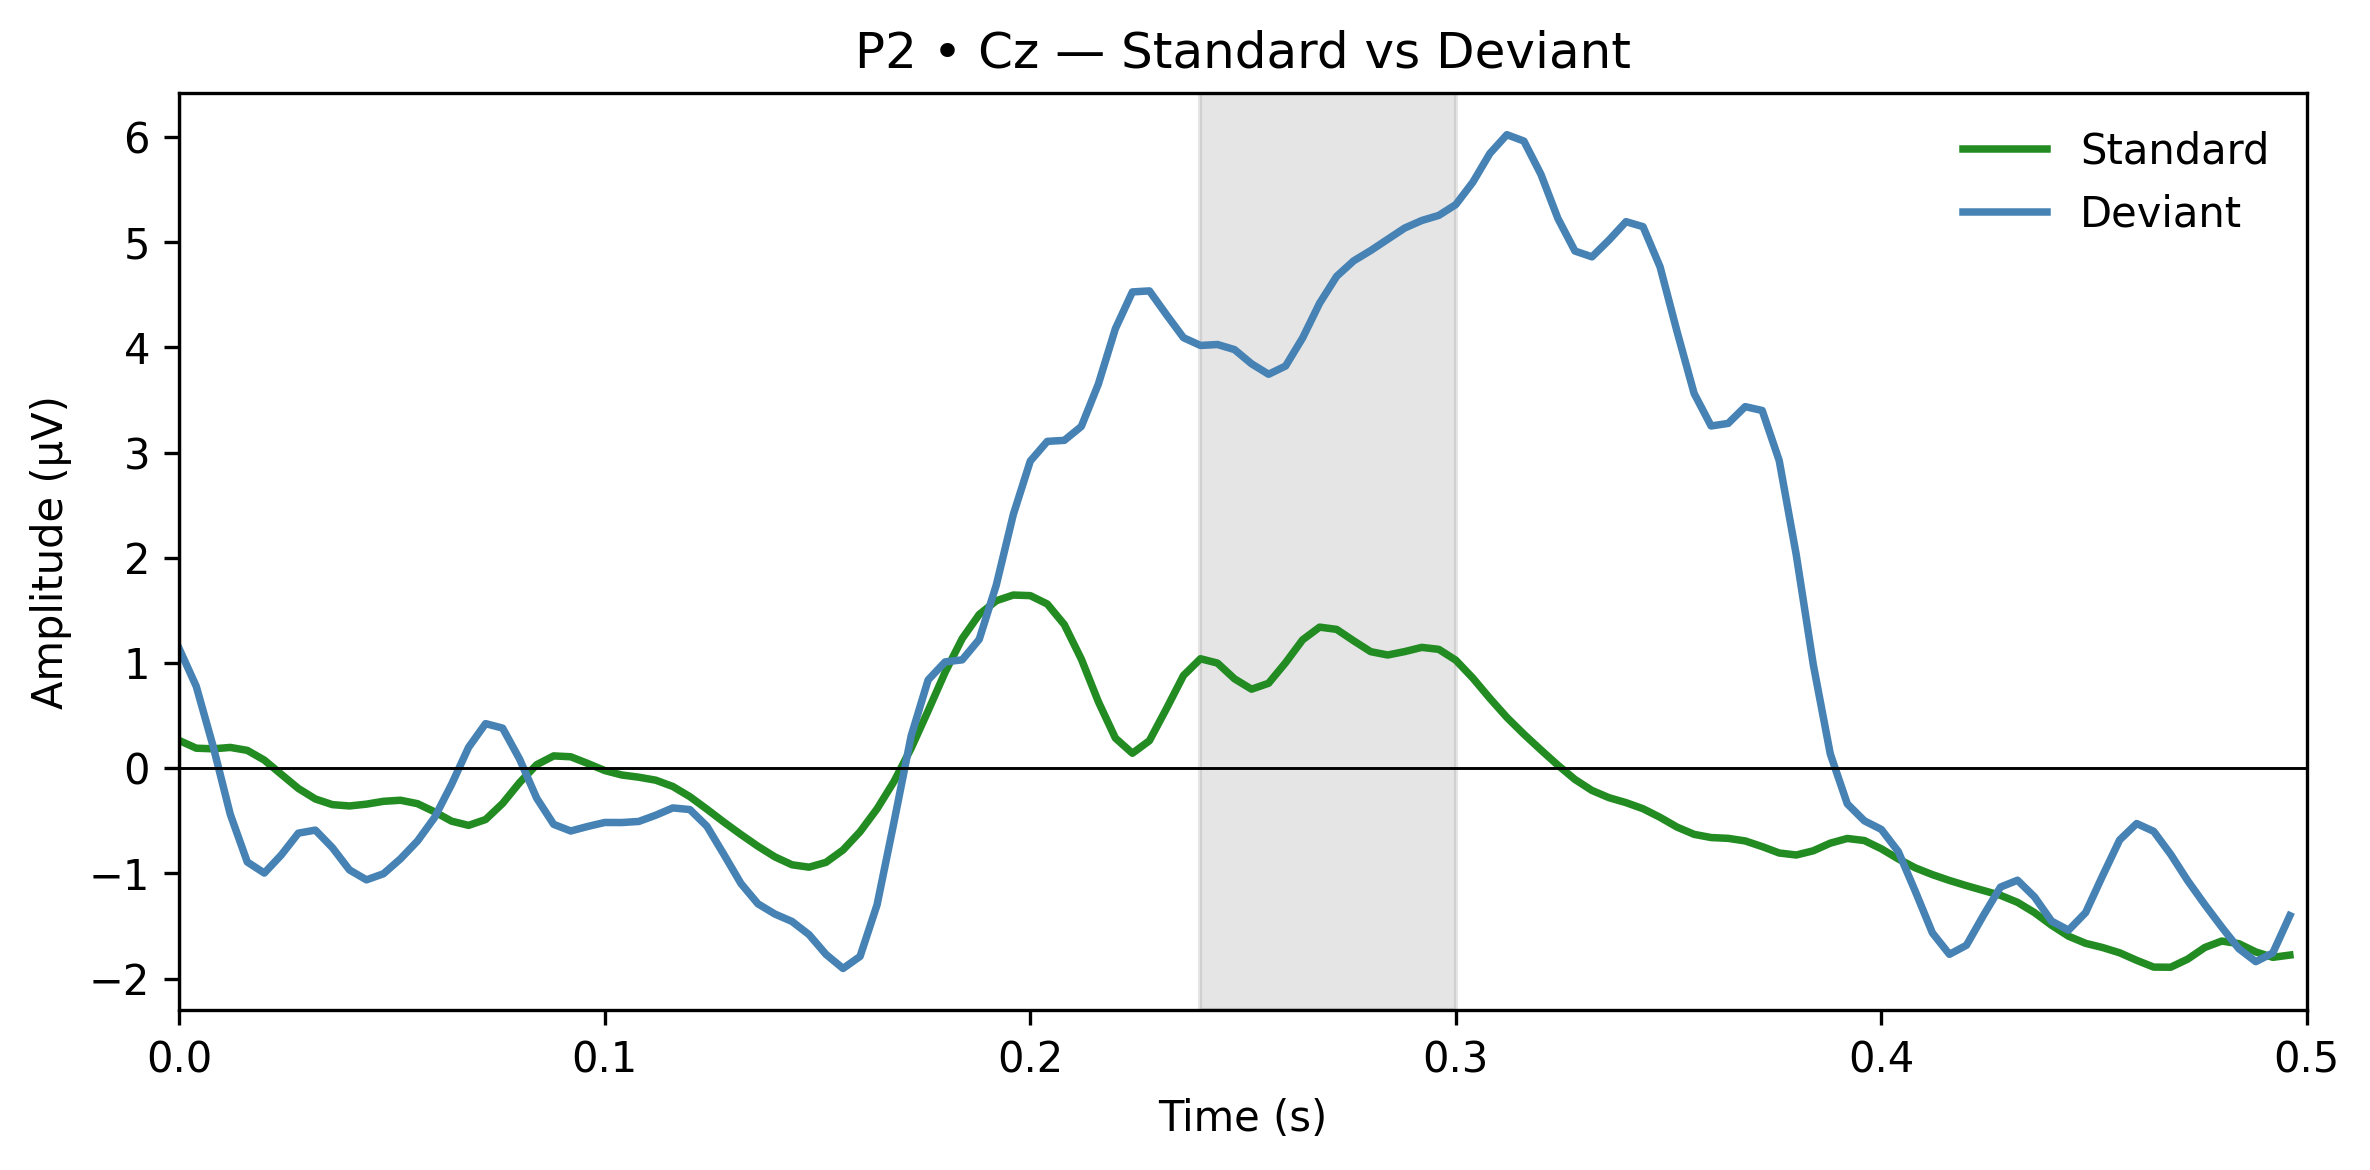

In [35]:
import numpy as np
import matplotlib.pyplot as plt

channels   = picks_n2
tmin, tmax = 0.0, 0.5
col_std, col_dev = "forestgreen", "steelblue"
lw = 1.8

for p_idx, ep in enumerate(all_epochs, start=1):
    subj = f"P{p_idx}"
    sfreq = ep.info["sfreq"]                      # sampling rate (Hz)

    for ch in channels:
        # -------- trial-averaged waveforms (µV) -----------------
        std = (ep["Normal"  ]
                 .get_data(picks=[ch], tmin=tmin, tmax=tmax)
                 .mean(axis=0).squeeze() * 1e6)
        dev = (ep["Surprise"]
                 .get_data(picks=[ch], tmin=tmin, tmax=tmax)
                 .mean(axis=0).squeeze() * 1e6)

        # build matching time axis from length of the returned arrays
        n_samp = std.size
        times  = tmin + np.arange(n_samp) / sfreq   # seconds

        # -------- plot -----------------------------------------
        fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
        ax.plot(times, std, color=col_std, lw=lw, label="Standard")
        ax.plot(times, dev, color=col_dev, lw=lw, label="Deviant")

        ax.axvspan(0.240, 0.300, color="grey", alpha=0.2, zorder=-1)   # P3 window


        ax.axvline(0, color="black", lw=1)
        ax.axhline(0, color="black", lw=0.7)
        ax.set(
            xlim=(tmin, tmax),
            xlabel="Time (s)",
            ylabel="Amplitude (µV)",
            title=f"{subj} • {ch} — Standard vs Deviant",
        )
        ax.legend(frameon=False)
        fig.tight_layout()
        plt.show()       # or fig.savefig(f"{subj}_{ch}_std_dev.png", dpi=300)


### Non averaged plot

In [16]:
# Initialize lists to store each participant's data
normal_participants = []  # Will become shape [n_participants, n_timepoints]
surprise_participants = []

for epochs in all_epochs:  # Loop over each participant's Epochs
    # Extract conditions for this participant
    epochs_normal = epochs["Normal"]
    epochs_surprise = epochs["Surprise"]
    
    # Get data (average across trials but keep channels & time)
    data_normal = epochs_normal.get_data(picks=picks_np, tmin=None, tmax=None)  # Keep all timepoints
    data_surprise = epochs_surprise.get_data(picks=picks_np, tmin=None, tmax=None)
    
    # Average across trials and channels (but keep time)
    normal_participants.append(np.mean(data_normal, axis=(0, 1)))  # Shape: [n_timepoints]
    surprise_participants.append(np.mean(data_surprise, axis=(0, 1)))

# Convert to arrays
normal_participants = np.array(normal_participants)  # Shape: [n_participants, n_timepoints]
surprise_participants = np.array(surprise_participants)

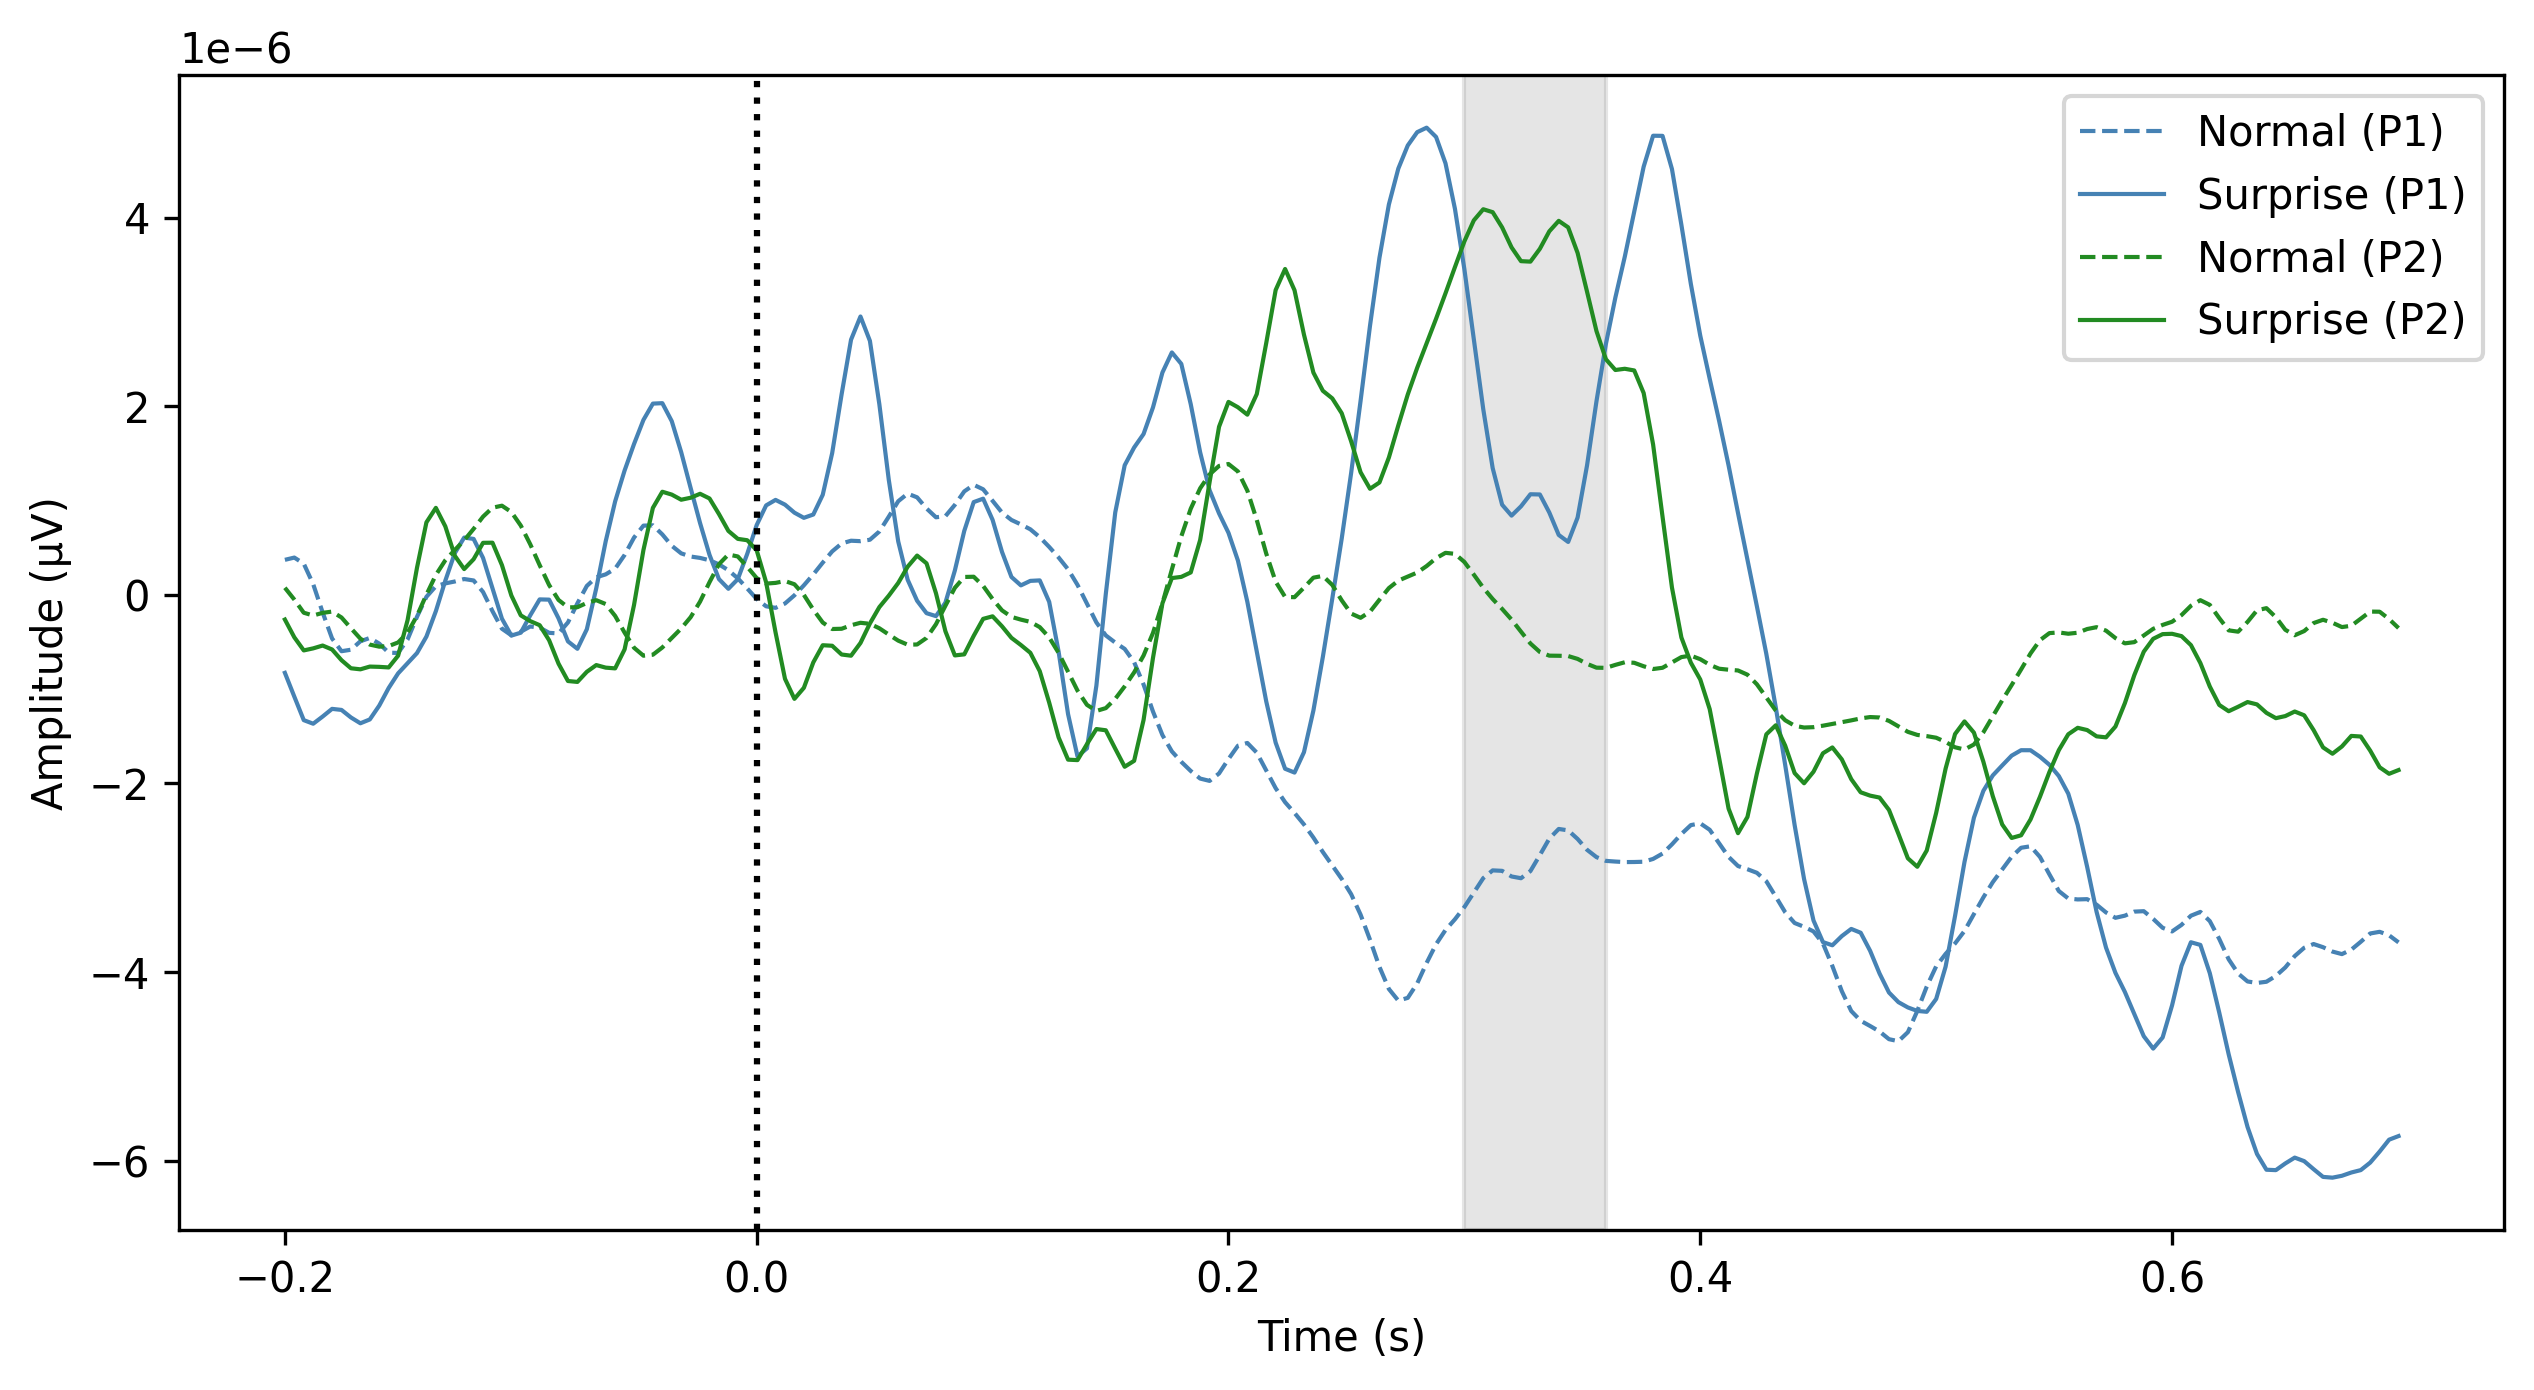

In [17]:
colours = ["steelblue", "forestgreen"]  # Colors for each participant
times = all_epochs[0].times  # Time axis

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)  # Highlight your time window

# Plot each participant's data
for i in range(len(normal_participants)):
    color = colours[i % len(colours)]
    ax.plot(times, normal_participants[i], 
            label=f"Normal (P{i+1})", 
            color=color, linestyle="--", linewidth=1)
    ax.plot(times, surprise_participants[i], 
            label=f"Surprise (P{i+1})", 
            color=color, linestyle="-", linewidth=1)

ax.axvline(0, color="black", linestyle=":")  # Mark time-zero
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (µV)")
ax.legend()
plt.show()

## VMMN Group Level

In [18]:
tmin = 0.1
tmax = 0.25
picks_vmmn = ["Oz", "O1", "O2"]

In [19]:
# code for group-level windowed mean
# prep data for plotting
normal = np.array([])
surprise = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_normal = epochs["Normal"]
    epochs_surprise = epochs["Surprise"]

    # extract the data for the time window and channels of interest
    data_normal = epochs_normal.get_data(picks = picks_vmmn, tmin = tmin, tmax = tmax)
    data_surprise = epochs_surprise.get_data(picks = picks_vmmn, tmin = tmin, tmax = tmax)

    # calculate the mean over the channel and trial dimension (axis 1 and 2)
    # we keep the time dimension (axis 0) to plot the time course
    data_normal_mean = np.mean(data_normal, axis=(0, 1))
    data_surprise_mean = np.mean(data_surprise, axis=(0, 1))
    print(data_normal_mean.shape)

    # append the data to the arrays
    normal = np.concatenate((normal, data_normal_mean), axis=0)
    surprise = np.concatenate((surprise, data_surprise_mean), axis=0)

print(normal.shape)
print(surprise.shape)

# Average over trials & channels (keep time dimension)
normal_mean = np.mean(data_normal, axis=(0, 1))  # shape: [n_timepoints]
surprise_mean = np.mean(data_surprise, axis=(0, 1))

print(normal_mean.shape)
print(surprise_mean.shape)


(37,)
(37,)
(74,)
(74,)
(37,)
(37,)


### T-test

In [20]:
from scipy import stats

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(normal_mean, surprise_mean)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -0.21295248516351503, P-value: 0.8319658231764628


### Plot Averaged

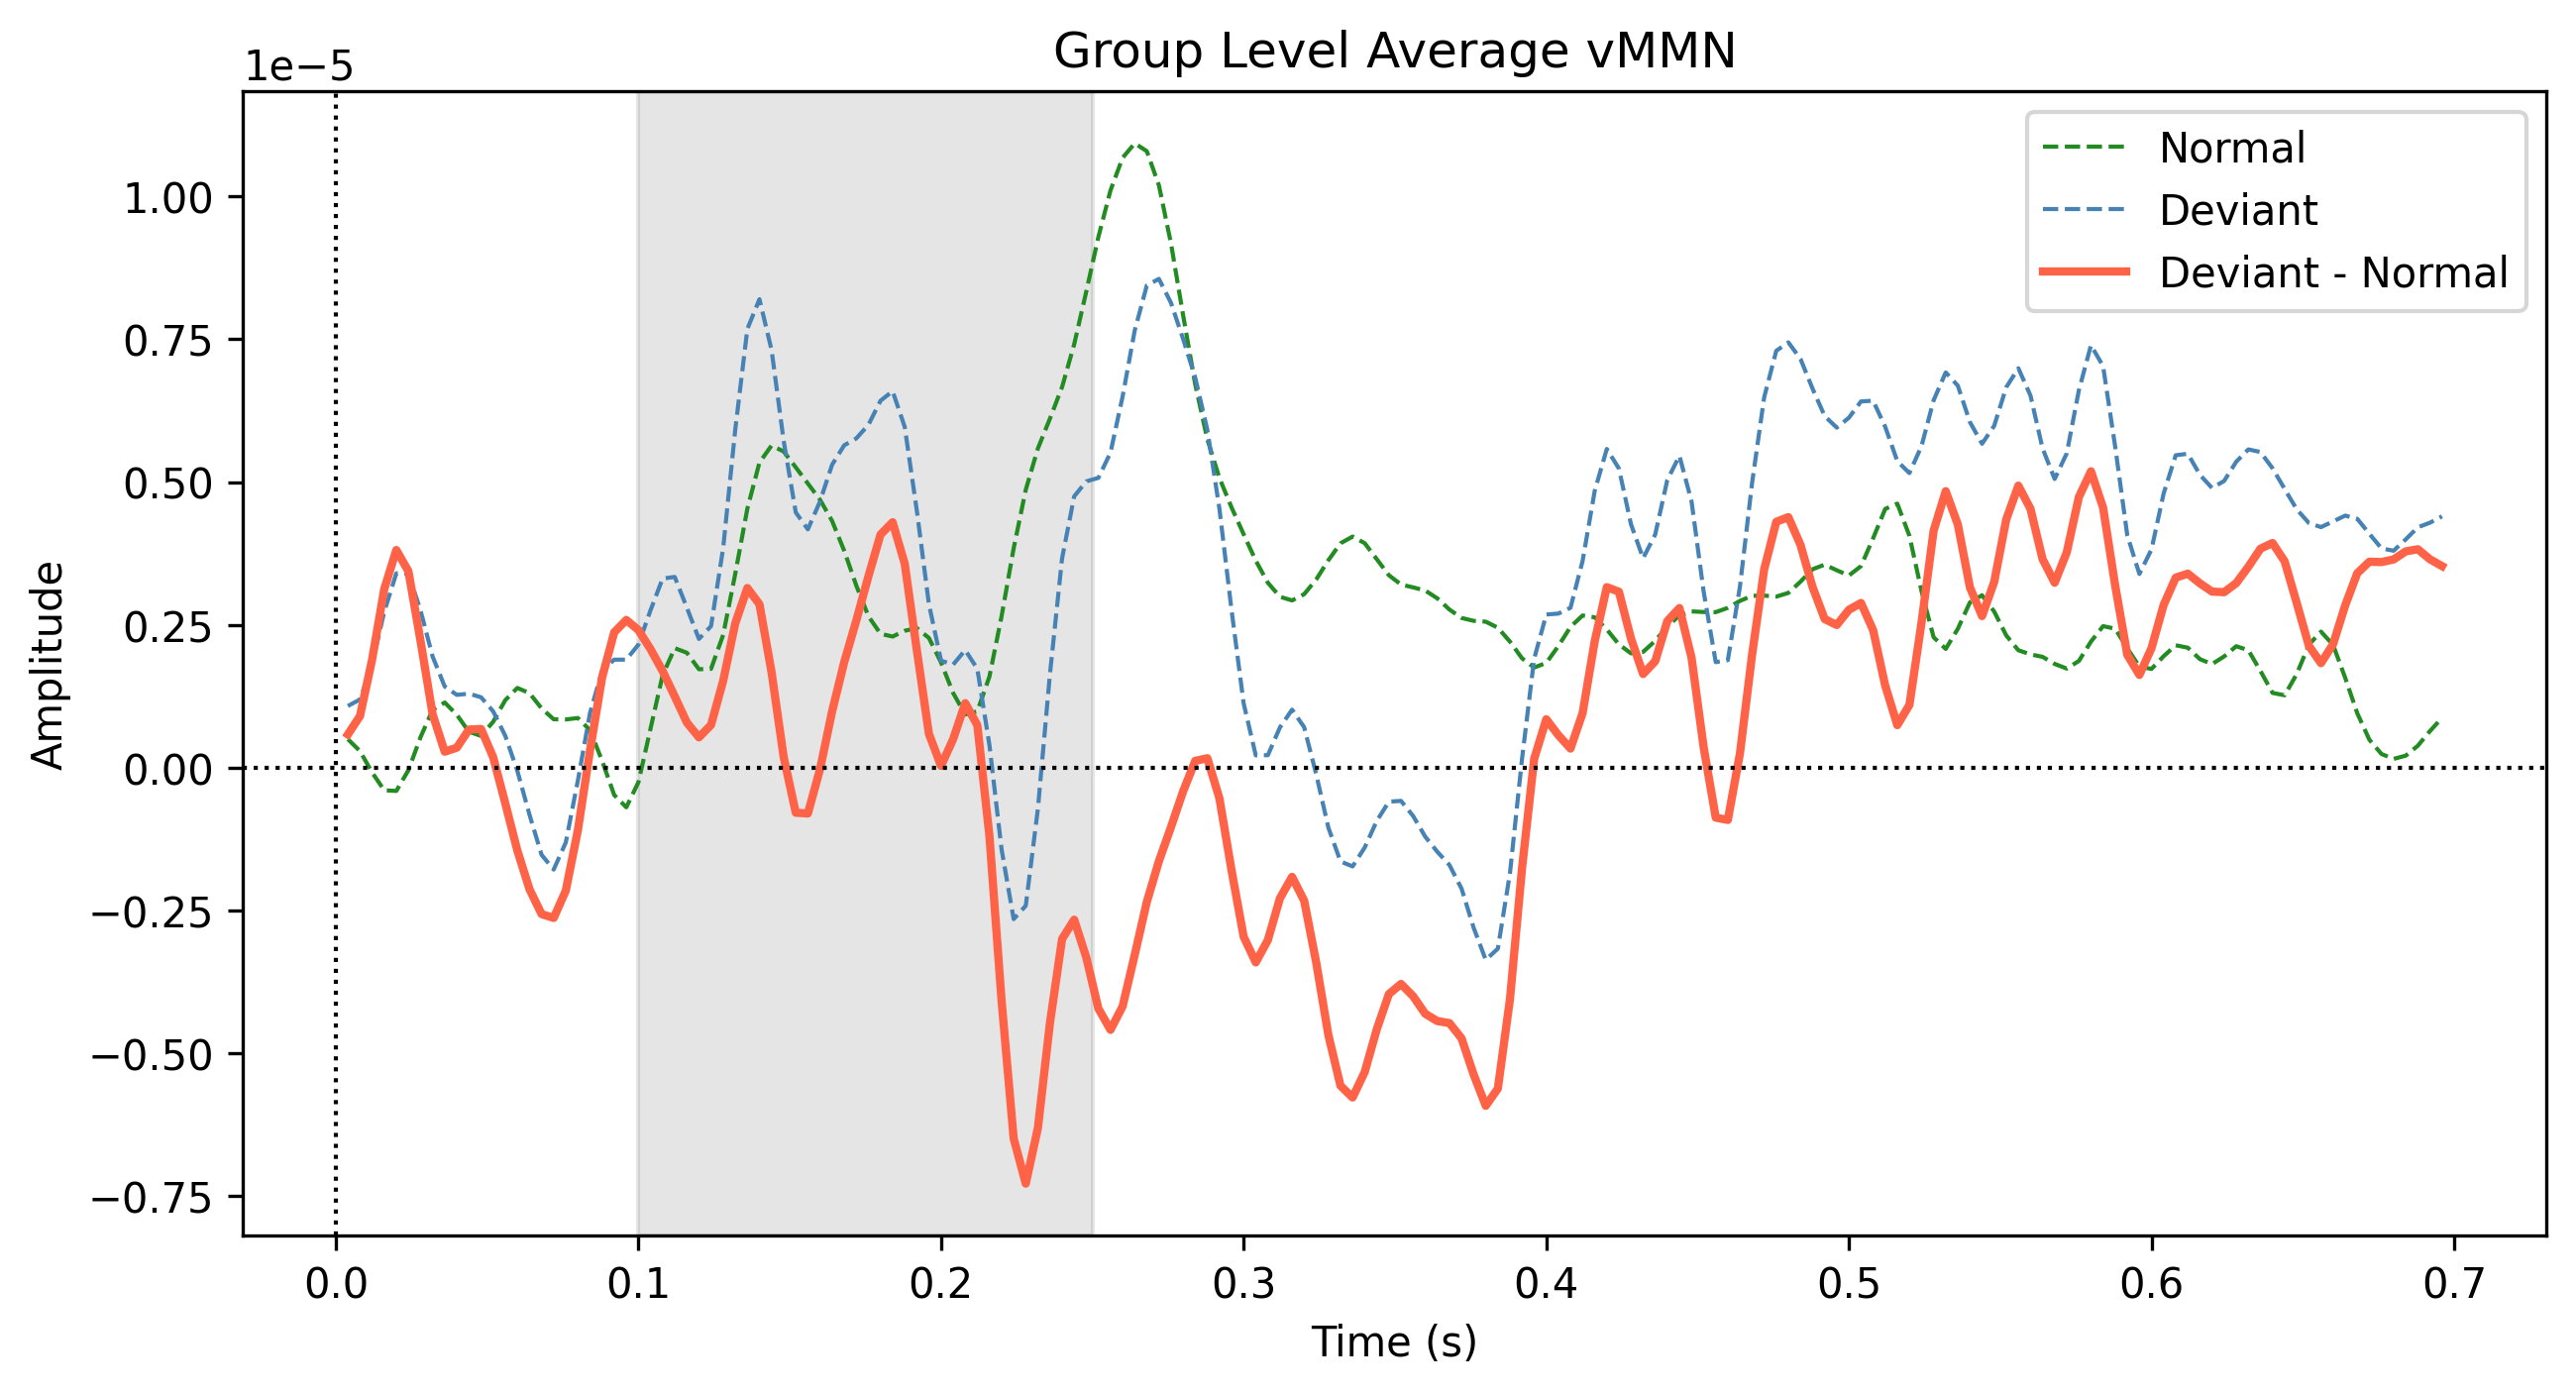

In [22]:
plot_data1 = epochs_normal.get_data(picks=picks_vmmn, tmin=0.0, tmax=0.7, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data2 = epochs_surprise.get_data(picks=picks_vmmn, tmin=0.0, tmax=0.7, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
plot_data3 = plot_data2 - plot_data1

# plotting averaged timecourses for each participant
times = epochs_t.times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

ax.plot(times, plot_data1, label="Normal", color='forestgreen', linestyle="--", linewidth=1)
ax.plot(times, plot_data2, label= "Deviant", color='steelblue', linestyle="--", linewidth=1)
ax.plot(times, plot_data3, label= "Deviant - Normal", color='tomato', linestyle="-", linewidth=2)

ax.axvline(0, color="black", linestyle=":", linewidth=1)
ax.axhline(0, color="black", linestyle=":", linewidth=1)
ax.set(xlabel="Time (s)", ylabel="Amplitude", title="Group Level Average vMMN")
ax.legend(loc = "upper right")

ax.legend()
plt.show()

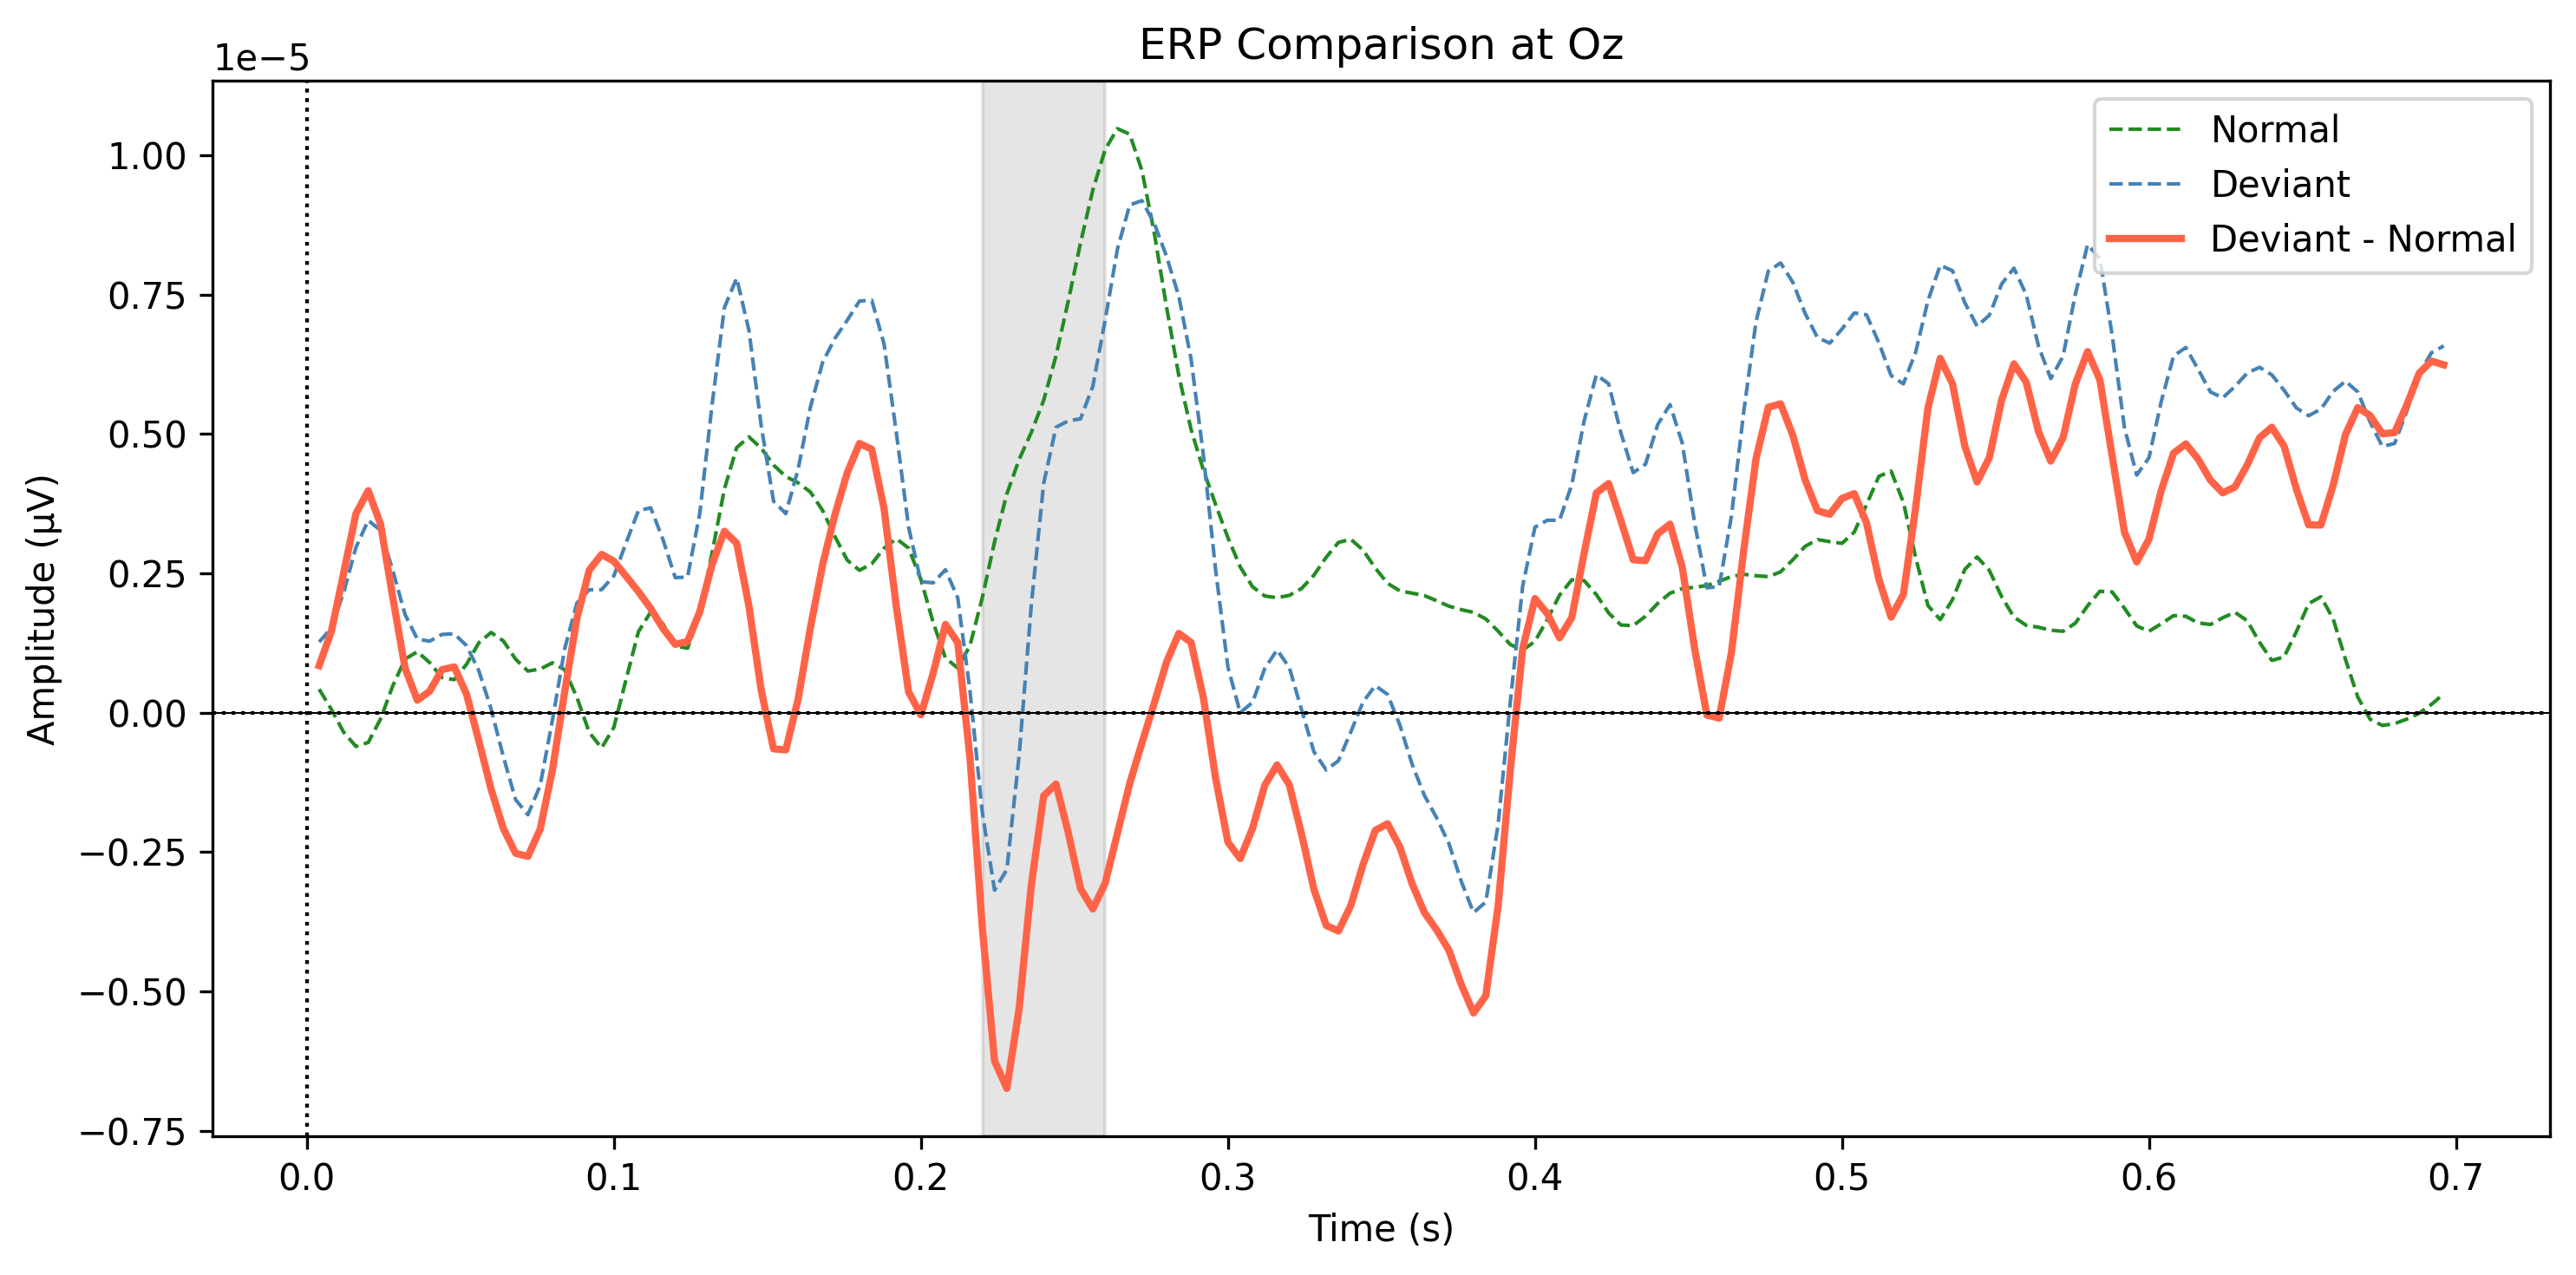

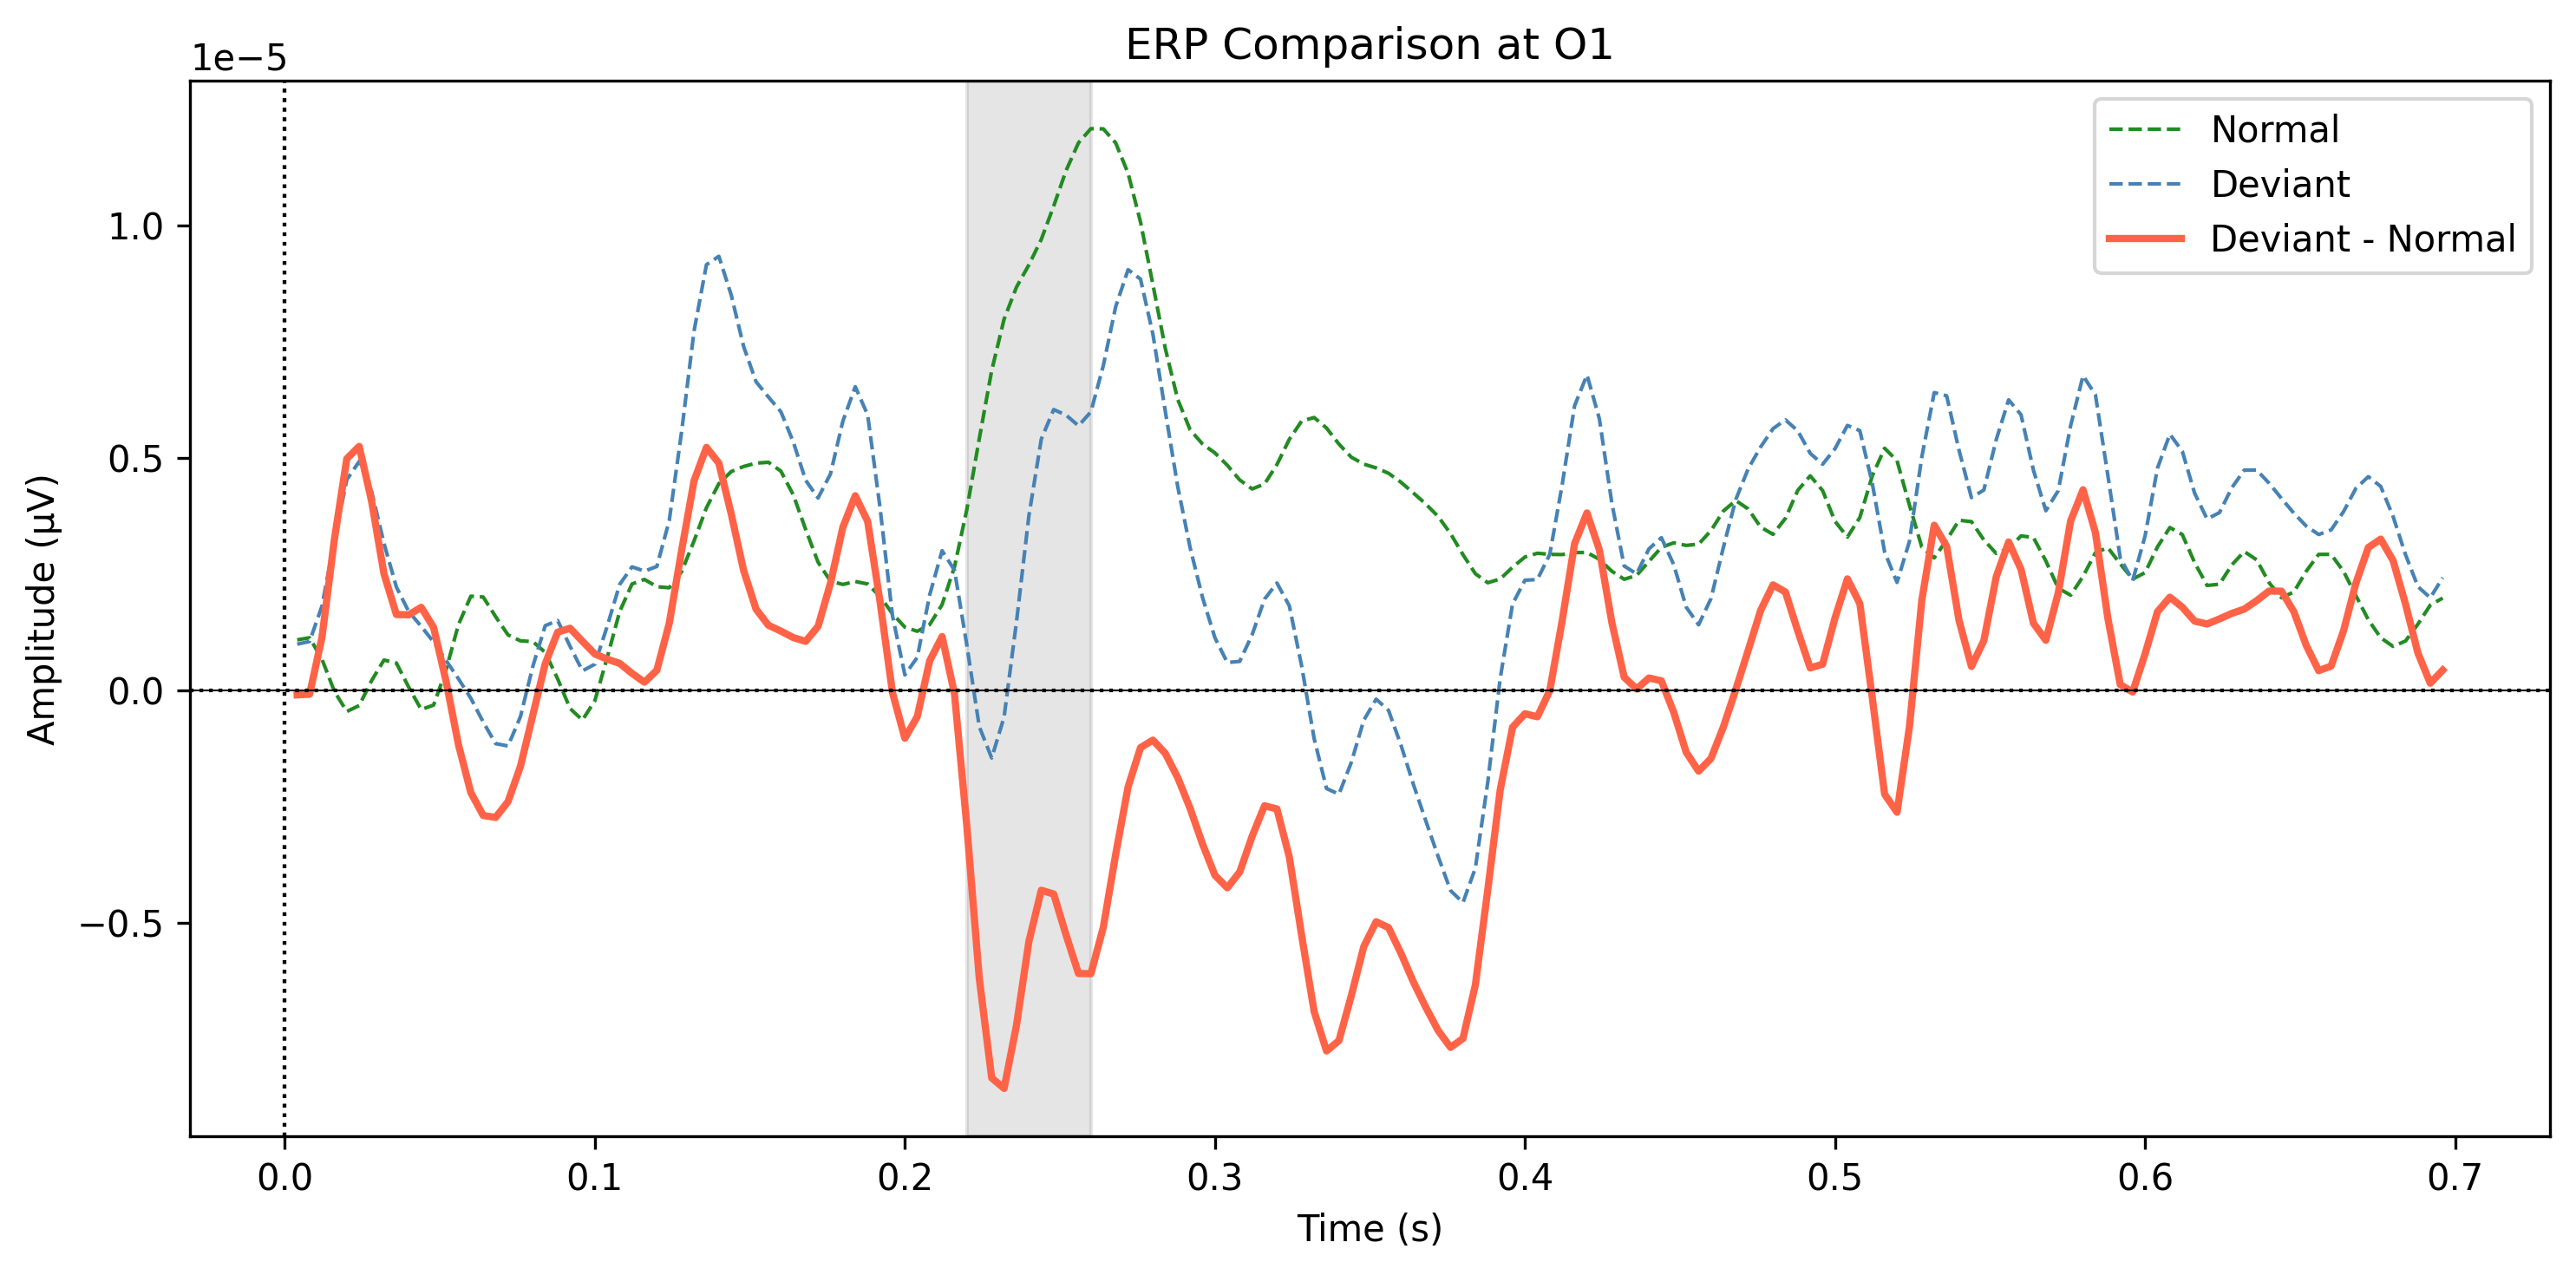

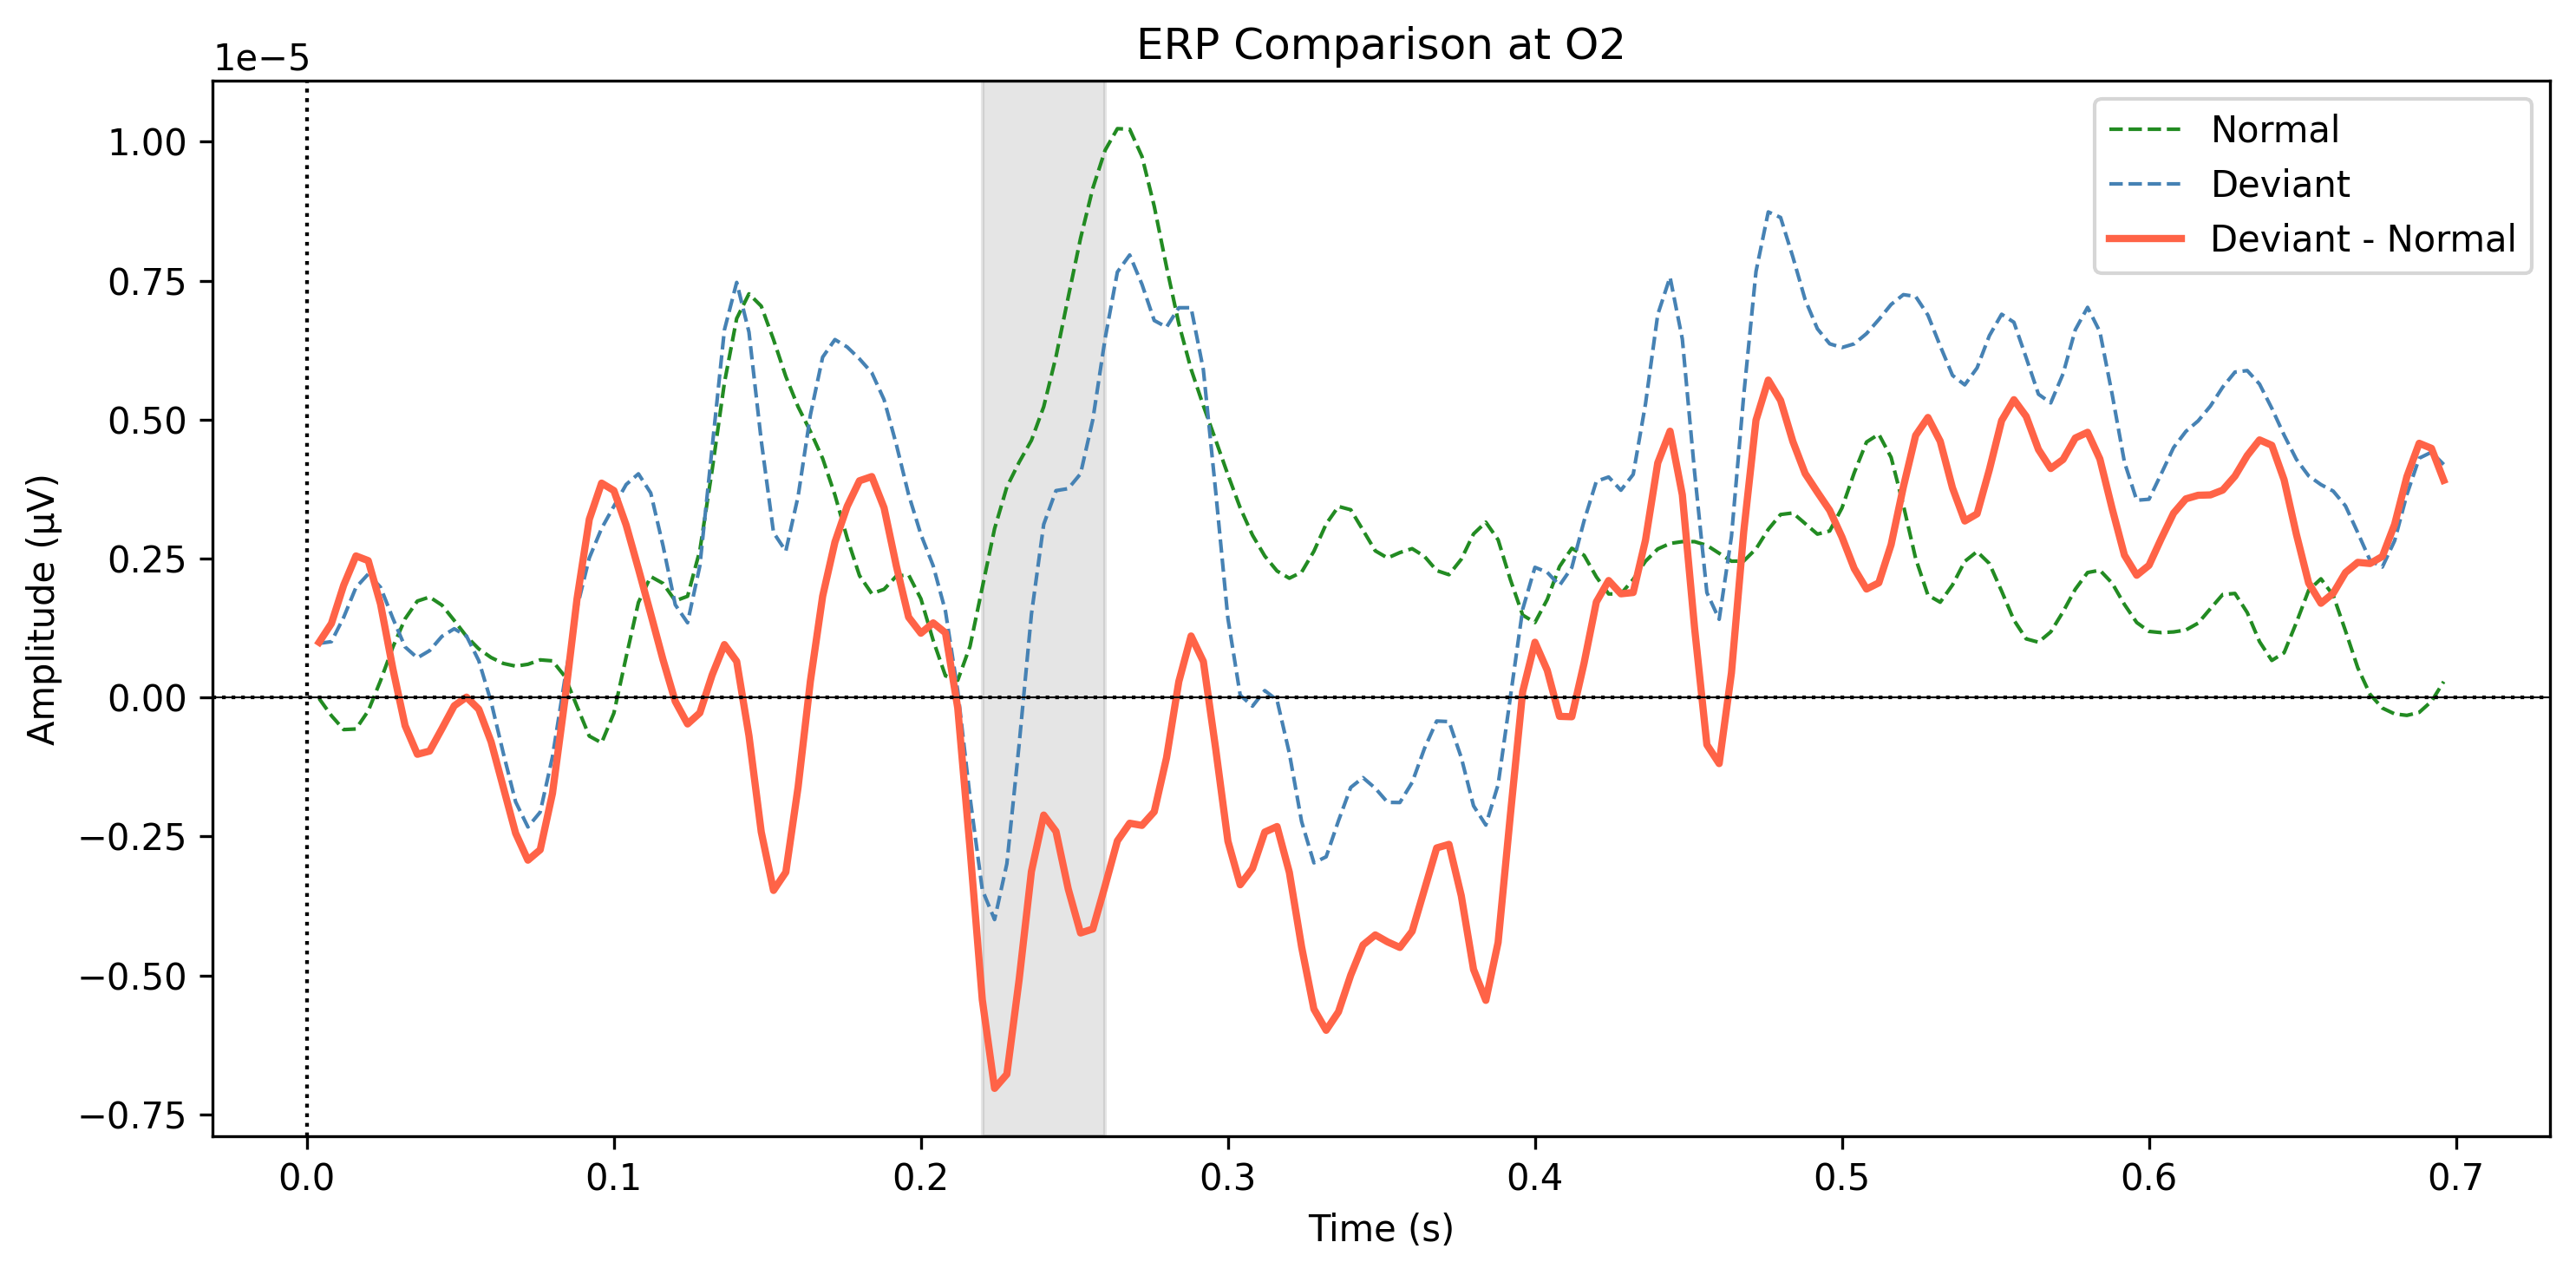

In [24]:
# Loop over each channel
for channel in picks_vmmn:

    
    plot_data1 = epochs_normal.get_data(picks=[channel], tmin=0.0, tmax=0.7, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
    plot_data2 = epochs_surprise.get_data(picks=[channel], tmin=0.0, tmax=0.7, copy = True).mean(axis=(0, 1)) # mean over channels and trials 
    plot_data3 = plot_data2 - plot_data1

    # plotting averaged timecourses for each participant
    times = epochs_t.times

    fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

    # plot the time window
    ax.axvspan(0.22, 0.26, color="grey", alpha=0.2)

    ax.plot(times, plot_data1, label="Normal", color='forestgreen', linestyle="--", linewidth=1)
    ax.plot(times, plot_data2, label= "Deviant", color='steelblue', linestyle="--", linewidth=1)
    ax.plot(times, plot_data3, label= "Deviant - Normal", color='tomato', linestyle="-", linewidth=2)

    ax.axvline(0, color="black", linestyle=":", linewidth=1)
    ax.axhline(0, color="black", linestyle=":", linewidth=1)
    ax.set(xlabel="Time (s)", ylabel="Amplitude", title="Group Level Average vMMN")
    ax.legend(loc = "upper right")
    
    # Mark t=0 and y=0
    ax.axvline(0, color="black", linestyle=":", linewidth=1)
    ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
    
    # Labels and title
    ax.set(
        xlabel="Time (s)", 
        ylabel="Amplitude (µV)", 
        title=f"ERP Comparison at {channel}"
    )
    ax.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

# Finding Time Windows

In [25]:
import numpy as np

# ------------------------------------------------------------------
# 0)  channel groups & search windows (seconds)
# ------------------------------------------------------------------
windows = {
    "vMMN": dict(picks=picks_vmmn, tmin=0.150, tmax=0.300),   # 150–300 ms
    "N2b":  dict(picks=picks_n2,   tmin=0.220, tmax=0.300),   # 210–310 ms
    "P3a":  dict(picks=picks_p3a,  tmin=0.250, tmax=0.350),   # 280–400 ms
    "P3b":  dict(picks=picks_p3b,  tmin=0.300, tmax=0.600),   # 400–600 ms
}

# ------------------------------------------------------------------
# 1)  loop over components
# ------------------------------------------------------------------
for name, cfg in windows.items():
    picks        = cfg["picks"]
    tmin, tmax   = cfg["tmin"], cfg["tmax"]

    # -- pull data once per condition, restricted to window & channels
    s_trials = epochs["Surprise"].get_data(picks=picks, tmin=tmin, tmax=tmax)
    n_trials = epochs["Normal"  ].get_data(picks=picks, tmin=tmin, tmax=tmax)

    # -- average over trials *and* channels  → 1‑D trace (volts)
    diff_trace = (s_trials.mean(axis=(0, 1)) -
                  n_trials.mean(axis=(0, 1)))                 # Surprise – Normal

    # -- corresponding time vector
    win_mask = (epochs.times >= tmin) & (epochs.times <= tmax)
    win_times = epochs.times[win_mask]

    # -- global extrema inside the window
    idx_min = diff_trace.argmin()
    idx_max = diff_trace.argmax()

    amp_min = diff_trace[idx_min] * 1e6                       # µV
    amp_max = diff_trace[idx_max] * 1e6
    lat_min = win_times[idx_min]
    lat_max = win_times[idx_max]

    print(f"{name}:")
    print(f"    most‑negative  {amp_min:+.2f} µV at {lat_min*1e3:.1f} ms")
    print(f"    most‑positive  {amp_max:+.2f} µV at {lat_max*1e3:.1f} ms\n")


vMMN:
    most‑negative  -7.28 µV at 228.0 ms
    most‑positive  +4.30 µV at 184.0 ms

N2b:
    most‑negative  +1.51 µV at 268.0 ms
    most‑positive  +3.66 µV at 228.0 ms

P3a:
    most‑negative  +1.51 µV at 268.0 ms
    most‑positive  +5.25 µV at 344.0 ms

P3b:
    most‑negative  +0.17 µV at 360.0 ms
    most‑positive  +5.21 µV at 552.0 ms



# Butterfly Plots - Group Level

In [18]:
# Compute evoked responses by averaging epochs
normal_evoked = epochs_normal.average()
surprise_evoked = epochs_surprise.average()

In [19]:
# option A – explicit helper
difference = mne.combine_evoked(
    [surprise_evoked, normal_evoked],      # list of evokeds
    weights=[ 1, -1 ]                      # +1 × surprise  –1 × normal
)

### All of them!

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


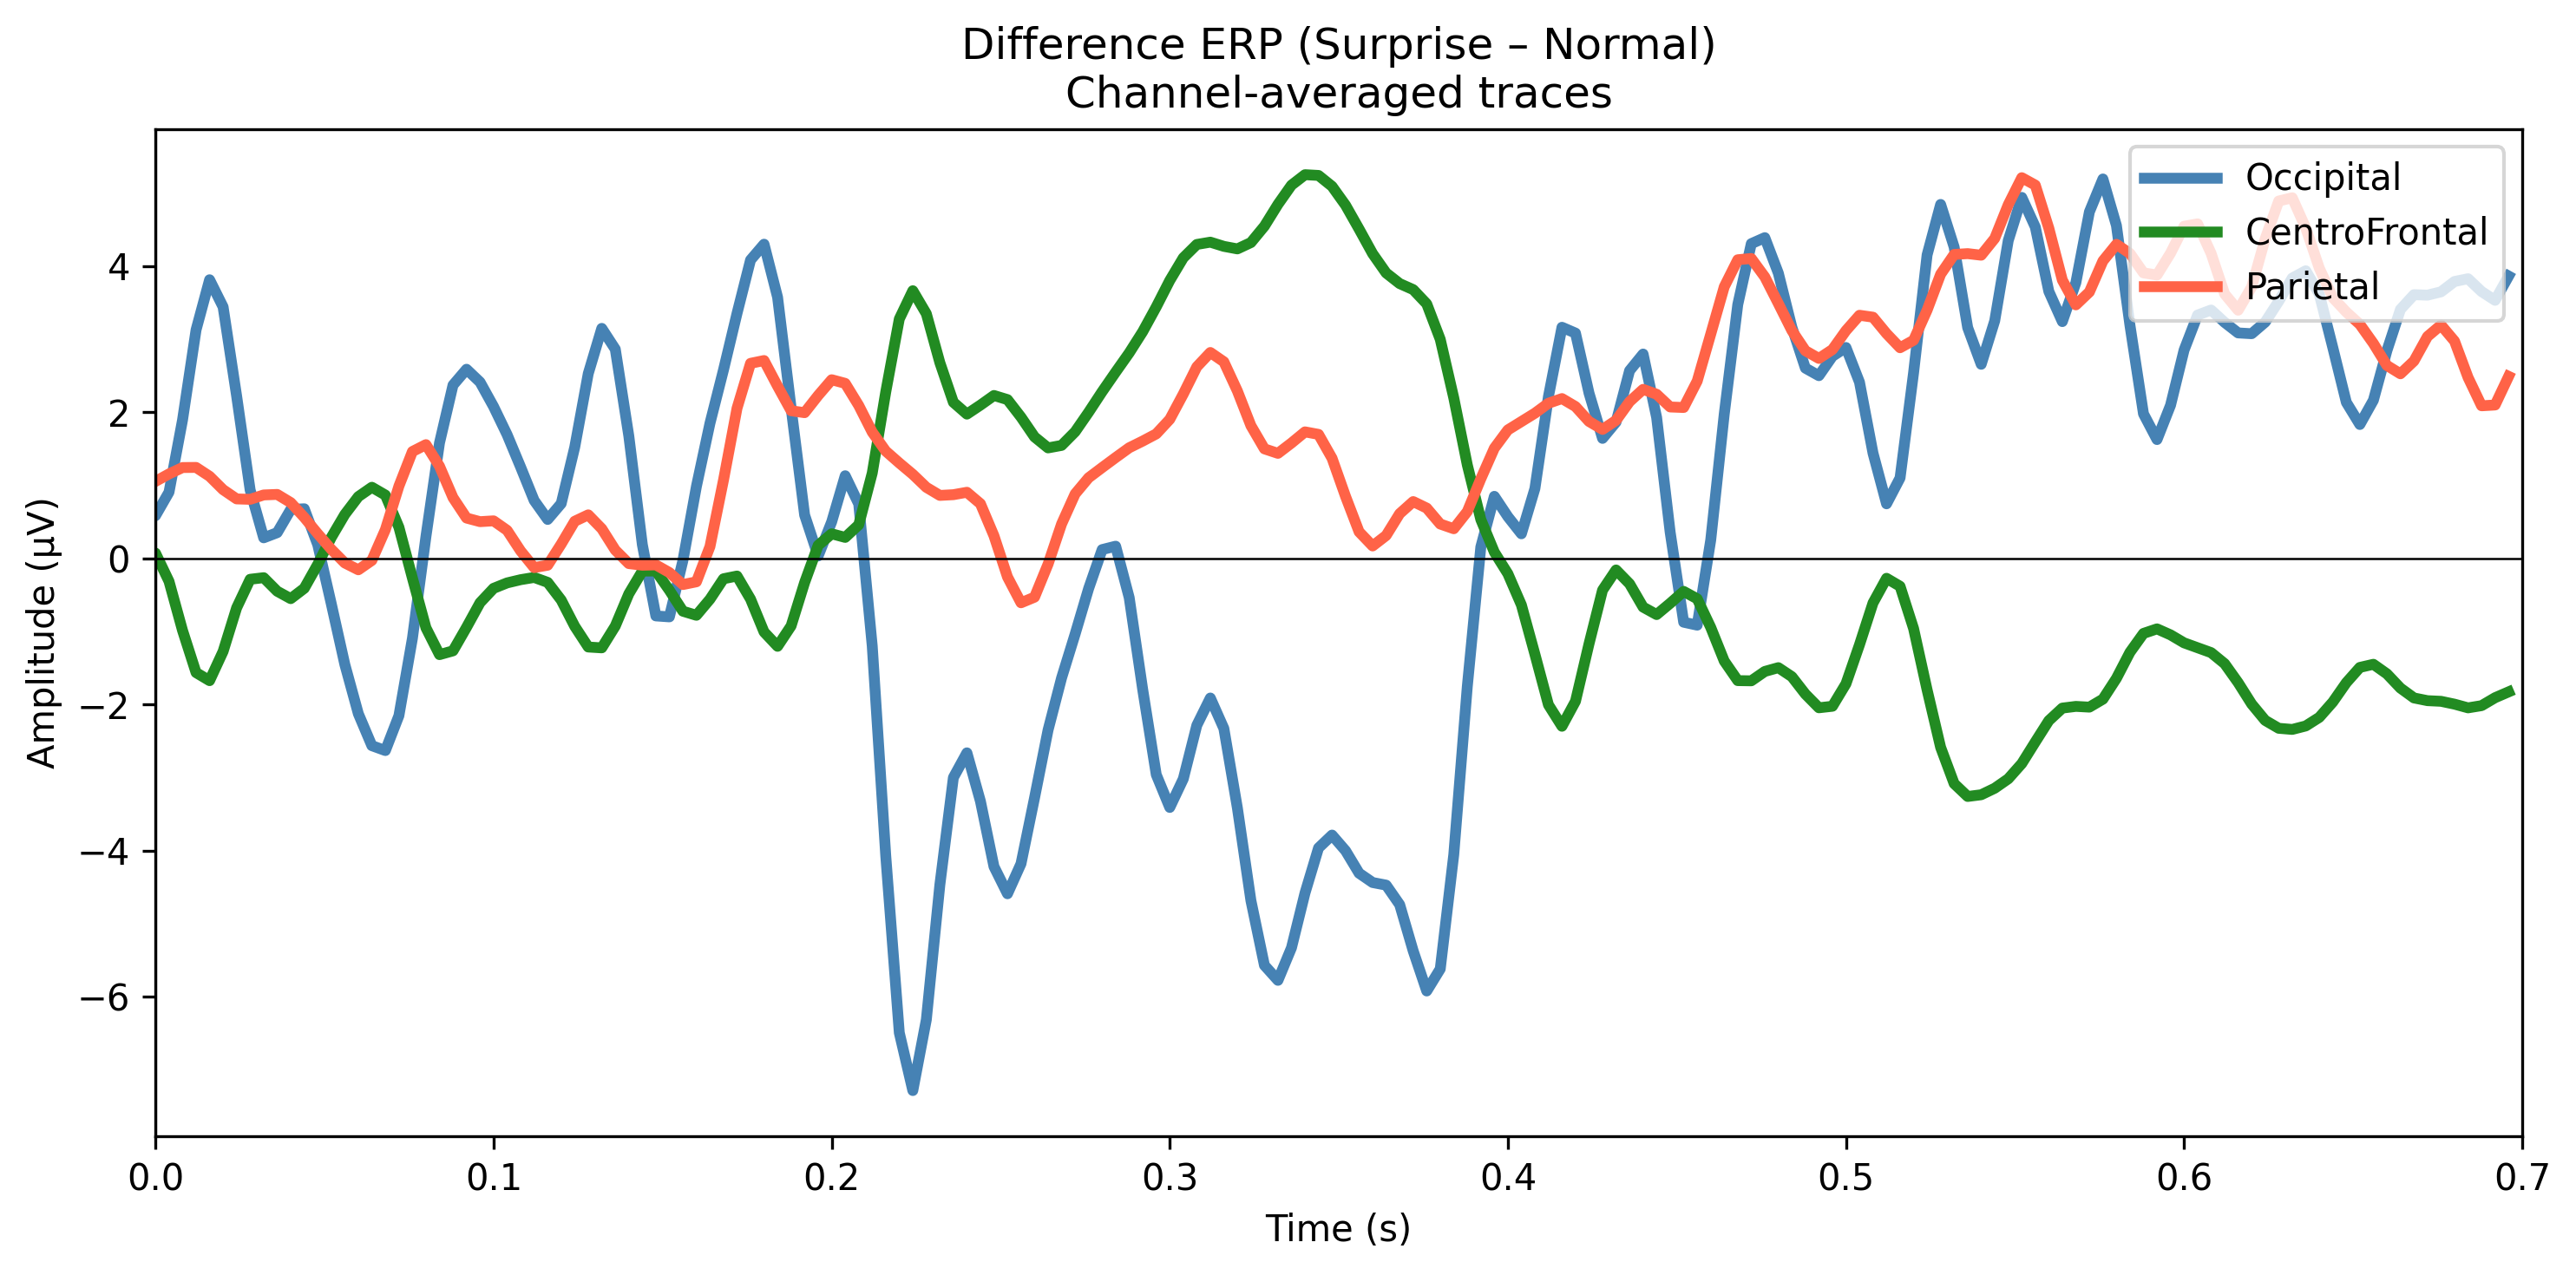

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# -------------------------------------------------
# 0)  define your channel groups & windows
# -------------------------------------------------
comp_cfg = dict(
    Occipital = dict(picks=picks_vmmn, color='steelblue'),
    CentroFrontal  = dict(picks=picks_n2, color='forestgreen'),
    Parietal  = dict(picks=picks_p3b, color='tomato'),
)

# -------------------------------------------------
# 1)  create an empty figure
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# -------------------------------------------------
# 2)  loop over the three components
# -------------------------------------------------
for label, cfg in comp_cfg.items():
    picks  = cfg['picks']
    #t0, t1 = cfg['tband']
    col    = cfg['color']

    # mean across the chosen channels  (difference is an Evoked)
    y = difference.copy().pick_channels(picks).data.mean(axis=0) * 1e6  # → µV
    ax.plot(difference.times, y, label=label, color=col, lw=3.0)

    # grey analysis window
    #ax.axvspan(t0, t1, color=mcolors.to_rgba(col, 0.15), zorder=-1)

# -------------------------------------------------
# 3)  decorating the panel
# -------------------------------------------------
ax.axvline(0, color='black', lw=1)
ax.axhline(0, color='black', lw=0.6)

ax.set(
    xlim=(0, 0.7),
    xlabel='Time (s)',
    ylabel='Amplitude (µV)',
    title='Difference ERP (Surprise – Normal)\nChannel-averaged traces'
)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()


### Components Dictionary

In [34]:
components = dict(
    vMMN = dict(picks=picks_vmmn, window=(0.200, 0.260), alt="less"),
    N2b  = dict(picks=picks_n2,   window=(0.240, 0.300), alt="less"),
    P3a  = dict(picks=picks_p3a,  window=(0.310, 0.370), alt="greater"),
    P3b  = dict(picks=picks_p3b,  window=(0.520, 0.580), alt="greater"),
)

### vMMN 

#### Individual Channels Plot

/tmp/ipykernel_835/18059261.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_835/18059261.py:49: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


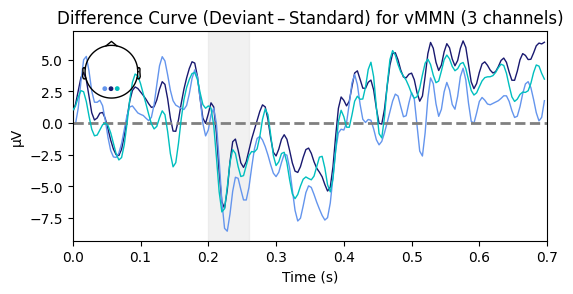

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.collections import PathCollection   # just for type check


# -------------------------------------------------
# 1)  make the standard spatial‑colour figure
# -------------------------------------------------
difference.nave = None
fig = difference.plot(
    picks=picks_vmmn,
    xlim=(0, 0.7),
    hline=[0],
    spatial_colors=True,                 # keep the head inset ✔
    titles=dict(eeg='Difference Curve (Deviant – Standard) for vMMN'),
    #linewidth=2.0,
    show=False
)

# -------------------------------------------------
# 2)  map each channel to a distinct shade of blue
# -------------------------------------------------
erp_ax  = fig.axes[0]                   # ERP traces
erp_ax, head_ax = fig.axes[:2]

n_lines = len(erp_ax.lines)
#cmap    = get_cmap('Blues')             # light–»dark blues

# pick N evenly spaced colours (skip the palest 20 %)
#blues   = get_cmap("Blues")(np.linspace(0.5, 1.0, n_lines))   # skip palest 50 %
blues = ['midnightblue', 'cornflowerblue', 'c']

for ln, col in zip(erp_ax.lines, blues):
    ln.set_color(col)
    ln.set_linewidth(1.0)

# recolour the dots: one PathCollection with N markers
dots = next(obj for obj in head_ax.collections
            if isinstance(obj, PathCollection))
dots.set_facecolors(blues)
dots.set_edgecolors(blues)          # outline to same hue

# -------------------------------------------------
# 3)  grey analysis window and show
# -------------------------------------------------
erp_ax.axvspan(0.200, 0.260, color="lightgray", alpha=0.3, zorder=-1)

fig.tight_layout()
plt.show()


#### Grand Average Plot

/tmp/ipykernel_18225/1953356133.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_18225/1953356133.py:45: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


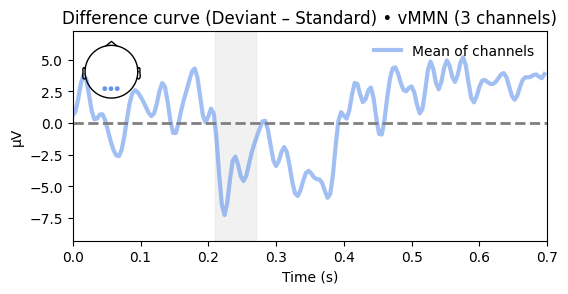

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection

blue = "cornflowerblue"        # single colour for mean trace

# 1) ordinary MNE plot
difference.nave = None
fig = difference.plot(
    picks=picks_vmmn,
    xlim=(0, 0.7),
    hline=[0],                     # zero-line stays
    spatial_colors=True,
    titles=dict(eeg="Difference curve (Deviant – Standard) • vMMN"),
    show=False
)

erp_ax, head_ax = fig.axes[:2]

# 2) keep only the channel traces (labels are channel names)
n_chan = len(picks_vmmn)            # how many traces we expect
trace_lines = list(erp_ax.lines)[:n_chan]   # first n lines = channels

ys = [ln.get_ydata() for ln in trace_lines]
avg = np.mean(ys, axis=0)

# replace first trace with mean, hide the others
trace_lines[0].set_ydata(avg)
trace_lines[0].set_color(blue)
trace_lines[0].set_alpha(0.6)
trace_lines[0].set_linewidth(3.0)
trace_lines[0].set_label("Mean of channels")

for ln in trace_lines[1:]:
    ln.set_visible(False)

# 3) recolour scalp dots
dots = next(c for c in head_ax.collections if isinstance(c, PathCollection))
dots.set_facecolors([blue] * len(dots.get_offsets()))
dots.set_edgecolors([blue] * len(dots.get_offsets()))

# 4) grey analysis window & show
erp_ax.axvspan(0.210, 0.270, color="lightgray", alpha=0.3, zorder=-1)
erp_ax.legend(frameon=False, loc="upper right")
fig.tight_layout()
plt.show()


In [ ]:
difference.plot_topomap(times=[0.210, 0.230, 0.250])

### N2b

#### Individual

/tmp/ipykernel_585/459986343.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_585/459986343.py:41: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


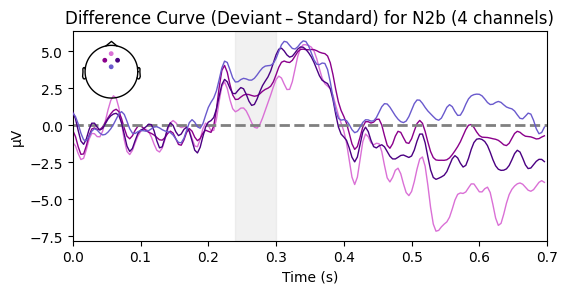

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# -------------------------------------------------
# 1)  make the standard spatial‑colour figure
# -------------------------------------------------
difference.nave = None
fig = difference.plot(
    picks=picks_n2,
    xlim=(0, 0.7),
    hline=[0],
    spatial_colors=True,                 # keep the head inset ✔
    titles=dict(eeg='Difference Curve (Deviant – Standard) for N2b'),
    show=False
)

# -------------------------------------------------
# 2)  map each channel to a distinct shade of blue
# -------------------------------------------------
erp_ax, head_ax = fig.axes[:2]

n_lines = len(erp_ax.lines)

# pick N evenly spaced colours (skip the palest 20 %)
#purples   = get_cmap("Purples")(np.linspace(0.5, 1.0, n_lines))   # skip palest 50 %
purples = ['orchid', 'darkmagenta', 'indigo', 'slateblue']

for ln, col in zip(erp_ax.lines, purples):
    ln.set_color(col)
    ln.set_linewidth(1.0)

# recolour the dots: one PathCollection with N markers
dots = next(obj for obj in head_ax.collections
            if isinstance(obj, PathCollection))
dots.set_facecolors(purples)
dots.set_edgecolors(purples)          # outline to same hue

erp_ax.axvspan(0.240, 0.300, color="lightgray", alpha=0.3, zorder=-1)

fig.tight_layout()
plt.show()


#### Average

/tmp/ipykernel_18225/125142431.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_18225/125142431.py:45: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


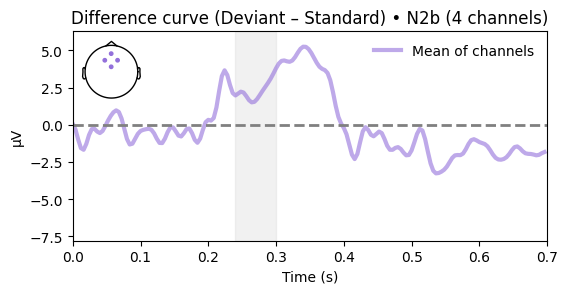

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection

purple = "mediumpurple"        # single colour for mean trace

# 1) ordinary MNE plot
difference.nave = None
fig = difference.plot(
    picks=picks_n2,
    xlim=(0, 0.7),
    hline=[0],                     # zero-line stays
    spatial_colors=True,
    titles=dict(eeg="Difference curve (Deviant – Standard) • N2b"),
    show=False
)

erp_ax, head_ax = fig.axes[:2]

# 2) keep only the channel traces (labels are channel names)
n_chan = len(picks_n2)            # how many traces we expect
trace_lines = list(erp_ax.lines)[:n_chan]   # first n lines = channels

ys = [ln.get_ydata() for ln in trace_lines]
avg = np.mean(ys, axis=0)

# replace first trace with mean, hide the others
trace_lines[0].set_ydata(avg)
trace_lines[0].set_color(purple)
trace_lines[0].set_linewidth(3.0)
trace_lines[0].set_alpha(0.6)
trace_lines[0].set_label("Mean of channels")

for ln in trace_lines[1:]:
    ln.set_visible(False)

# 3) recolour scalp dots
dots = next(c for c in head_ax.collections if isinstance(c, PathCollection))
dots.set_facecolors([purple] * len(dots.get_offsets()))
dots.set_edgecolors([purple] * len(dots.get_offsets()))

# 4) grey analysis window & show
erp_ax.axvspan(0.240, 0.300, color="lightgray", alpha=0.3, zorder=-1)
erp_ax.legend(frameon=False, loc="upper right")
fig.tight_layout()
plt.show()


In [ ]:
difference.plot_topomap(times=[0.250, 0.270, 0.290])

### P3a

#### Individual

/tmp/ipykernel_585/3872270164.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_585/3872270164.py:40: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


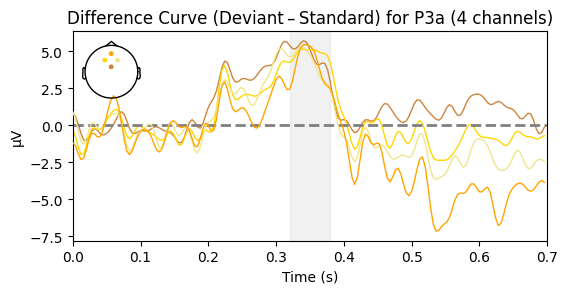

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# -------------------------------------------------
# 1)  make the standard spatial‑colour figure
# -------------------------------------------------
difference.nave = None
fig = difference.plot(
    picks=picks_p3a,
    xlim=(0, 0.7),
    hline=[0],
    spatial_colors=True,                 # keep the head inset ✔
    titles=dict(eeg='Difference Curve (Deviant – Standard) for P3a'),
    show=False
)

# -------------------------------------------------
# 2)  map each channel to a distinct shade of blue
# -------------------------------------------------
erp_ax, head_ax = fig.axes[:2]

n_lines = len(erp_ax.lines)

# pick N evenly spaced colours (skip the palest 20 %)
purples   = ['peru', 'gold', 'khaki', 'orange']

for ln, col in zip(erp_ax.lines, purples):
    ln.set_color(col)
    ln.set_linewidth(1.0)

# recolour the dots: one PathCollection with N markers
dots = next(obj for obj in head_ax.collections
            if isinstance(obj, PathCollection))
dots.set_facecolors(purples)
dots.set_edgecolors(purples)          # outline to same hue

erp_ax.axvspan(0.320, 0.380, color="lightgray", alpha=0.3, zorder=-1)

fig.tight_layout()
plt.show()


#### Average

/tmp/ipykernel_18225/1749280816.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_18225/1749280816.py:45: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


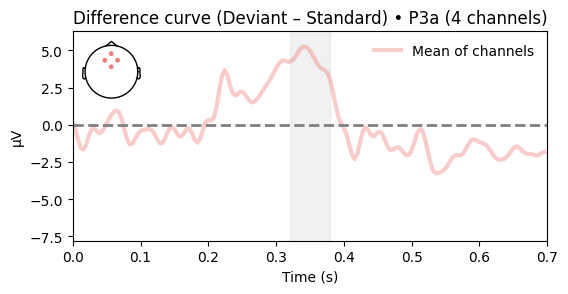

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection

yellow = "lightcoral"        # single colour for mean trace

# 1) ordinary MNE plot
difference.nave = None
fig = difference.plot(
    picks=picks_p3a,
    xlim=(0, 0.7),
    hline=[0],                     # zero-line stays
    spatial_colors=True,
    titles=dict(eeg="Difference curve (Deviant – Standard) • P3a"),
    show=False
)

erp_ax, head_ax = fig.axes[:2]

# 2) keep only the channel traces (labels are channel names)
n_chan = len(picks_p3a)            # how many traces we expect
trace_lines = list(erp_ax.lines)[:n_chan]   # first n lines = channels

ys = [ln.get_ydata() for ln in trace_lines]
avg = np.mean(ys, axis=0)

# replace first trace with mean, hide the others
trace_lines[0].set_ydata(avg)
trace_lines[0].set_color(yellow)
trace_lines[0].set_alpha(0.4)
trace_lines[0].set_linewidth(3.0)
trace_lines[0].set_label("Mean of channels")

for ln in trace_lines[1:]:
    ln.set_visible(False)

# 3) recolour scalp dots
dots = next(c for c in head_ax.collections if isinstance(c, PathCollection))
dots.set_facecolors([yellow] * len(dots.get_offsets()))
dots.set_edgecolors([yellow] * len(dots.get_offsets()))

# 4) grey analysis window & show
erp_ax.axvspan(0.320, 0.380, color="lightgray", alpha=0.3, zorder=-1)
erp_ax.legend(frameon=False, loc="upper right")
fig.tight_layout()
plt.show()


In [ ]:
difference.plot_topomap(times=[0.320, 0.340, 0.360])

### P3b

#### Individual

/tmp/ipykernel_585/2748373839.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_585/2748373839.py:40: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


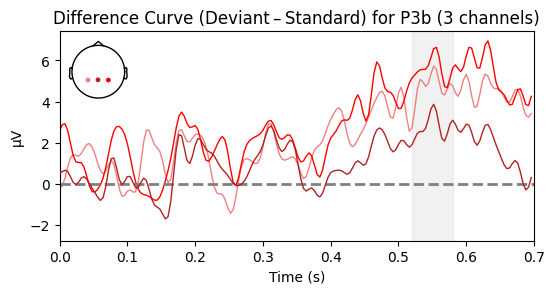

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# -------------------------------------------------
# 1)  make the standard spatial‑colour figure
# -------------------------------------------------
difference.nave = None
fig = difference.plot(
    picks=picks_p3b,
    xlim=(0, 0.7),
    hline=[0],
    spatial_colors=True,                 # keep the head inset ✔
    titles=dict(eeg='Difference Curve (Deviant – Standard) for P3b'),
    show=False
)

# -------------------------------------------------
# 2)  map each channel to a distinct shade of blue
# -------------------------------------------------
erp_ax, head_ax = fig.axes[:2]

n_lines = len(erp_ax.lines)

# pick N evenly spaced colours (skip the palest 20 %)
purples   = ['lightcoral', 'r', 'firebrick']

for ln, col in zip(erp_ax.lines, purples):
    ln.set_color(col)
    ln.set_linewidth(1.0)

# recolour the dots: one PathCollection with N markers
dots = next(obj for obj in head_ax.collections
            if isinstance(obj, PathCollection))
dots.set_facecolors(purples)
dots.set_edgecolors(purples)          # outline to same hue

erp_ax.axvspan(0.520, 0.580, color="lightgray", alpha=0.3, zorder=-1)

fig.tight_layout()
plt.show()


#### Average

/tmp/ipykernel_18225/1885752683.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_18225/1885752683.py:45: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


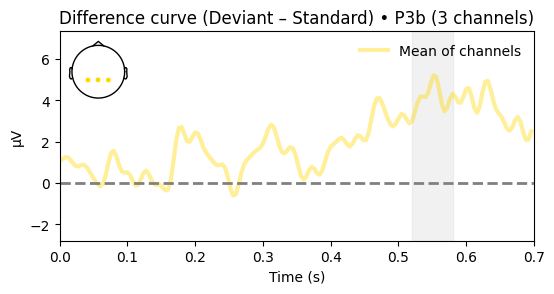

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection

red = "gold"        # single colour for mean trace

# 1) ordinary MNE plot
difference.nave = None
fig = difference.plot(
    picks=picks_p3b,
    xlim=(0, 0.7),
    hline=[0],                     # zero-line stays
    spatial_colors=True,
    titles=dict(eeg="Difference curve (Deviant – Standard) • P3b"),
    show=False
)

erp_ax, head_ax = fig.axes[:2]

# 2) keep only the channel traces (labels are channel names)
n_chan = len(picks_p3b)            # how many traces we expect
trace_lines = list(erp_ax.lines)[:n_chan]   # first n lines = channels

ys = [ln.get_ydata() for ln in trace_lines]
avg = np.mean(ys, axis=0)

# replace first trace with mean, hide the others
trace_lines[0].set_ydata(avg)
trace_lines[0].set_color(red)
trace_lines[0].set_alpha(0.4)
trace_lines[0].set_linewidth(3.0)
trace_lines[0].set_label("Mean of channels")

for ln in trace_lines[1:]:
    ln.set_visible(False)

# 3) recolour scalp dots
dots = next(c for c in head_ax.collections if isinstance(c, PathCollection))
dots.set_facecolors([red] * len(dots.get_offsets()))
dots.set_edgecolors([red] * len(dots.get_offsets()))

# 4) grey analysis window & show
erp_ax.axvspan(0.520, 0.580, color="lightgray", alpha=0.3, zorder=-1)
erp_ax.legend(frameon=False, loc="upper right")
fig.tight_layout()
plt.show()


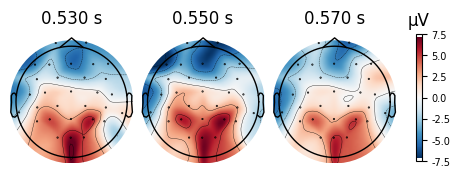

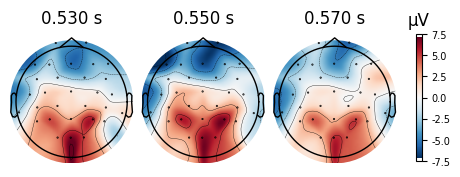

In [ ]:
difference.plot_topomap(times=[0.530, 0.550, 0.570])

## Butterfly Plots - Subject-Level

In [ ]:
# assume `all_epochs` holds one Epochs object per participant
# (first element = participant 1, second = participant 2, …)
# and that each Epochs object already contains the event labels
# “Normal” and “Surprise”.

diff_evokeds   = []      # to collect the difference waves
normal_evokeds = []      # (optional) keep condition averages too
surp_evokeds   = []

for subj_idx, epochs in enumerate(all_epochs, start=1):
    # --- slice the two conditions -----------------------------------
    epochs_normal   = epochs["Normal"]
    epochs_surprise = epochs["Surprise"]

    # --- participant-level ERPs -------------------------------------
    normal_evoked   = epochs_normal.average()
    surprise_evoked = epochs_surprise.average()

    # --- difference wave  (Surprise − Normal) -----------------------
    diff = mne.combine_evoked([surprise_evoked, normal_evoked],
                              weights=[1, -1])
    diff.comment = f"Surprise–Normal  P{subj_idx}"   # nice label

    # --- store ------------------------------------------------------
    diff_evokeds  .append(diff)
    normal_evokeds.append(normal_evoked)
    surp_evokeds  .append(surprise_evoked)

    print(f"Participant {subj_idx}:  Normal n={normal_evoked.nave}  "
          f"Surprise n={surprise_evoked.nave}")

# now `diff_evokeds[0]` is P1’s difference ERP, `diff_evokeds[1]` is P2’s, …


Participant 1:  Normal n=100  Surprise n=16
Participant 2:  Normal n=96  Surprise n=16


### vMMN

/tmp/ipykernel_30267/1411673298.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_30267/1411673298.py:28: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


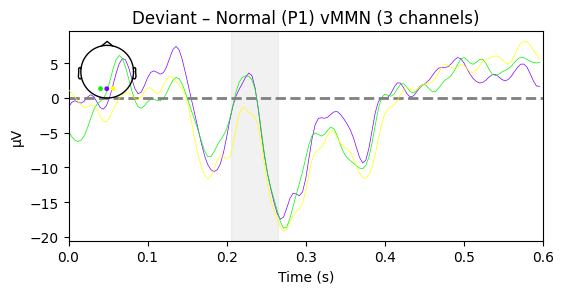

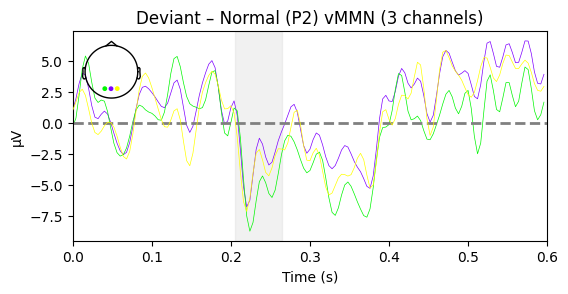

In [ ]:
import matplotlib.pyplot as plt

# diff_evokeds is the list created in the previous step
# picks_vmmn is the list/array with your vMMN electrodes

for subj_idx, difference in enumerate(diff_evokeds, start=1):
    # ---------------------------------------------------
    # 1) ERP panel for this participant
    # ---------------------------------------------------
    difference = difference.copy()        # keep the original intact
    difference.nave = None                # suppress "N = …" annotation

    fig = difference.plot(
        picks=picks_vmmn,
        xlim=(0, 0.6),                    # show 0–600 ms
        hline=[0],
        spatial_colors=True,
        titles=dict(eeg=f'Deviant – Normal (P{subj_idx}) vMMN'),
        show=False                        # keep the figure handle
    )

    # ---------------------------------------------------
    # 2) shade the 200–260 ms window
    # ---------------------------------------------------
    ax = fig.axes[0]                      # first axis = ERP trace
    ax.axvspan(0.205, 0.265, color='lightgray', alpha=0.3, zorder=-1)

    fig.tight_layout()
    plt.show()                            # or fig.savefig(...) if preferred


### N2b

/tmp/ipykernel_30267/2574956401.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_30267/2574956401.py:28: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


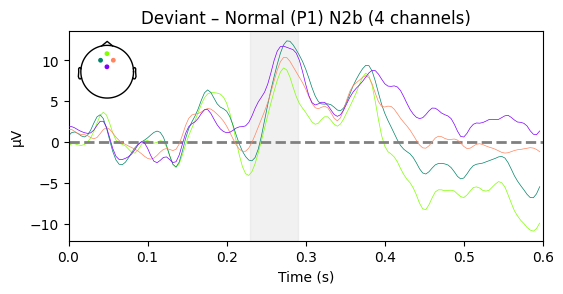

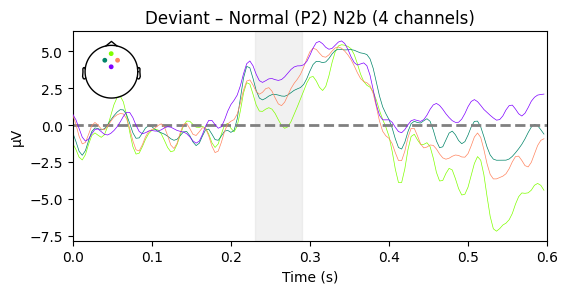

In [ ]:
import matplotlib.pyplot as plt

# diff_evokeds is the list created in the previous step
# picks_vmmn is the list/array with your vMMN electrodes

for subj_idx, difference in enumerate(diff_evokeds, start=1):
    # ---------------------------------------------------
    # 1) ERP panel for this participant
    # ---------------------------------------------------
    difference = difference.copy()        # keep the original intact
    difference.nave = None                # suppress "N = …" annotation

    fig = difference.plot(
        picks=picks_n2,
        xlim=(0, 0.6),                    # show 0–600 ms
        hline=[0],
        spatial_colors=True,
        titles=dict(eeg=f'Deviant – Normal (P{subj_idx}) N2b'),
        show=False                        # keep the figure handle
    )

    # ---------------------------------------------------
    # 2) shade the 200–260 ms window
    # ---------------------------------------------------
    ax = fig.axes[0]                      # first axis = ERP trace
    ax.axvspan(0.230, 0.290, color='lightgray', alpha=0.3, zorder=-1)

    fig.tight_layout()
    plt.show()                            # or fig.savefig(...) if preferred


### P3a

/tmp/ipykernel_30267/3468821529.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_30267/3468821529.py:28: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


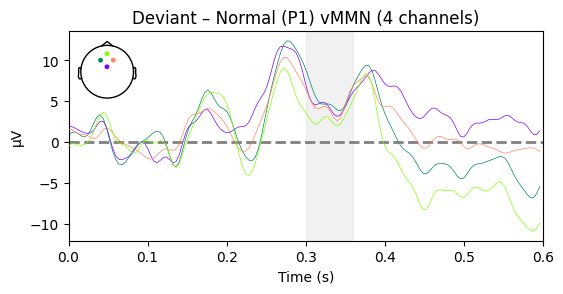

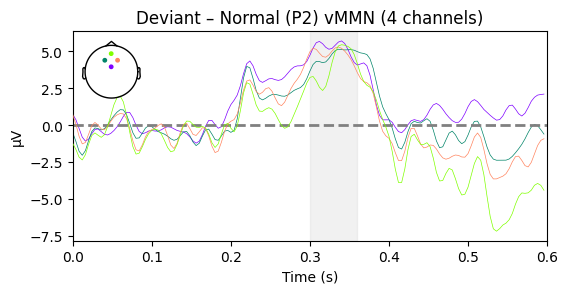

In [ ]:
import matplotlib.pyplot as plt

# diff_evokeds is the list created in the previous step
# picks_vmmn is the list/array with your vMMN electrodes

for subj_idx, difference in enumerate(diff_evokeds, start=1):
    # ---------------------------------------------------
    # 1) ERP panel for this participant
    # ---------------------------------------------------
    difference = difference.copy()        # keep the original intact
    difference.nave = None                # suppress "N = …" annotation

    fig = difference.plot(
        picks=picks_p3a,
        xlim=(0, 0.6),                    # show 0–600 ms
        hline=[0],
        spatial_colors=True,
        titles=dict(eeg=f'Deviant – Normal (P{subj_idx}) vMMN'),
        show=False                        # keep the figure handle
    )

    # ---------------------------------------------------
    # 2) shade the 200–260 ms window
    # ---------------------------------------------------
    ax = fig.axes[0]                      # first axis = ERP trace
    ax.axvspan(0.300, 0.360, color='lightgray', alpha=0.3, zorder=-1)

    fig.tight_layout()
    plt.show()                            # or fig.savefig(...) if preferred


### P3b

/tmp/ipykernel_30267/1247482362.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_30267/1247482362.py:28: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


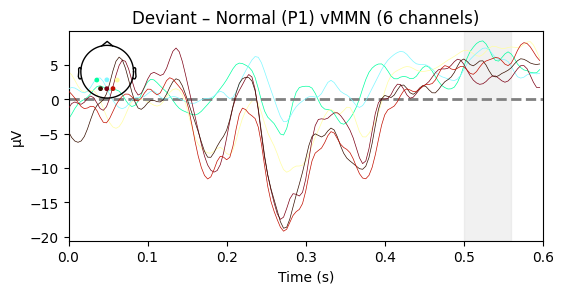

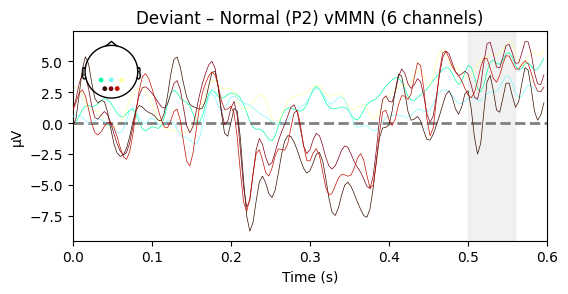

In [ ]:
import matplotlib.pyplot as plt

# diff_evokeds is the list created in the previous step
# picks_vmmn is the list/array with your vMMN electrodes

for subj_idx, difference in enumerate(diff_evokeds, start=1):
    # ---------------------------------------------------
    # 1) ERP panel for this participant
    # ---------------------------------------------------
    difference = difference.copy()        # keep the original intact
    difference.nave = None                # suppress "N = …" annotation

    fig = difference.plot(
        picks=picks_p3b,
        xlim=(0, 0.6),                    # show 0–600 ms
        hline=[0],
        spatial_colors=True,
        titles=dict(eeg=f'Deviant – Normal (P{subj_idx}) vMMN'),
        show=False                        # keep the figure handle
    )

    # ---------------------------------------------------
    # 2) shade the 200–260 ms window
    # ---------------------------------------------------
    ax = fig.axes[0]                      # first axis = ERP trace
    ax.axvspan(0.500, 0.560, color='lightgray', alpha=0.3, zorder=-1)

    fig.tight_layout()
    plt.show()                            # or fig.savefig(...) if preferred


In [ ]:
difference.plot_topomap(
    times=times,
    ncols=4,
    ch_type='eeg',
    time_unit='s',
    cmap='RdBu_r',
    vmin=-3e-6, vmax=3e-6,     # or whatever limits you computed
    colorbar=True              # common colour bar
)

# add a title afterwards
plt.suptitle('Surprise – Normal  (20 maps, 0.200–0.485 s)', y=0.95, fontsize=12)
plt.show()


TypeError: Evoked.plot_topomap() got an unexpected keyword argument 'vmin'

# Let's make a t-test table!

## Group-level t test

In [153]:
import numpy as np, pandas as pd
from scipy.stats import ttest_rel

components = dict(
    vMMN = dict(picks=picks_vmmn, window=(0.200, 0.260), alt="less"),
    N2b  = dict(picks=picks_n2,   window=(0.240, 0.300), alt="less"),
    P3a  = dict(picks=picks_p3a,  window=(0.320, 0.380), alt="greater"),
    P3b  = dict(picks=picks_p3b,  window=(0.520, 0.580), alt="greater"),
)

rows = []

for name, cfg in components.items():
    picks = cfg["picks"];  tmin, tmax = cfg["window"];  alt = cfg["alt"]

    # P × C matrices
    n_mat, s_mat = [], []
    for ep in all_epochs:                      # loop over the two participants
        n_mat.append(ep["Normal"  ].get_data(picks=picks, tmin=tmin, tmax=tmax)
                     .mean(axis=(0, 2)))
        s_mat.append(ep["Surprise"].get_data(picks=picks, tmin=tmin, tmax=tmax)
                     .mean(axis=(0, 2)))
    n_mat, s_mat = map(np.stack, (n_mat, s_mat))   # shape: (N_subj, N_chan)

    # per-channel statistics
    for ch_idx, ch_name in enumerate(picks):
        n = n_mat[:, ch_idx]
        s = s_mat[:, ch_idx]
        d = s - n                                  # paired difference

        t, p = ttest_rel(s, n, alternative=alt)
        sd_d = d.std(ddof=1)                       # ← new metric (µV)
        d_cohen = d.mean() / sd_d if sd_d else np.nan

        # between-subject spread of baseline amplitudes (mean of the two conds)
        baseline = np.vstack([n, s]).mean(axis=0)  # one value per subject
        subj_sd  = baseline.std(ddof=1)

        cond_vs_subj = abs(d.mean()) > subj_sd     # ← new boolean

        rows.append(dict(
            Component   = name,
            Channel     = ch_name,
            MeanDiff    = d.mean(),       # volts
            SD_Diff     = sd_d,           # volts
            t_value     = t,
            d_cohen     = d_cohen,
            p_value     = p,
            Cond_gt_Subj= cond_vs_subj
        ))

# tidy print-out -------------------------------------------------------
df = pd.DataFrame(rows)

def star(p): return "**" if p < .01 else "*" if p < .05 else ""
df["MeanDiff/µV"] = (df["MeanDiff"]*1e6).round(4).astype(str) + df["p_value"].map(star)
df["SD_Diff/µV"]  = (df["SD_Diff"] *1e6).round(4)

print(df[["Component","Channel",
          "MeanDiff/µV","SD_Diff/µV",
          "t_value","p_value","Cond_gt_Subj"]])


   Component Channel MeanDiff/µV  SD_Diff/µV  t_value  p_value  Cond_gt_Subj
0       vMMN      Oz    -2.2811*       +0.27   -11.75    +0.03         False
1       vMMN      O1     -2.9981       +1.75    -2.42    +0.12          True
2       vMMN      O2      -4.422       +1.76    -3.55    +0.09         False
3        N2b      Fz      2.9188       +2.90    +1.42    +0.80          True
4        N2b     FC1      4.9378       +3.97    +1.76    +0.84          True
5        N2b     FC2      4.7363       +3.28    +2.04    +0.86          True
6        N2b      Cz      6.3073       +4.12    +2.16    +0.86          True
7        P3a      Cz    4.8789**       +0.20   +35.20    +0.01          True
8        P3a     FC1     5.2162*       +0.57   +12.86    +0.02          True
9        P3a     FC2     4.6219*       +0.61   +10.75    +0.03          True
10       P3a      Fz    4.0555**       +0.07   +80.53    +0.00          True
11       P3b      P3      5.4962       +1.41    +5.50    +0.06          True

#### Plot

/tmp/ipykernel_18225/876447453.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 1, 1, 1])  # pack first


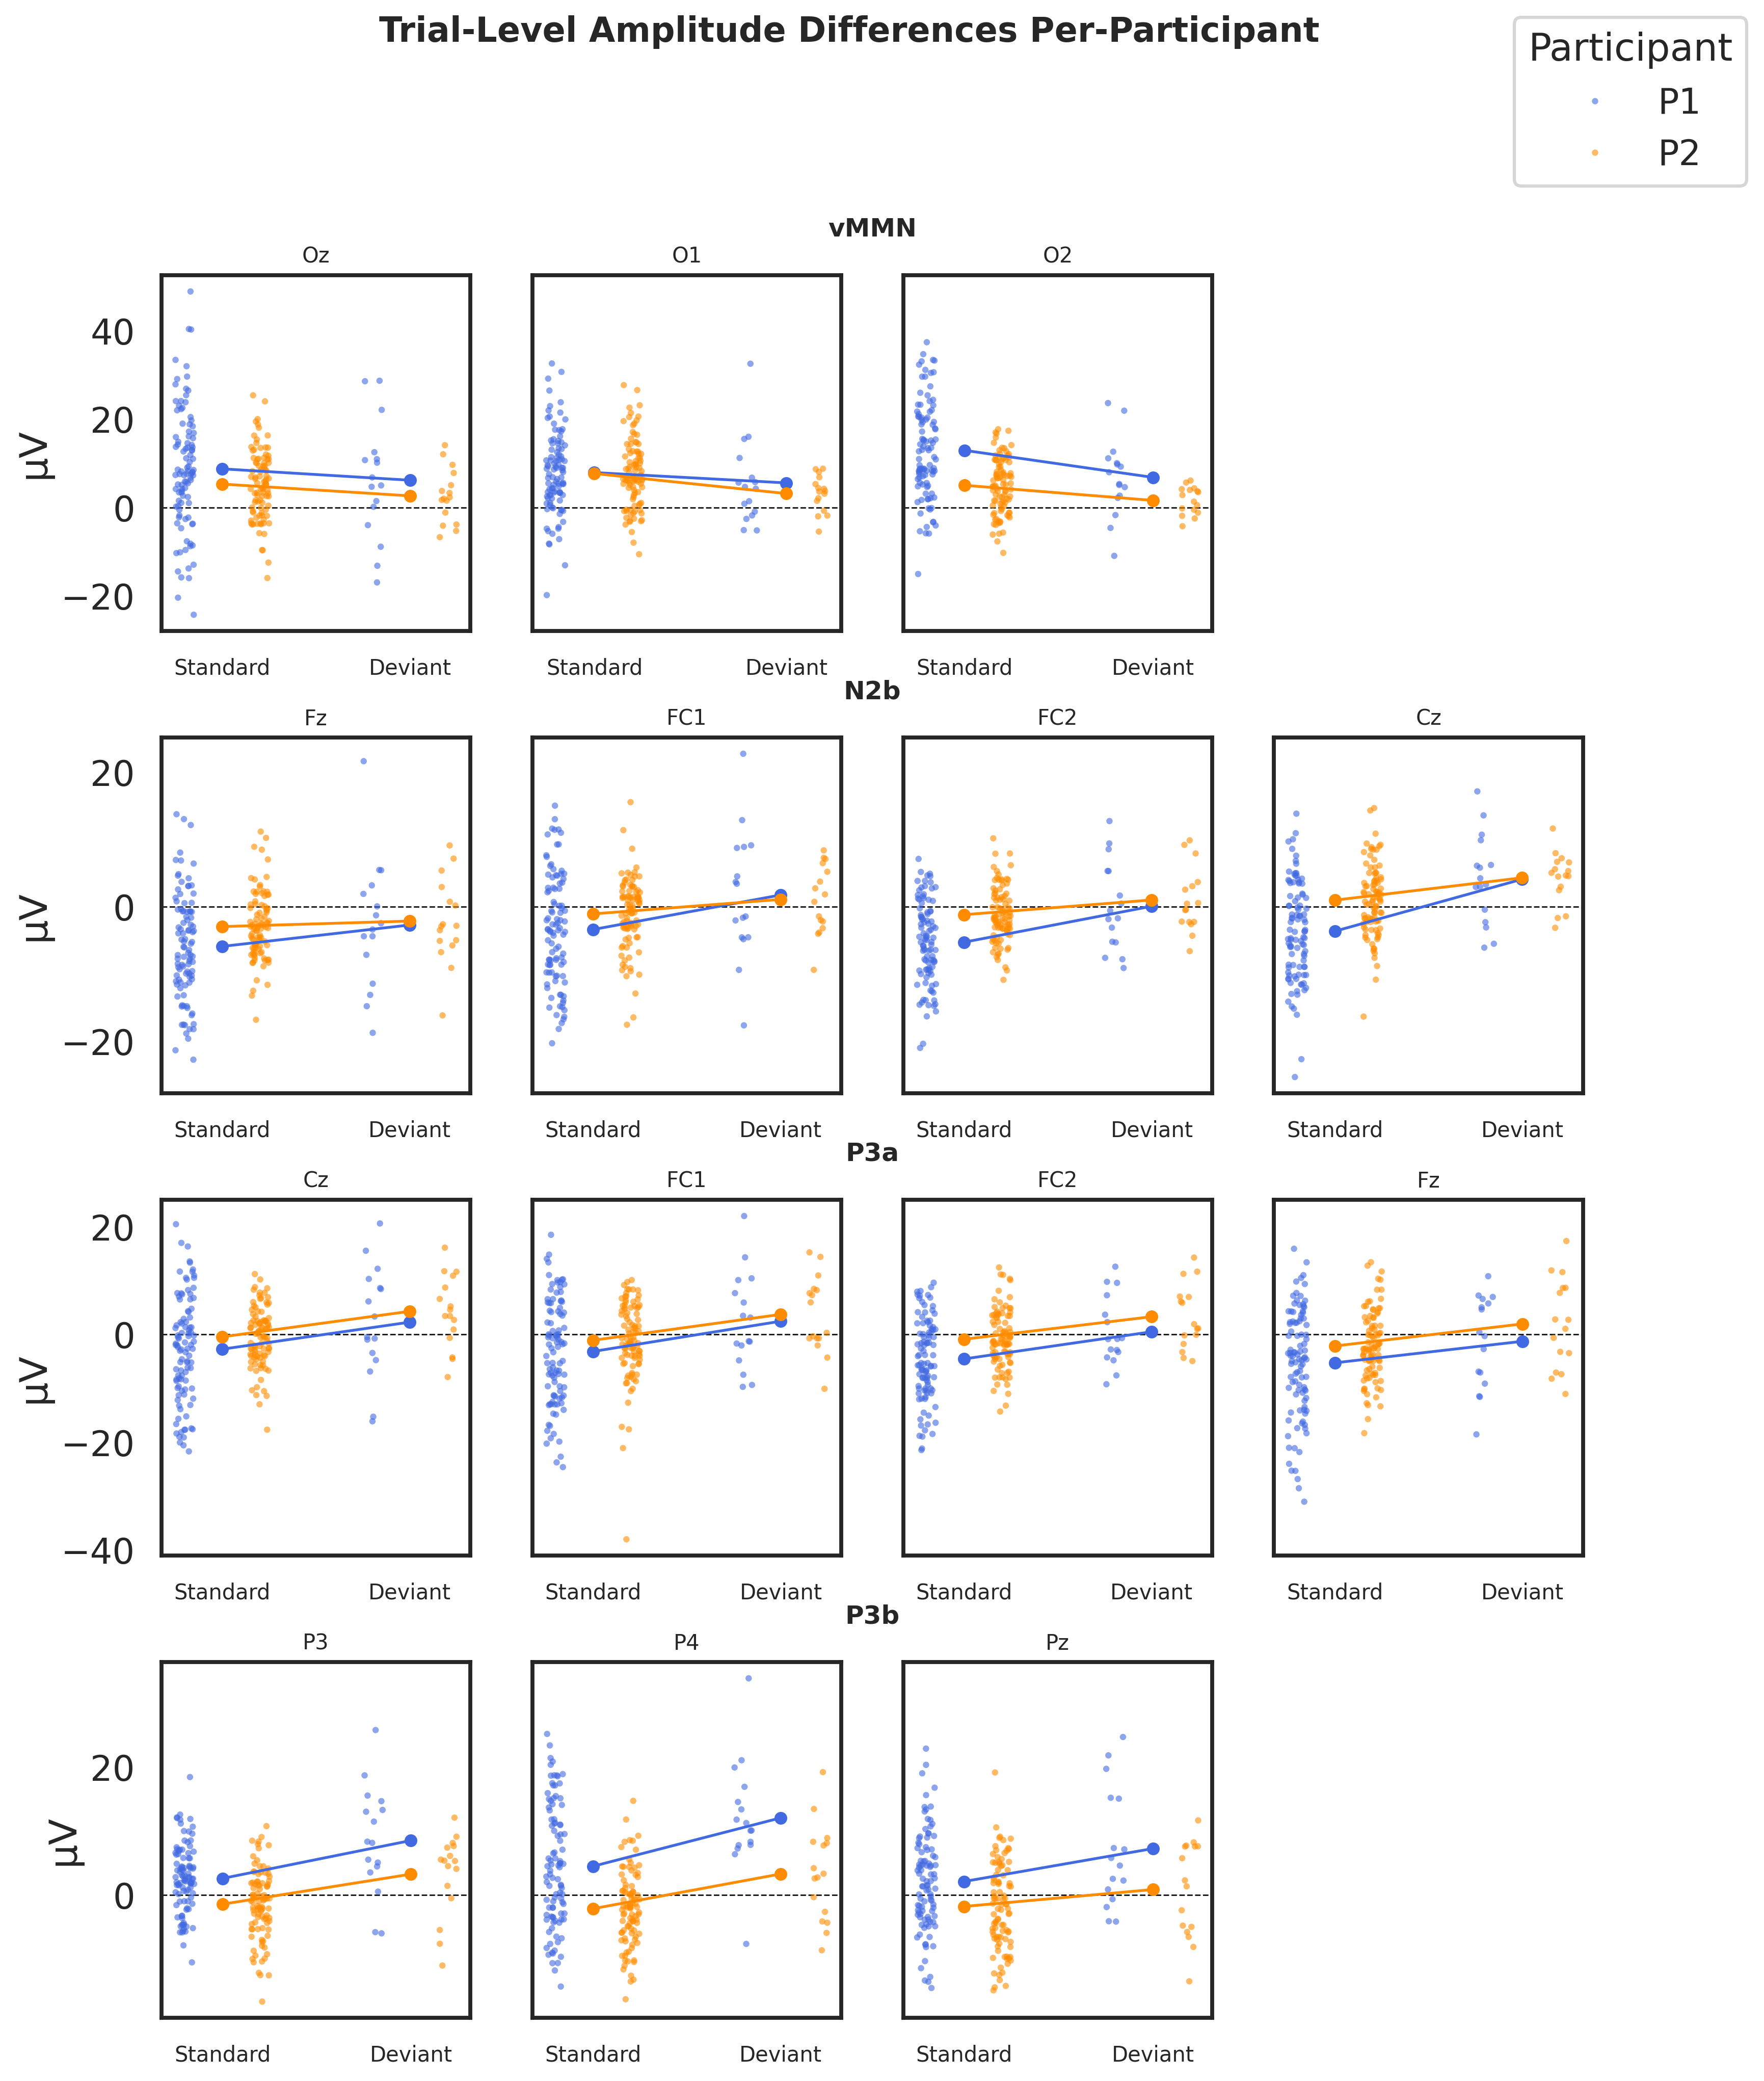

In [42]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="white", context="talk")           # no grid lines

# ──────────────────────────── 0) palettes & labels ────────────────────────────
palette    = {"P1": "royalblue", "P2": "darkorange"}
hue_order  = ["P1", "P2"]

cond_map   = {"Normal": "Standard", "Surprise": "Deviant"}
cond_order = ["Standard", "Deviant"]

components = dict(
    vMMN=dict(picks=picks_vmmn, window=(0.205, 0.265)),
    N2b =dict(picks=picks_n2,   window=(0.230, 0.290)),
    P3a =dict(picks=picks_p3a,  window=(0.320, 0.380)),
    P3b =dict(picks=picks_p3b,  window=(0.530, 0.590)),
)
max_cols = max(len(cfg["picks"]) for cfg in components.values())

# ──────────────────────────── 1) build trial‑level DataFrame ──────────────────
rows = []
for s_idx, ep in enumerate(all_epochs, start=1):
    subj = f"P{s_idx}"
    for cname, cfg in components.items():
        picks, (tmin, tmax) = cfg["picks"], cfg["window"]
        for cond_raw in ("Normal", "Surprise"):
            cond = cond_map[cond_raw]
            data = ep[cond_raw].get_data(picks=picks, tmin=tmin, tmax=tmax)
            trial_means = data.mean(axis=2) * 1e6  # → µV
            for tr in trial_means:
                for ch, val in zip(picks, tr):
                    rows.append(dict(Component=cname, Channel=ch,
                                     Subject=subj, Condition=cond, Value=val))
df = pd.DataFrame(rows)

# ──────────────────────────── 2) create subplot grid ──────────────────────────
n_rows = len(components)
fig, axes = plt.subplots(n_rows, max_cols,
                         figsize=(max_cols * 3, n_rows * 3.7),
                         dpi=300, sharey='row',
                         gridspec_kw=dict(hspace=0.30) )
axes = np.atleast_2d(axes)

legend_handles = legend_labels = None  # collect once for global legend

# ──────────────────────────── 3) fill grid with strip‑plots ───────────────────
for r, (cname, cfg) in enumerate(components.items()):
    chs = cfg["picks"]
    for c, ch in enumerate(chs):
        ax = axes[r, c]
        data = df.query("Component == @cname and Channel == @ch")

        #  trial‑by‑trial dots
        sns.stripplot(data=data, x="Condition", y="Value",
                      hue="Subject", palette=palette, hue_order=hue_order,
                      dodge=True, size=3, alpha=0.6,
                      order=cond_order, ax=ax)

        #  coloured participant means
        means = (data.groupby(["Subject", "Condition"])["Value"]
                     .mean().unstack())

        ax.tick_params(axis="x", labelsize=10)   # ← font size in points

        for subj, row in means.iterrows():
            ax.plot(cond_order, row[cond_order],
                    color=palette[subj], lw=1.3, marker="o", ms=5, zorder=5)

        ax.axhline(0, color="k", ls="--", lw=0.7)
        ax.set(xlabel="", ylabel="µV" if c == 0 else "")
        ax.set_title(ch, fontsize=10)

        if legend_handles is None:                      # grab legend once
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend([], [], frameon=False)                # suppress per‑subplot

    # turn off empty cells at end of short rows
    for empty_ax in axes[r, len(chs):]:
        empty_ax.axis("off")

# ───────────────────────── 4) global legend (unchanged) ────────────────
fig.legend(legend_handles, legend_labels,
           title="Participant", loc="upper right", frameon=True)

# ───────────────────────── 5) spacing between rows  ────────────────────
# tight_layout arranges the axes; subplots_adjust then adds extra room
fig.tight_layout(rect=[0, 1, 1, 1])  # pack first
fig.subplots_adjust(hspace=0.2)       # then enlarge the row gap

# ───────────────────────── 6) row labels *after* final layout ──────────
for r, (cname, _) in enumerate(components.items()):
    # use the *first* and *last grid column* (even if turned off)
    left  = axes[r, 0].get_position(fig).x0
    right = axes[r, -1].get_position(fig).x1      # always last column
    top   = axes[r, 0].get_position(fig).y1

    fig.text((left + right) / 2,                  # centred horizontally
             top + 0.015,                          # 0.02 figure units above
             cname, ha="center", va="bottom",
             weight="bold", fontsize=12)

# ───────────────────────── 7) main title  (move it a bit higher) ───────
fig.suptitle("Trial‑Level Amplitude Differences Per-Participant", weight="bold",
             fontsize=16, y=0.995)

plt.show()

## Individual t-tests

# Subject-Level Inspections

## Table

In [37]:
import numpy as np, pandas as pd
from scipy.stats import ttest_ind        # Welch when equal_var=False

components = dict(
    vMMN = dict(picks=picks_vmmn, window=(0.200, 0.260), alt="less"),
    N2b  = dict(picks=picks_n2,   window=(0.240, 0.300), alt="less"),
    P3a  = dict(picks=picks_p3a,  window=(0.320, 0.380), alt="greater"),
    P3b  = dict(picks=picks_p3b,  window=(0.520, 0.580), alt="greater"),
)

rows = []

for subj_idx, ep in enumerate(all_epochs, start=1):
    subj = f"P{subj_idx}"

    for name, cfg in components.items():
        picks, (tmin, tmax), alt = cfg["picks"], cfg["window"], cfg["alt"]

        for ch in picks:
            # trial arrays (µV)
            n_vals = (ep["Normal"  ]
                        .get_data(picks=[ch], tmin=tmin, tmax=tmax)
                        .mean(axis=2).ravel() * 1e6)
            s_vals = (ep["Surprise"]
                        .get_data(picks=[ch], tmin=tmin, tmax=tmax)
                        .mean(axis=2).ravel() * 1e6)

            res = ttest_ind(s_vals, n_vals,
                            alternative=alt, equal_var=False)  # Welch
            
            mean_diff = s_vals.mean() - n_vals.mean()

            
            n1, n2 = len(n_vals), len(s_vals)
            s1, s2  = n_vals.std(ddof=1), s_vals.std(ddof=1)

# pooled standard deviation of the *trial* distributions (µV)
            sd_pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1 + n2 - 2))

            rows.append(dict(
                Subject    = subj,
                Component  = name,
                Channel    = ch,
                MeanDiff   = mean_diff,   # µV
                t_value    = res.statistic,
                SD_Diff    = sd_pooled,
                df         = res.df,      # <─ degrees of freedom
                p_value    = res.pvalue,
            ))

# ---------------- summary table ----------------
df = pd.DataFrame(rows)
df["MeanDiff/µV"] = df["MeanDiff"]      # keep numeric if you like
df["p_value_fmt"] = df["p_value"].map(lambda x: f"{x:.5f}")

print(df[["Subject", "Component", "Channel",
          "MeanDiff/µV", "t_value", "p_value_fmt"]])


   Subject Component Channel  MeanDiff/µV   t_value p_value_fmt
0       P1      vMMN      Oz    -2.086926 -0.573577     0.28630
1       P1      vMMN      O1    -1.758490 -0.687034     0.25008
2       P1      vMMN      O2    -5.668908 -2.395284     0.01251
3       P1       N2b      Fz     4.970174  1.906233     0.96357
4       P1       N2b     FC1     7.747858  3.082603     0.99689
5       P1       N2b     FC2     7.055874  3.914117     0.99951
6       P1       N2b      Cz     9.223206  5.150427     0.99998
7       P1       P3a      Cz     5.017492  1.813803     0.04259
8       P1       P3a     FC1     5.621691  2.312488     0.01546
9       P1       P3a     FC2     5.051788  2.831766     0.00485
10      P1       P3a      Fz     4.005162  1.684368     0.05312
11      P1       P3b      P3     6.495541  2.871441     0.00536
12      P1       P3b      P4     7.293940  2.996706     0.00343
13      P1       P3b      Pz     5.624899  2.274237     0.01760
14      P2      vMMN      Oz    -2.47535

#### Individual Time Windows

In [38]:
import numpy as np, pandas as pd

# ------------------------------------------------------------------
# 0)  channel groups & search windows (seconds)
# ------------------------------------------------------------------
windows = {
    "vMMN": dict(picks=picks_vmmn, tmin=0.150, tmax=0.250),   # 150–300 ms
    "N2b":  dict(picks=picks_n2,   tmin=0.220, tmax=0.300),   # 220–300 ms
    "P3a":  dict(picks=picks_p3a,  tmin=0.250, tmax=0.350),   # 250–350 ms
    "P3b":  dict(picks=picks_p3b,  tmin=0.300, tmax=0.600),   # 300–600 ms
}

rows = []                       # storage for DataFrame

# ------------------------------------------------------------------
# 1)  loop over participants and components
# ------------------------------------------------------------------
for subj_idx, ep in enumerate(all_epochs, start=1):
    subj = f"P{subj_idx}"

    for name, cfg in windows.items():
        picks = cfg["picks"]
        tmin, tmax = cfg["tmin"], cfg["tmax"]

        # --- pull data for this participant, condition, window, channels
        dev = ep["Surprise"].get_data(picks=picks, tmin=tmin, tmax=tmax)
        std = ep["Normal"  ].get_data(picks=picks, tmin=tmin, tmax=tmax)

        # --- mean over trials *and* channels → 1-D trace (volts)
        diff = (dev.mean(axis=(0, 1)) - std.mean(axis=(0, 1)))

        # --- time vector restricted to the window
        mask = (ep.times >= tmin) & (ep.times <= tmax)
        tvec = ep.times[mask]

        # --- extrema & latencies
        idx_min = diff.argmin()
        idx_max = diff.argmax()

        rows.append(dict(
            Subject      = subj,
            Component    = name,
            MostNeg_amp  = diff[idx_min] * 1e6,            # µV
            MostNeg_lat  = tvec[idx_min] * 1e3,            # ms
            MostPos_amp  = diff[idx_max] * 1e6,
            MostPos_lat  = tvec[idx_max] * 1e3
        ))

# ------------------------------------------------------------------
# 2)  tidy summary
# ------------------------------------------------------------------
peak_df = pd.DataFrame(rows)
pd.set_option("display.float_format", "{:+.2f}".format)

print(peak_df)


  Subject Component  MostNeg_amp  MostNeg_lat  MostPos_amp  MostPos_lat
0      P1      vMMN       -10.03      +184.00        +2.24      +152.00
1      P1       N2b        -1.25      +232.00       +10.82      +280.00
2      P1       P3a        +2.91      +252.00       +10.82      +280.00
3      P1       P3b        -2.53      +300.00        +7.48      +528.00
4      P2      vMMN        -7.28      +228.00        +4.30      +184.00
5      P2       N2b        +1.51      +268.00        +3.66      +228.00
6      P2       P3a        +1.51      +268.00        +5.25      +344.00
7      P2       P3b        +0.17      +360.00        +5.21      +552.00


In [142]:
# peak_df columns: Subject | Component | MostNeg_lat (ms)
subj_windows = {}

for _, row in peak_df.iterrows():
    subj = row.Subject
    comp = row.Component

    # --- 1) round to nearest 5 ms -----------------------------
    peak_ms = 5 * round(row.MostNeg_lat / 5)         # e.g. 212.4 → 210
    peak_s  = peak_ms / 1000.0                       # convert to seconds

    # --- 2) ±25 ms window around that rounded peak ----------
    subj_windows.setdefault(subj, {})[comp] = (
        peak_s - 0.030,      # tmin
        peak_s + 0.030       # tmax
    )


In [164]:
import numpy as np, pandas as pd
from scipy.stats import ttest_ind

components = dict(
    vMMN = dict(picks=picks_vmmn,  alt="less"),
    N2b  = dict(picks=picks_n2,    alt="less"),
    P3a  = dict(picks=picks_p3a,   alt="greater"),
    P3b  = dict(picks=picks_p3b,   alt="greater"),
)

rows = []

for subj_idx, ep in enumerate(all_epochs, start=1):
    subj = f"P{subj_idx}"

    for comp_name, cfg in components.items():
        picks = cfg["picks"]
        alt   = cfg["alt"]

        # participant-specific latency window
        tmin, tmax = subj_windows[subj][comp_name]

        for ch in picks:
            # pull trials within that personal window
            n_trials = ep["Normal"  ].get_data(picks=[ch], tmin=tmin, tmax=tmax)
            s_trials = ep["Surprise"].get_data(picks=[ch], tmin=tmin, tmax=tmax)

            n_vals = n_trials.mean(axis=2).ravel() * 1e6   # µV
            s_vals = s_trials.mean(axis=2).ravel() * 1e6

            res = ttest_ind(s_vals, n_vals,
                            alternative=alt, equal_var=False)  # Welch
            
            mean_diff = s_vals.mean() - n_vals.mean()

            rows.append(dict(
                Subject    = subj,
                Component  = name,
                Channel    = ch,
                MeanDiff   = mean_diff,   # µV
                t_value    = res.statistic,
                df         = res.df,      # <─ degrees of freedom
                p_value    = res.pvalue,
            ))


df = pd.DataFrame(rows)
df["MeanDiff/µV"] = df["MeanDiff"].round(3)
print(df[["Subject","Component","Channel","MeanDiff/µV","t_value", "df","p_value"]])


   Subject Component Channel  MeanDiff/µV  t_value     df  p_value
0       P1       P3b      Oz        -5.80    -1.61 +19.43    +0.06
1       P1       P3b      O1        -5.03    -2.18 +19.40    +0.02
2       P1       P3b      O2        -8.02    -3.19 +19.20    +0.00
3       P1       P3b      Fz        +0.00    +0.00 +20.23    +0.50
4       P1       P3b     FC1        +0.81    +0.38 +20.95    +0.65
5       P1       P3b     FC2        +1.15    +0.78 +21.76    +0.78
6       P1       P3b      Cz        +3.26    +1.84 +22.44    +0.96
7       P1       P3b      Cz        +6.45    +3.47 +21.13    +0.00
8       P1       P3b     FC1        +3.34    +1.32 +18.91    +0.10
9       P1       P3b     FC2        +3.87    +2.32 +20.28    +0.02
10      P1       P3b      Fz        +1.73    +0.71 +18.70    +0.24
11      P1       P3b      P3        -0.71    -0.63 +24.06    +0.73
12      P1       P3b      P4        -8.13    -3.82 +22.09    +1.00
13      P1       P3b      Pz        -0.88    -0.50 +23.85    +

## N2B Subject Level

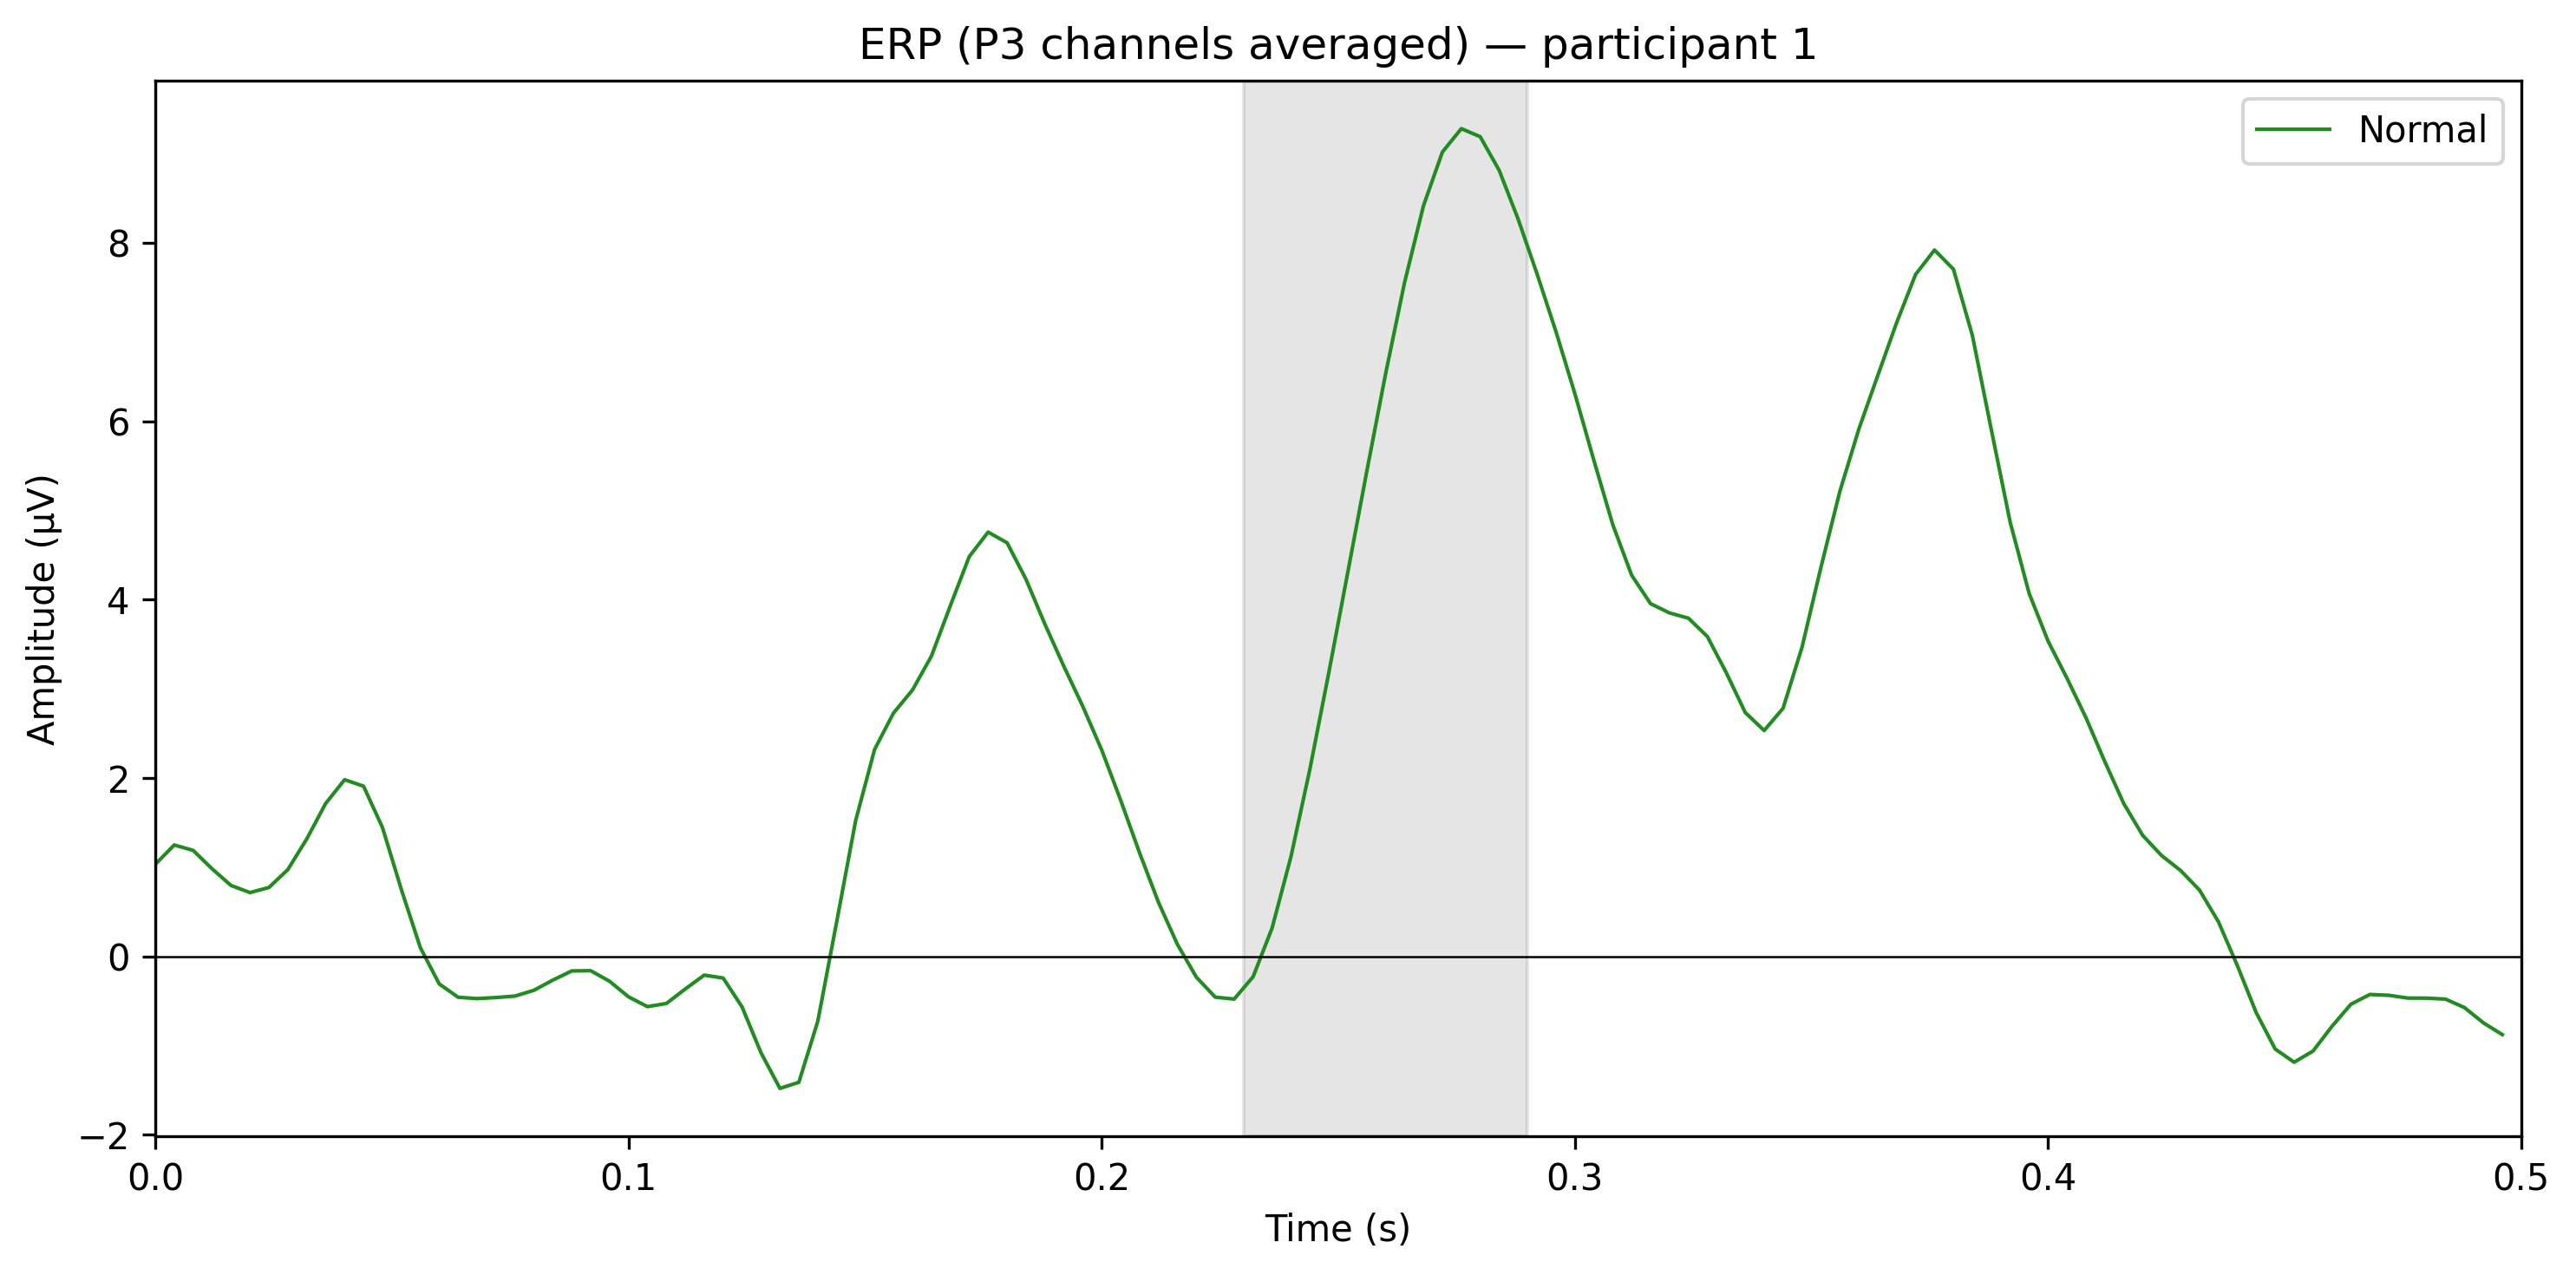

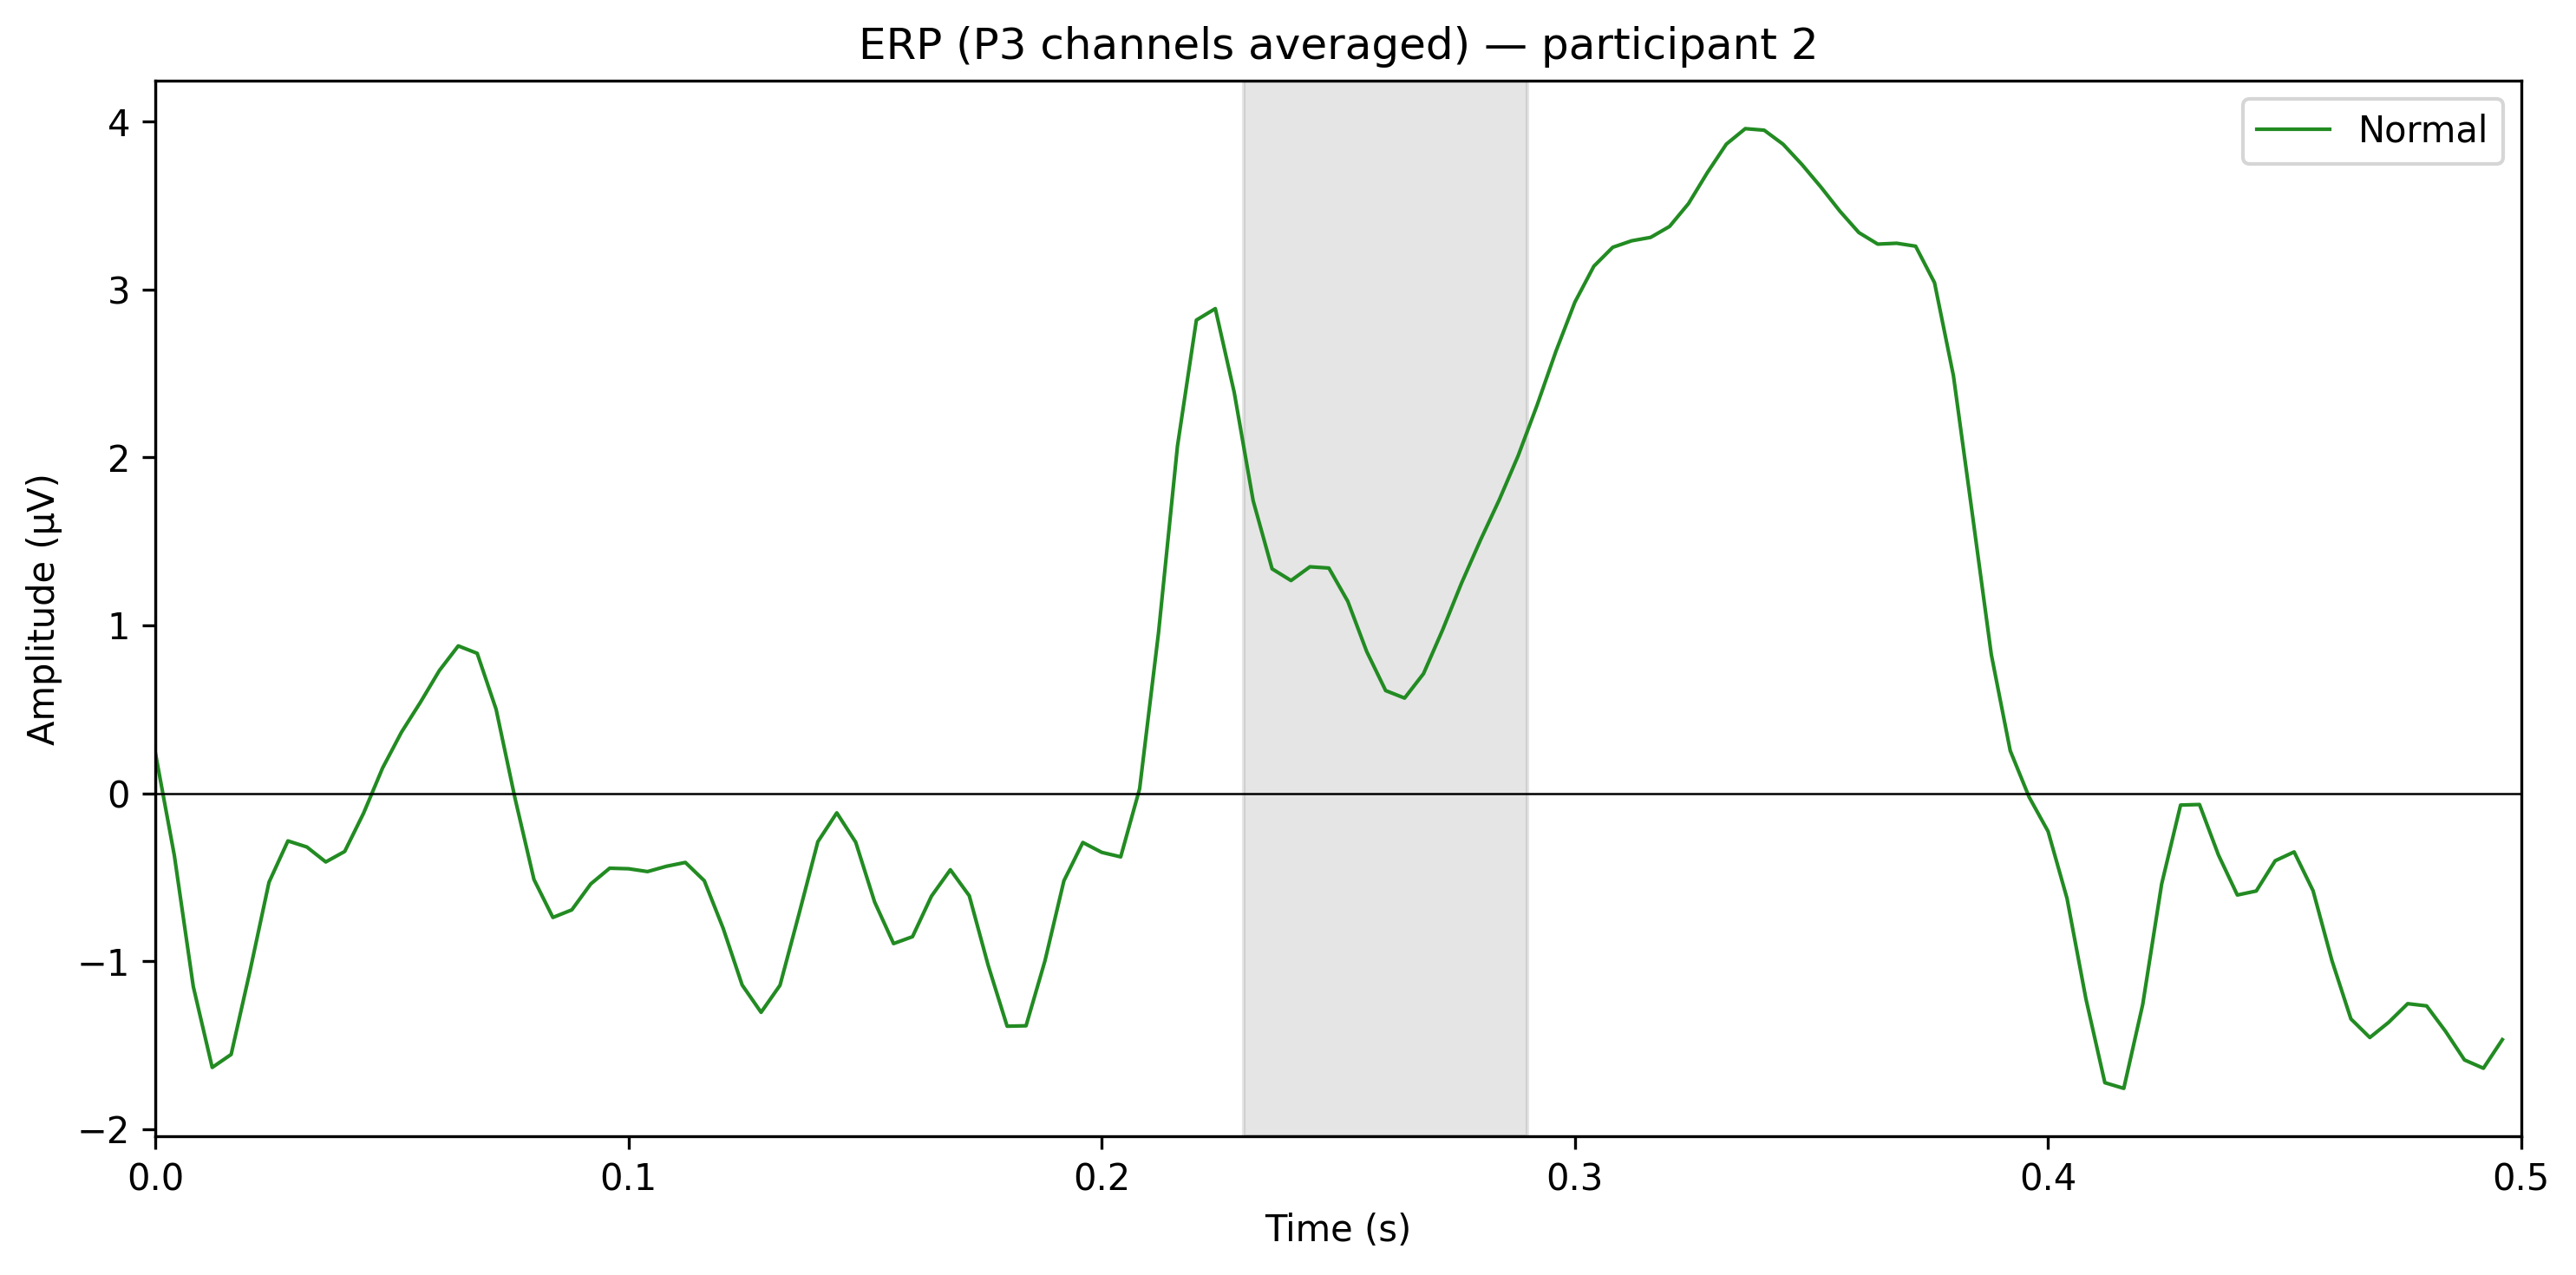

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# loop over participants  (all_epochs contains P1 then P2)
# -------------------------------------------------------------
for subj_idx, epochs in enumerate(all_epochs, start=1):

    # ---------- 1. grand average across channels & trials -----
    # get_data  →  shape (n_trials, n_channels, n_times)
    norm  = epochs["Normal"  ].get_data(picks=picks_n2, tmin=0.0, tmax=0.5)
    surp  = epochs["Surprise"].get_data(picks=picks_n2, tmin=0.0, tmax=0.5)

    norm_mean  = norm.mean(axis=(0, 1)) * 1e6     # → µV, shape (n_times,)
    surp_mean  = surp.mean(axis=(0, 1)) * 1e6

    times = epochs_t.times                           # x-axis in seconds

    # ---------- 2. plot for this participant ------------------
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

    ax.axvspan(0.230, 0.290, color="grey", alpha=0.2, zorder=-1)   # P3 window
    ax.plot(times, surp_mean - norm_mean, label="Normal",  color="forestgreen", lw=1)

    ax.axvline(0, color="black", lw=1)
    ax.axhline(0, color="black", lw=0.6)

    ax.set(
        xlim=(0, 0.5),
        xlabel="Time (s)",
        ylabel="Amplitude (µV)",
        title=f"ERP (P3 channels averaged) — participant {subj_idx}"
    )
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()


## P300 Subject Level

In [ ]:
picks_p3b = ['CP1', 'CP2', 'Pz', 'P3', 'P4']

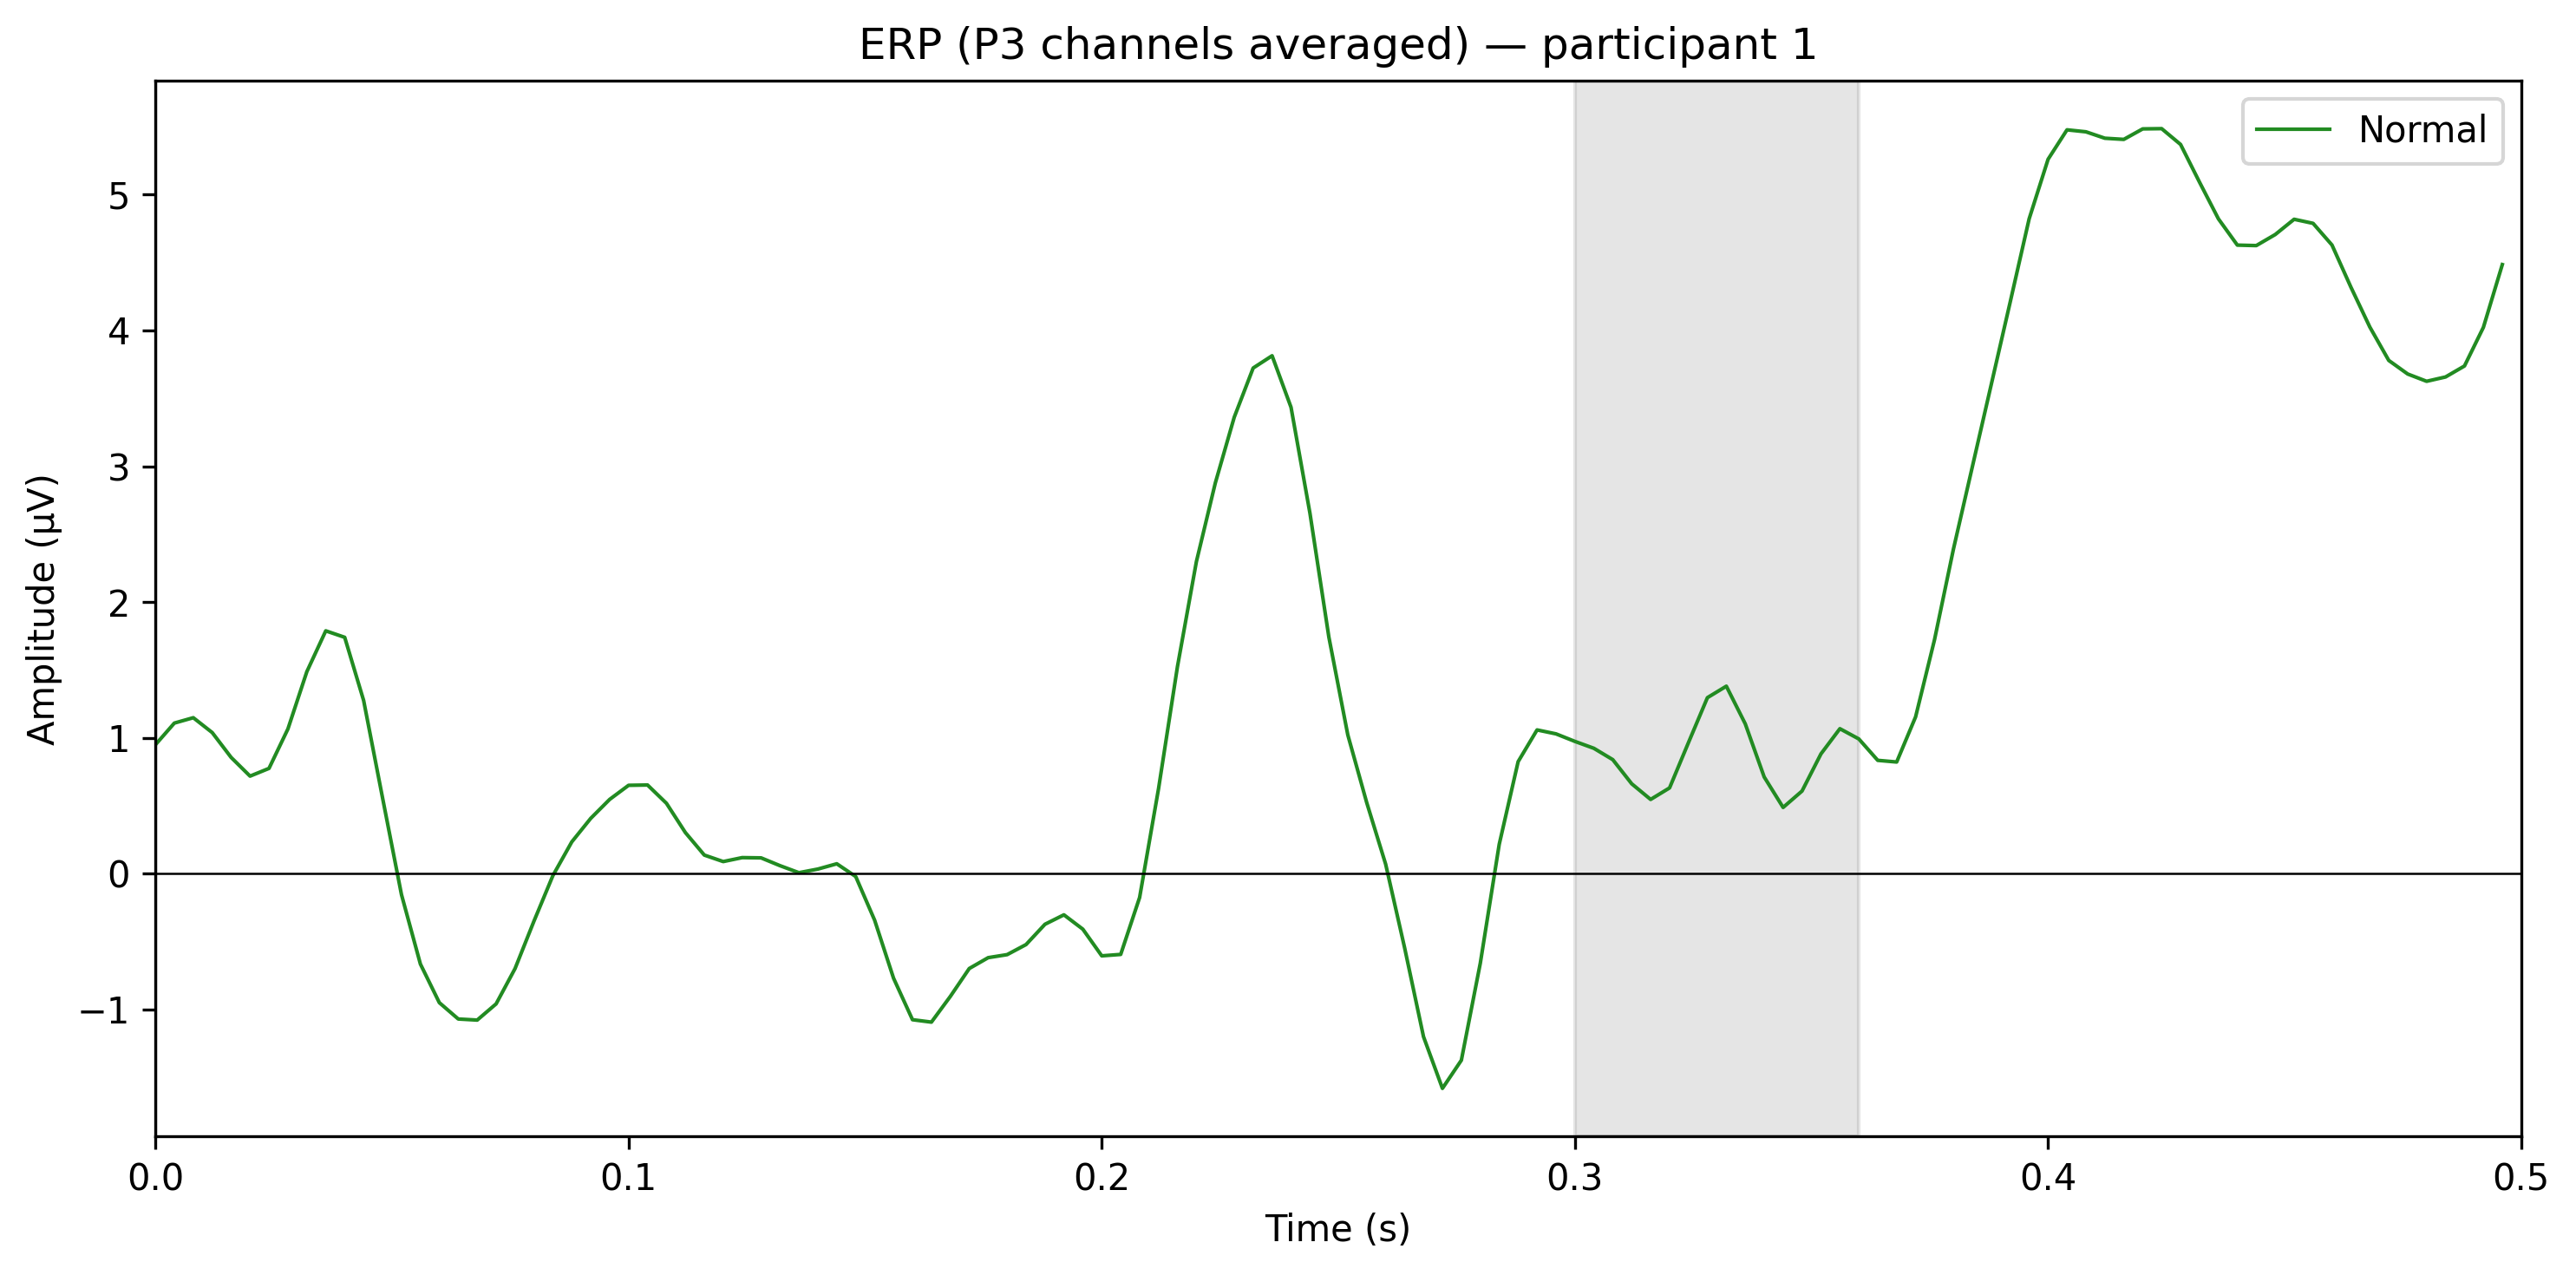

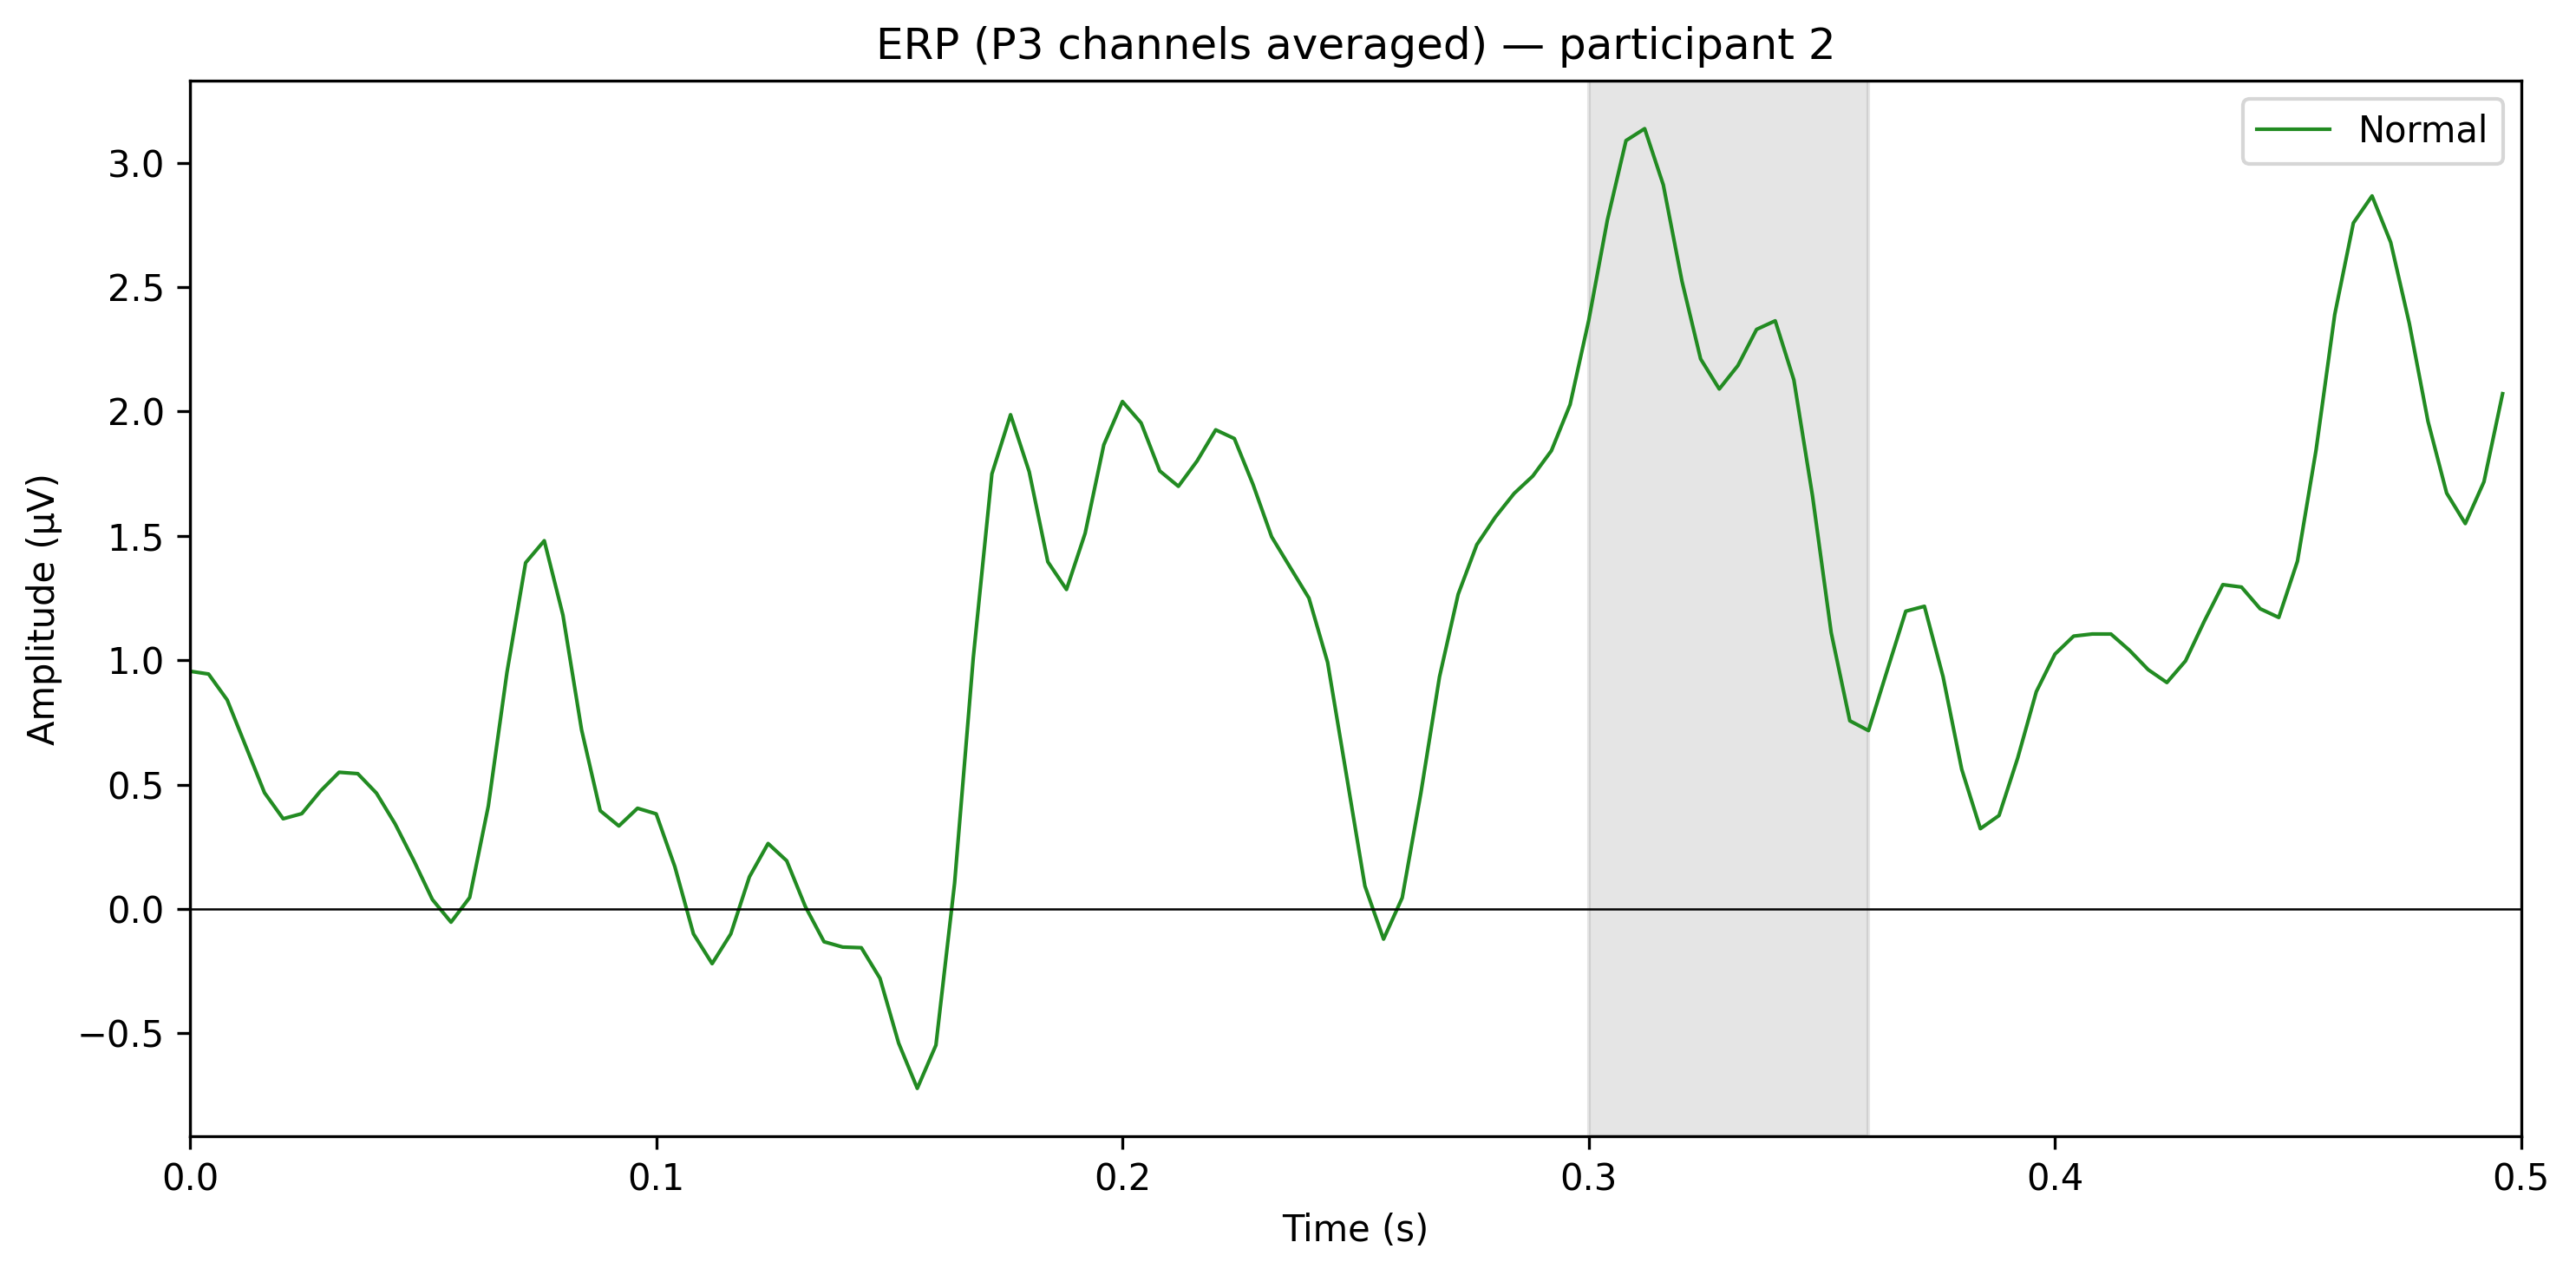

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# loop over participants  (all_epochs contains P1 then P2)
# -------------------------------------------------------------
for subj_idx, epochs in enumerate(all_epochs, start=1):

    # ---------- 1. grand average across channels & trials -----
    # get_data  →  shape (n_trials, n_channels, n_times)
    norm  = epochs["Normal"  ].get_data(picks=picks_p3b, tmin=0.0, tmax=0.5)
    surp  = epochs["Surprise"].get_data(picks=picks_p3b, tmin=0.0, tmax=0.5)

    norm_mean  = norm.mean(axis=(0, 1)) * 1e6     # → µV, shape (n_times,)
    surp_mean  = surp.mean(axis=(0, 1)) * 1e6

    times = epochs_t.times                           # x-axis in seconds

    # ---------- 2. plot for this participant ------------------
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

    ax.axvspan(0.300, 0.360, color="grey", alpha=0.2, zorder=-1)   # P3 window
    ax.plot(times, surp_mean - norm_mean, label="Normal",  color="forestgreen", lw=1)

    ax.axvline(0, color="black", lw=1)
    ax.axhline(0, color="black", lw=0.6)

    ax.set(
        xlim=(0, 0.5),
        xlabel="Time (s)",
        ylabel="Amplitude (µV)",
        title=f"ERP (P3 channels averaged) — participant {subj_idx}"
    )
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()


## VMMN Subject Level

In [ ]:
all_epochs

[<Epochs | 244 events (all good), -0.2 – 0.596 s (baseline -0.2 – 0 s), ~12.0 MB, data loaded,
  'Experiment/Start ': 1
  'Question/Shows': 4
  'Question/Disappears': 4
  'Disappears': 109
  'Disappears/NearCorner': 8
  'Normal/Reappears': 90
  'Normal/Reappears/NearCorner': 10
  'Surprise/Reappears': 16
  'FinalDisappear': 1
  'CornerHit': 1>,
 <Epochs | 237 events (all good), -0.2 – 0.596 s (baseline -0.2 – 0 s), ~11.6 MB, data loaded,
  'Experiment/Start ': 2
  'Question/Shows': 4
  'Question/Disappears': 4
  'Disappears': 106
  'Disappears/NearCorner': 7
  'Normal/Reappears': 87
  'Normal/Reappears/NearCorner': 9
  'Surprise/Reappears': 16
  'FinalDisappear': 1
  'CornerHit': 1>]

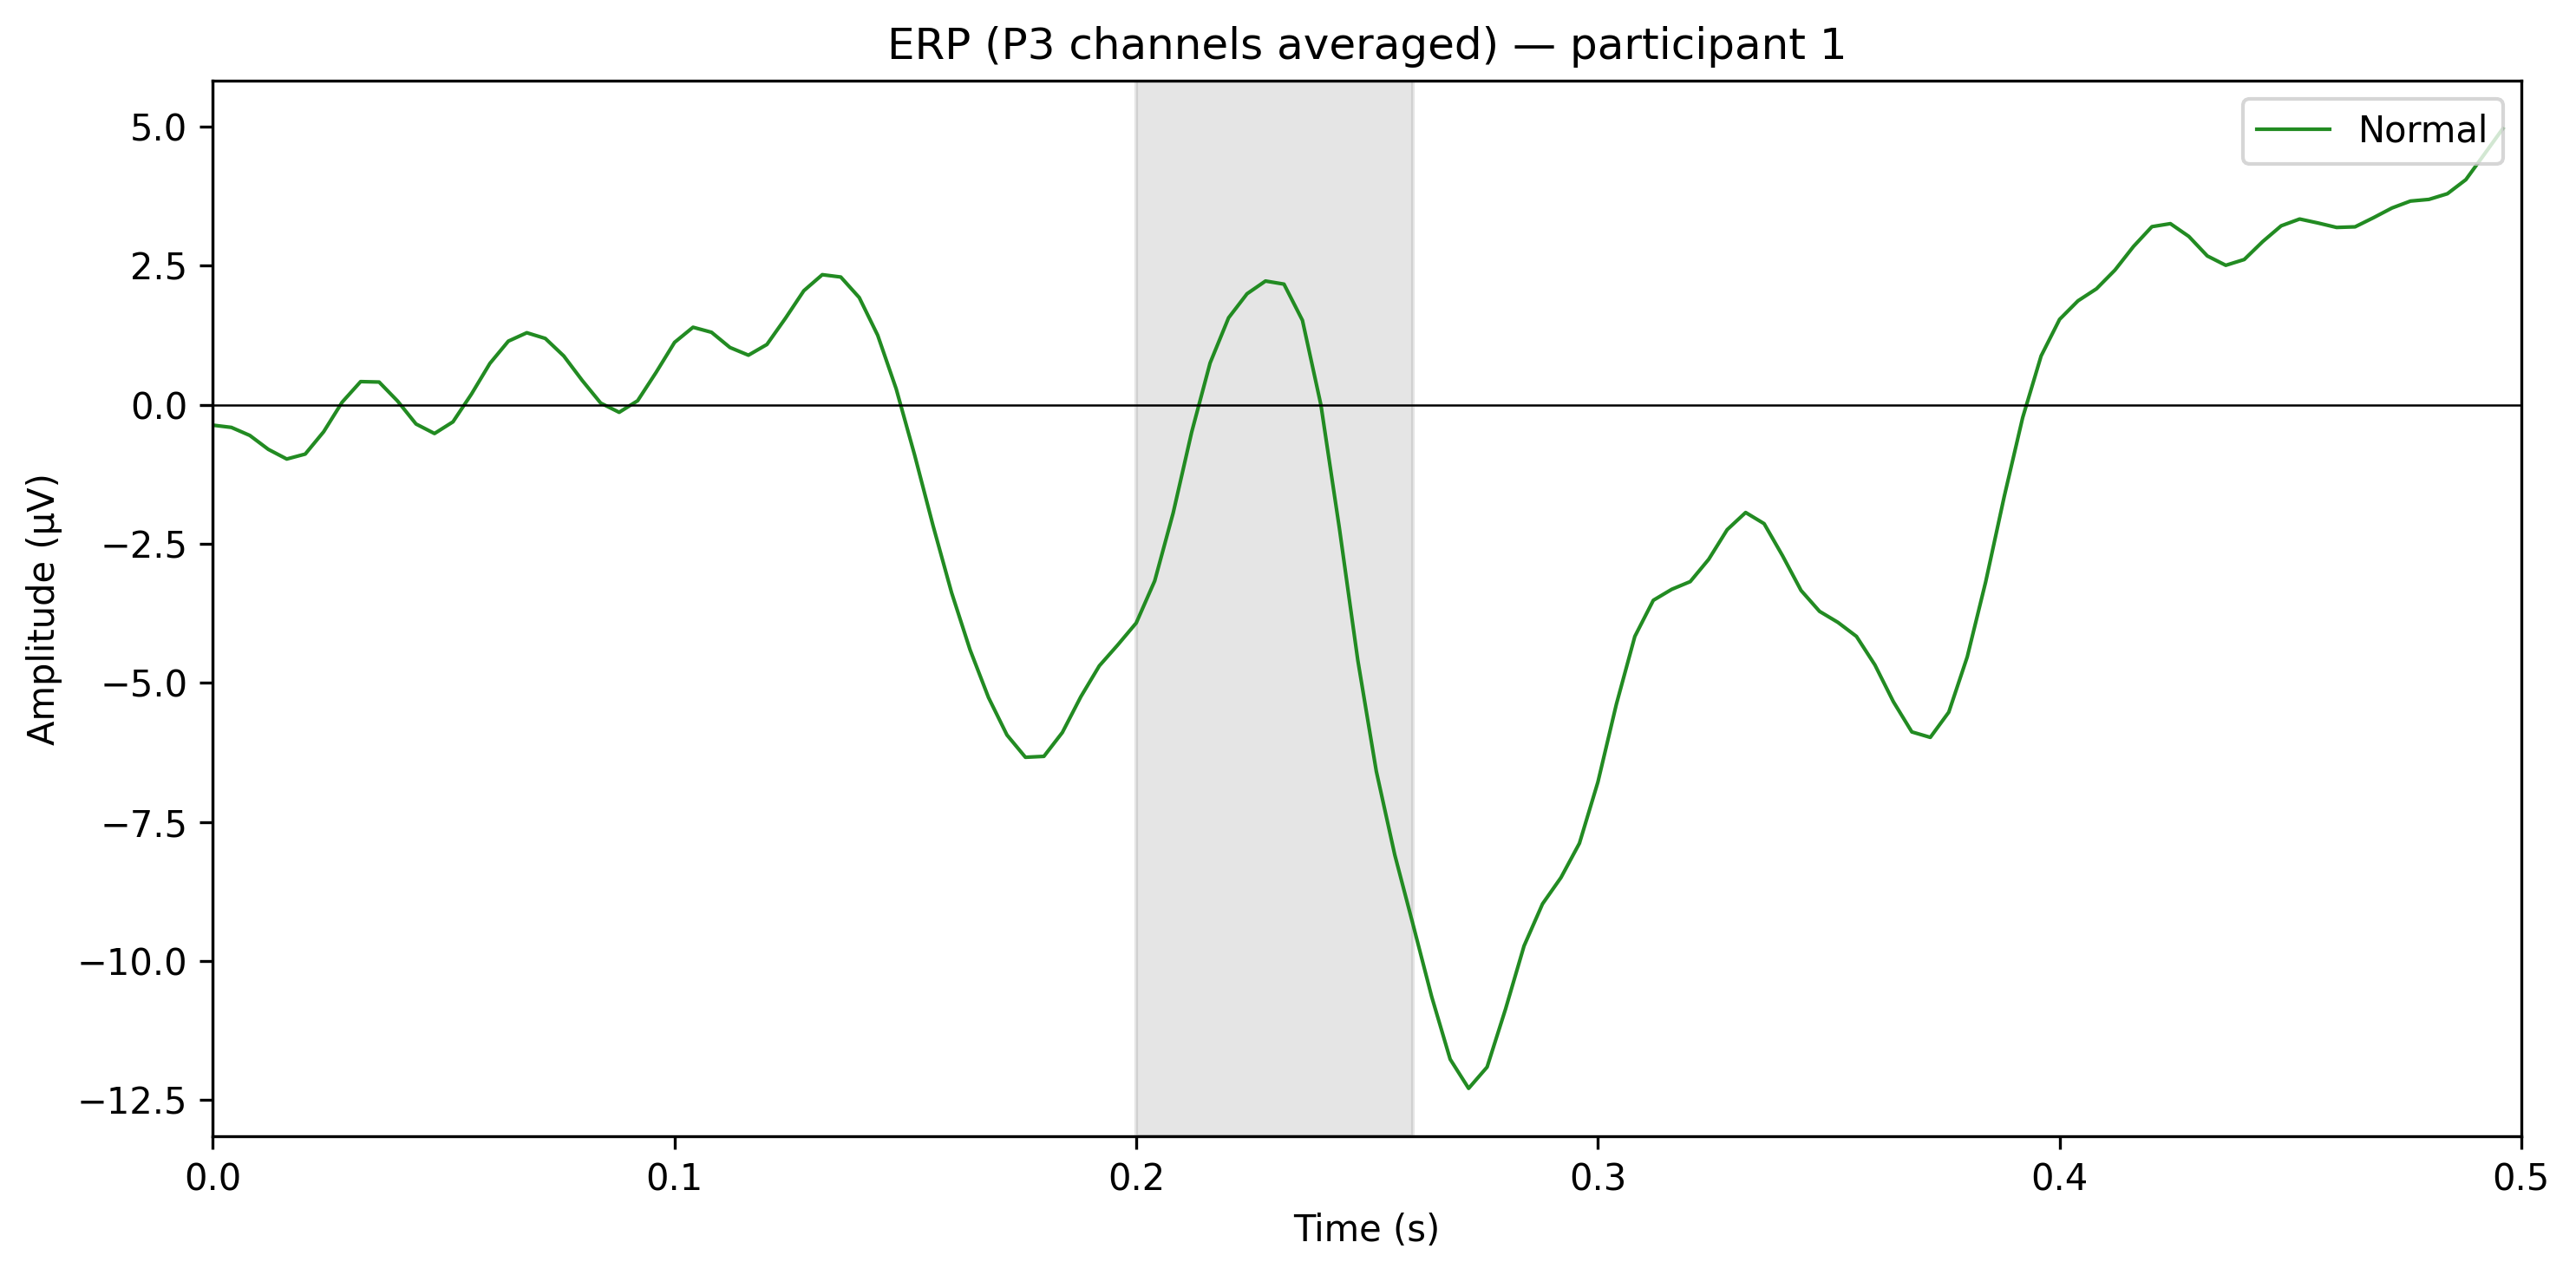

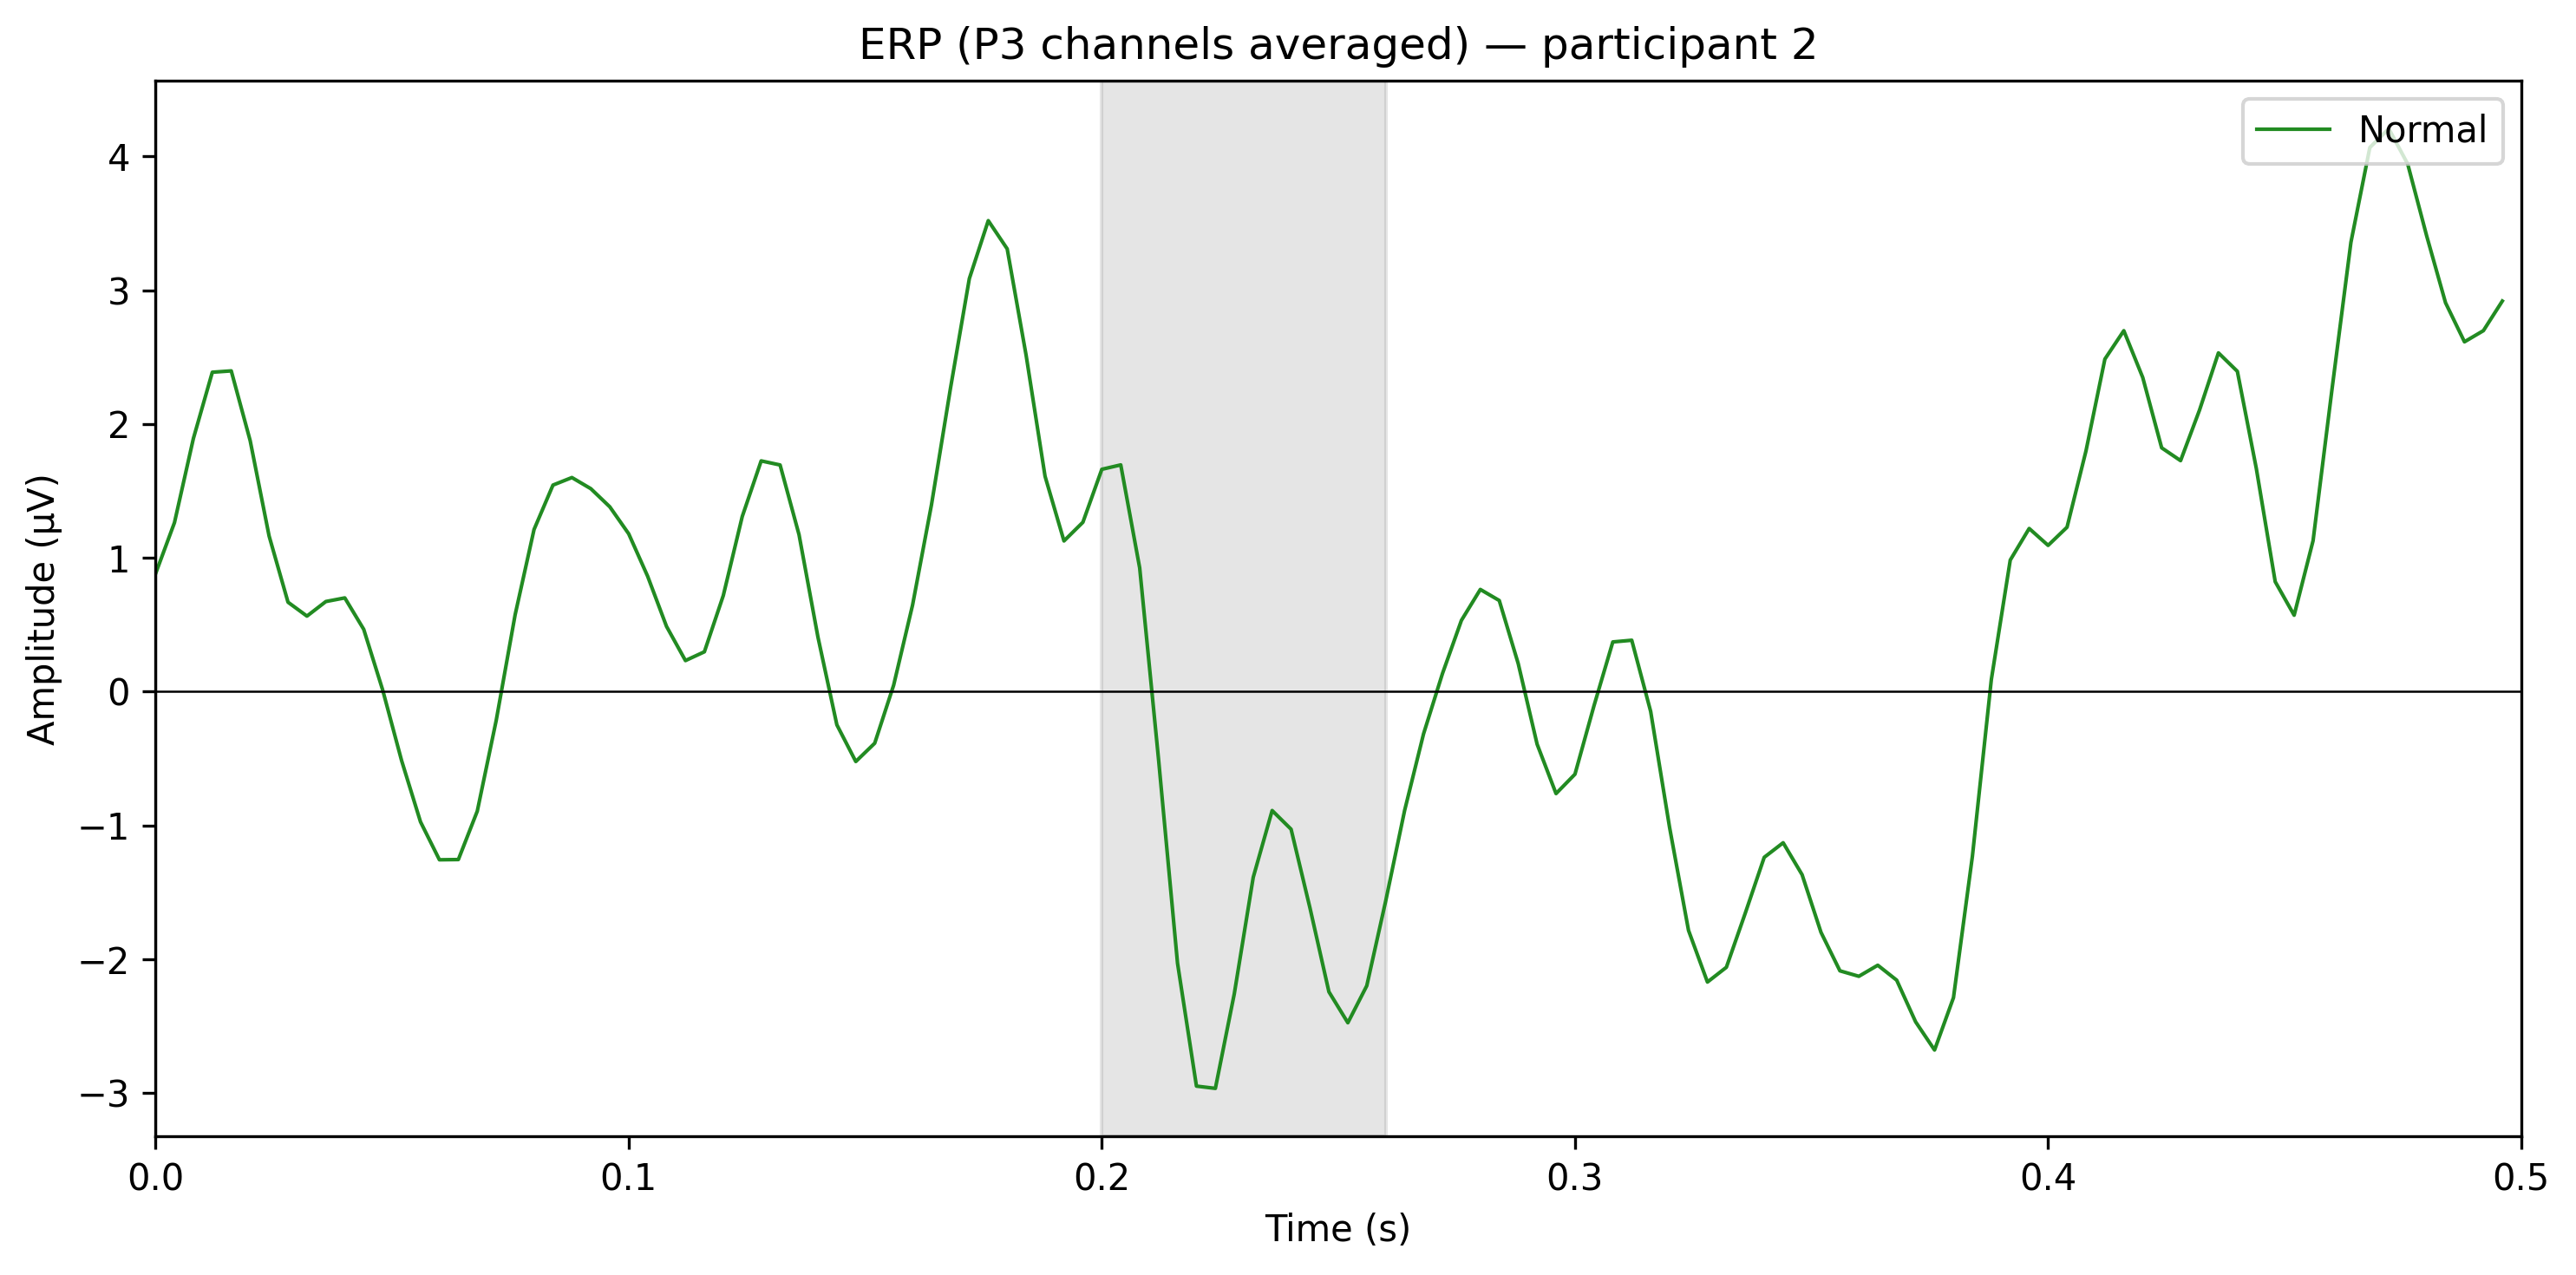

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# loop over participants  (all_epochs contains P1 then P2)
# -------------------------------------------------------------
for subj_idx, epochs in enumerate(all_epochs, start=1):

    # ---------- 1. grand average across channels & trials -----
    # get_data  →  shape (n_trials, n_channels, n_times)
    norm  = epochs["Normal"].get_data(picks=picks_vmmn, tmin=0.0, tmax=0.5)
    surp  = epochs["Surprise"].get_data(picks=picks_vmmn, tmin=0.0, tmax=0.5)

    norm_mean  = norm.mean(axis=(0, 1)) * 1e6     # → µV, shape (n_times,)
    surp_mean  = surp.mean(axis=(0, 1)) * 1e6

    times = epochs_t.times                           # x-axis in seconds

    # ---------- 2. plot for this participant ------------------
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

    ax.axvspan(0.200, 0.260, color="grey", alpha=0.2, zorder=-1)   # P3 window
    ax.plot(times, surp_mean - norm_mean, label="Normal",  color="forestgreen", lw=1)

    ax.axvline(0, color="black", lw=1)
    ax.axhline(0, color="black", lw=0.6)

    ax.set(
        xlim=(0, 0.5),
        xlabel="Time (s)",
        ylabel="Amplitude (µV)",
        title=f"ERP (P3 channels averaged) — participant {subj_idx}"
    )
    ax.legend(loc="upper right")
    fig.tight_layout()
    plt.show()
